# Sensorx Contaminant Detection

### All package imports

In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import os
import PIL #from PIL import Image
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from skimage.measure import regionprops, label

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.52
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 418.39
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.18.0-1014-azure-x86_64-with-debian-buster-sid
distro        : #14~18.04.1-Ubuntu SMP Mon Mar 18 16:15:53 UTC 2019
conda env     : Unknown
python        : /home/thor/anaconda3/bin/python
sys.path      : /home/thor/Scripts
/home/thor/anaconda3/lib/python37.zip
/home/thor/anaconda3/lib/python3.7
/home/thor/anaconda3/lib/python3.7/lib-dynload

/home/thor/anaconda3/lib/python3.7/site-packages
/home/thor/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) 

### Data

In [3]:
cwd = os.getcwd()

path = Path(cwd + '/data/')
path.ls()

[PosixPath('/home/thor/Scripts/data/NoBoneImages.txt'),
 PosixPath('/home/thor/Scripts/data/masks'),
 PosixPath('/home/thor/Scripts/data/AdditionalNotTrustedImagesRemoved.txt'),
 PosixPath('/home/thor/Scripts/data/images'),
 PosixPath('/home/thor/Scripts/data/FullDataset.zip'),
 PosixPath('/home/thor/Scripts/data/MetalImages.txt'),
 PosixPath('/home/thor/Scripts/data/MetalImagesToDuplicate.txt'),
 PosixPath('/home/thor/Scripts/data/valid.txt')]

In [4]:
path_lbl = path/'masks'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thor/Scripts/data/images/MAGNA_58_76.4686CL_3.45358kg.tiff'),
 PosixPath('/home/thor/Scripts/data/images/MAGNA_44_-1CL_0.570008kg.tiff'),
 PosixPath('/home/thor/Scripts/data/images/MAGNA_28_-1CL_0.0184416kg.tiff')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thor/Scripts/data/masks/MAGNA_58_76.4686CL_3.45358kg.tiff'),
 PosixPath('/home/thor/Scripts/data/masks/MAGNA_44_-1CL_0.570008kg.tiff'),
 PosixPath('/home/thor/Scripts/data/masks/MAGNA_28_-1CL_0.0184416kg.tiff')]

### Removing images with no contaminant

In [7]:
allFiles = [file.name for file in fnames]

inF = open("noContaminant.txt", "r")
files = inF.readlines()
inF.close()

files = [f[:-1] for f in files]

size = len(allFiles) - 1
for i, name in enumerate(allFiles[::-1]):
    if name in files:
        idxToDelete = size - i
#         print(f'{name} - {idxToDelete}\n--{fnames[idxToDelete]}\n--{lbl_names[idxToDelete]}')
        del fnames[idxToDelete]
        del lbl_names[idxToDelete]


### Selecting validation images

In [8]:
# Select 10% validation images and handpicked meatl images
metal = ['MAGNA_3_86.3626CL_3.97524kg.tiff',
'MAGNA_20_78.9422CL_0.960883kg.tiff', 
'MAGNA_48_-1CL_0.437527kg.tiff', 
'MAGNA_49_-1CL_0.440395kg.tiff', 
'MAGNA_50_-1CL_0.317512kg.tiff', 
'MAGNA_51_-1CL_0.453667kg.tiff', 
'MAGNA_52_-1CL_0.360127kg.tiff', 
'MAGNA_53_-1CL_0.446551kg.tiff', 
'MAGNA_54_-1CL_0.441927kg.tiff', 
'MAGNA_55_-1CL_0.454831kg.tiff', 
'MAGNA_56_-1CL_0.446517kg.tiff', 
'MAGNA_57_-1CL_0.442111kg.tiff', 
'MAGNA_58_-1CL_0.453068kg.tiff', 
'MAGNA_59_-1CL_0.328768kg.tiff', 
'MAGNA_60_-1CL_0.439103kg.tiff', 
'MAGNA_61_83.7706CL_3.88116kg.tiff']

no_metal_names = np.array([img.name for img in fnames])
for metal_img in metal:
    no_metal_names = no_metal_names[no_metal_names != metal_img]

validation_count = len(no_metal_names) // 10 # 10% of the non-metal images
validation_files = np.random.choice(no_metal_names, size=validation_count, replace=False)
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tiff', 'MAGNA_61_83.7706CL_3.88116kg.tiff',
                             'MAGNA_54_-1CL_0.441927kg.tiff']
validation_files = np.append(validation_files, validation_metal)

outF = open(str(path) + "/valid.txt", "w")
output = map(lambda x: x + '\n', validation_files)
outF.writelines(output)
outF.close()

### Data

Image (3, 700, 768)


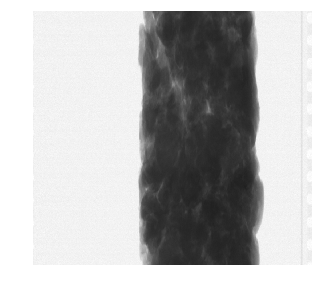

In [9]:
## Data

img_f = fnames[0]
img = open_image(img_f)
print(img)
img.show(figsize=(5,5))

Example label


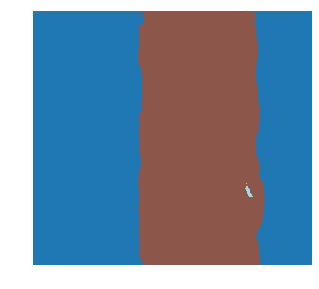

In [10]:
def get_y_fn(x):
    ''' Returns the corresponding labeled image 
    x - Image name in the dataset
    '''
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
print("Example label")
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])

### Selecting image channels to use

In [11]:
layers = {"highImg": 0, "lowImg": 1, "plastImg": 2, "alImg": 3, "lowImgReg": 4, "highImgReg": 5}

def read_tiff(img, images_to_use=["lowImgReg", "highImgReg"]):
    """ Reads the desired layers as a multi channel/layer tiff image
    img           - Full file path to the image
    images_to_use - The images/layers/channels to use
    """
    n_images = len(images_to_use)
    if n_images > 1:
        channels = 3           # The FastAI library as, "lowImg"sumes 1 or 3 channels in many cases
    else:
        channels = 1

    images = []
    for i in range(channels):
        if i < n_images:
            img.seek(i)
            slice_ = np.array(img)
            images.append(slice_)
        else:
            slice_ = np.ones(slice_.shape)
            images.append(slice_)

    return np.transpose(np.array(images), (1, 2, 0)) # The FastAI expects this strange dimension order, then it transposes back

img = PIL.Image.open(path / 'images/MAGNA_3_86.3626CL_3.97524kg.tiff')
image = read_tiff(img)

### Preparing the dataset

In [12]:
## Datasets
bs,size = 2,src_size//2

# Two lists of transforms (train and valid)
# 
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=None, max_zoom=1.0, max_lighting=None, max_warp=0.1, p_affine=0.7, p_lighting=0)

src = (SegmentationItemList.from_folder(path_img, convert_mode=None, extensions=('.tiff'), after_open=read_tiff)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(transforms, size=size, tfm_y=True) # tfm_y=True to apply the same transform to the mask
        .databunch(bs=bs)
        .normalize(imagenet_stats))

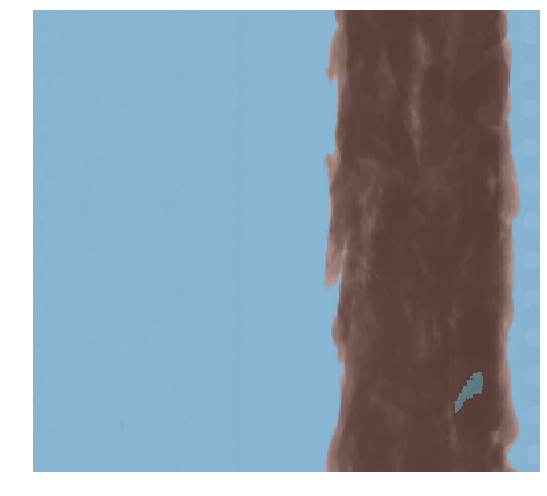

In [13]:
data.show_batch(1, figsize=(10,7))

### Custom metric functions

In [14]:
def numb_contaminants(data):
    '''
    data - Labeled image
    '''
    data = data.cpu().numpy().astype(int)
        
    data[data == 1] = 0  # Set meat as background

    labels = label(data, background=0) # same image_binary as above
    regions = regionprops(labels)
    contaminant_count = len(regions)
    return float(contaminant_count)

def numb_incorrect_contaminants(input, target):
    ''' Computes the average number of incorrect number of contaminants in labeled image
    input  - The predicted output
    target - The true labels
    '''
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    
    count_incorrect = numb_contaminants(input) - numb_contaminants(target)
    
    ret = torch.Tensor(1)
    ret[0] = count_incorrect
    return ret

def numb_incorrect_contaminant_pixels(input, target):
    ''' Counts total number of incorrect pixels
    input  - The predicted output
    target - The true labels
    '''
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    
    input = input.cpu().numpy().astype(int)
    target = target.cpu().numpy().astype(int)

    total_pixel_count = len(target[target == 2]) + len(target[target == 3])
    
    total_predicted_pixel_count = len(input[input == 2]) + len(input[input == 3])
    
    bones = input[(target == 2)]
    metals = input[(target == 3)]
    predicted_correct_pixels = len(bones[(bones == 2)]) + len(metals[(metals == 3)])
    predicted_wrong_pixels = total_predicted_pixel_count - predicted_correct_pixels

    ret = torch.Tensor(1)
    ret[0] = float(total_pixel_count - predicted_correct_pixels + predicted_wrong_pixels)
    return ret

def numb_missing_contaminants(input, target):
    '''Counts the undetected contaminants
    input  - The predicted output
    target - The true labels
    '''
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    
    input = input.cpu().numpy().astype(int)
    target = target.cpu().numpy().astype(int)
    
    target[target == 1] = 0                # Set the meat as background

    labels = label(target, background=0)
    regions = regionprops(labels)
    unfound_contaminants = len(regions)    # The total number on not found contaminants
    for reg in regions:
        for x, y, z in reg.coords:
            pred = input[x, y, z]
            if pred != 0 and pred != 1:
                unfound_contaminants -= 1  # The prediction is contaminant thus reducing by one
                break

    ret = torch.Tensor(1)
    ret[0] = float(unfound_contaminants)
    return ret

### Defining the loss function

In [15]:
def dice_loss(input, target):
    '''
    input  - The predicted output
    target - The true labels
    '''
    input = torch.sigmoid(input)
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [16]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    '''
    input  - The predicted output
    target - The true labels
    '''
    return dice(input, targs, iou=True) # Use the IoU function implemented in FastAI

In [17]:
# Edit from: https://forums.fast.ai/t/deeplearning-lec9-notes/14113
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data]

# Edit from https://github.com/samuelschen/DSB2018/blob/master/loss.py
class FocalLoss(nn.Module):
    """
    Focal Loss for Dense Object Detection [https://arxiv.org/abs/1708.02002]
    Digest the paper as below:
        α, balances the importance of positive/negative examples
        γ, focusing parameter that controls the strength of the modulating term
            CE(pt) = −log(pt) ==> pt = exp(-CE)
            FL(pt) = −α((1 − pt)^γ) * log(pt)
        In general α should be decreased slightly as γ is increased (for γ = 2, α = 0.25 works best).
    """
    def __init__(self, focusing_param=2., balance_param=0.25, num_classes=4):
        super().__init__()
        self.gamma = focusing_param
        self.alpha = balance_param
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        '''
        inputs  - The predicted output
        targets - The true labels
        '''
        targ = one_hot_embedding(targets, self.num_classes).cuda()
#         print("targ", targ, targ.size(), type(targ), np.unique(targ))
        targ = targ.permute(0,3,1,2)
        uniq = np.unique(inputs)
        pred = inputs.sigmoid() # This added since the inputs are in the range [-13.611954:7.559714]
                                # But should be in the range [0:1] for the binary_cross_entropy 
        logpt = -F.binary_cross_entropy(pred, targ)
        # The logpt is the same as nn.BCEWithLogitsLoss() see: https://gombru.github.io/2018/05/23/cross_entropy_loss/ (Binary Cross-Entropy Loss)
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -((1-pt)**self.gamma) * logpt
        balanced_focal_loss = self.alpha * focal_loss
        return balanced_focal_loss

In [18]:
class FocalLoss_NoMeat(nn.Module):
    '''Focal loss treating the meat as background'''
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss()
        
    def forward(self, input, target):
        '''
        input  - The predicted output
        target - The true labels
        '''
        
        target[target == 1] = 0    # Changs all meat to background
        
        return torch.log(self.focal(input, target))  # Adding extra log() to give more diffrence to small loss values
    
class CrossEntropyLoss_NoMeat():
    '''Cross entropy loss treating the meat as background'''
    
    def __init__(self):
        self.func = CrossEntropyFlat(axis=1)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"Custom weighted {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        '''
        input  - The predicted output
        target - The true labels
        '''
        target[target == 1] = 0    # Changs all meat to background
        
        return self.func.__call__(input, target, **kwargs)
    
class CrossEntropyLoss_ExtaLog():
    '''Cross entropy loss with extra log to increas the loss gain'''
    
    def __init__(self):
        self.func = CrossEntropyFlat(axis=1)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"Custom weighted {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        '''
        input  - The predicted output
        target - The true labels
        '''
        
        return torch.log(self.func.__call__(input, target, **kwargs))

### Setting up the convolutional network

In [19]:
# pixels_metal = 492
# pixels_bone  = 13090584
# pixels_meat  = 2929532556
# pixels_other = 3877907568
    
# total = pixels_metal + pixels_bone + pixels_meat + pixels_other

# print("Percentage weights for each class")
# p_metal = pixels_metal / pixels_metal
# p_bone  = pixels_metal / pixels_bone  * 1000
# p_meat  = pixels_metal / pixels_meat  * 10000
# p_belt  = pixels_metal / pixels_other * 10000
# print("metal: ", p_metal)
# print("bone: ", p_bone)
# print("meat: ", p_meat)
# print("other: ", p_belt)

# weight = torch.FloatTensor([p_belt, p_meat, p_bone, p_metal]).cuda()

In [20]:
def pretrained_model(pretrained=True):
    return models.resnet34(pretrained)

wd=1e-2 # Weight decay

weight = torch.FloatTensor([0.0015, 0.0015, 0.0030, 1]).cuda()
learn = unet_learner(data, models.resnet34, wd=wd, loss_func=CrossEntropyFlat(axis=1, weight=weight))

learn.metrics=[dice, IoU, numb_incorrect_contaminants, numb_incorrect_contaminant_pixels, numb_missing_contaminants]

In [21]:
help(models.resnet34)

Help on function resnet34 in module torchvision.models.resnet:

resnet34(pretrained=False, **kwargs)
    Constructs a ResNet-34 model.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet



In [22]:
x, y = data.one_batch(DatasetType.Train, True, True)
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (3845 items)
x: SegmentationItemList
Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/Scripts/data/images;

Valid: LabelList (384 items)
x: SegmentationItemList
Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384),Image (1, 350, 384)
y: SegmentationLabelList
ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384),ImageSegment (1, 350, 384)
Path: /home/thor/Scripts/data/images;

Test: None>

In [23]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


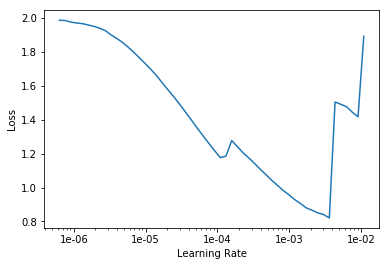

In [24]:
learn.recorder.plot()

In [25]:
lr=1e-4

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [27]:
learn.save('stage-1-big')

In [28]:
learn.load('stage-1-big');

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(1e-6,lr/10)

In [31]:
learn.fit_one_cycle(10, lrs)

In [32]:
learn.save('stage-2-big')

In [33]:
learn.load('stage-2-big');

### Visual inspection of the validation data

In [39]:
preds,y = learn.get_preds()

In [40]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 101, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 127, Metal: 0, Groups total: 1.0


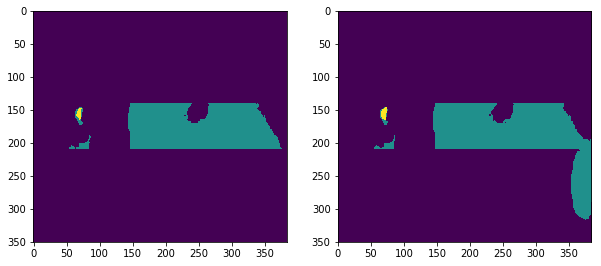

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 349, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 319, Metal: 0, Groups total: 1.0


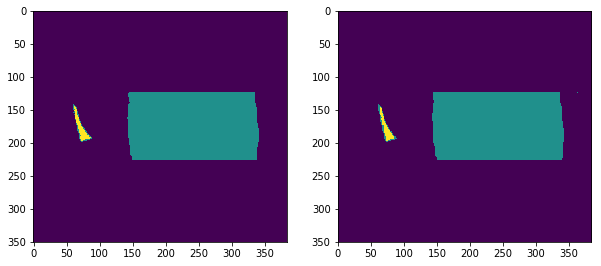

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 652, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 608, Metal: 0, Groups total: 1.0


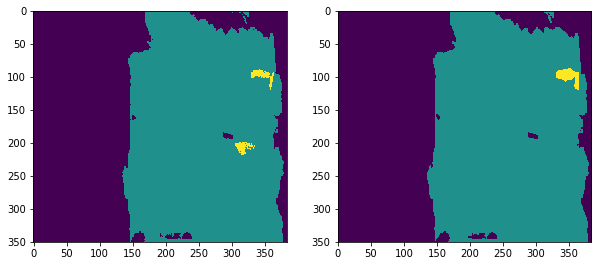

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 103, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 19, Metal: 0, Groups total: 1.0


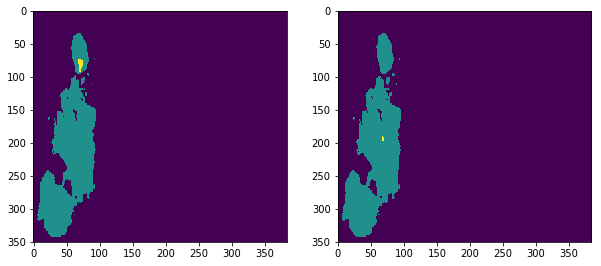

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 129, Metal: 0, Groups total: 2.0


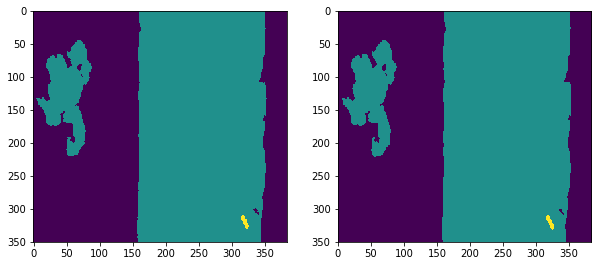

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 99, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 29, Metal: 0, Groups total: 1.0


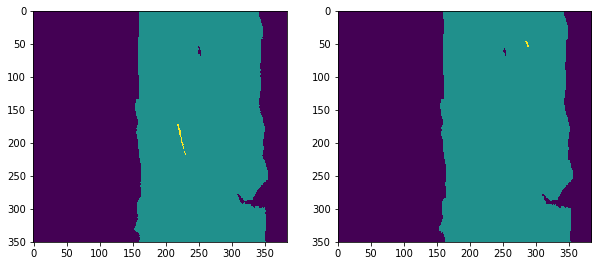

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


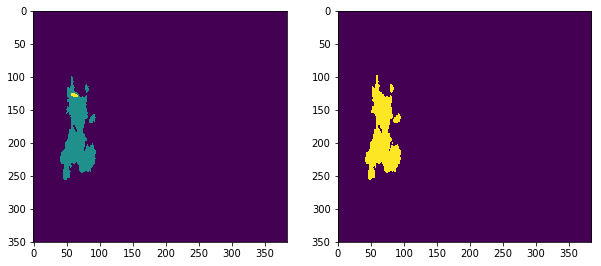

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 178, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


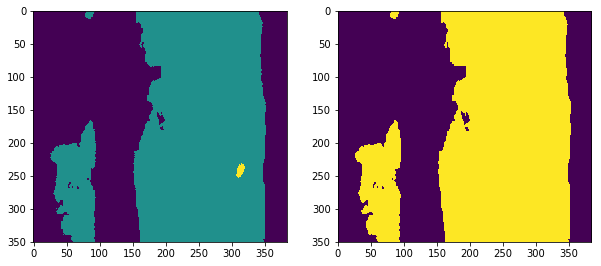

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1847, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 237, Metal: 0, Groups total: 3.0


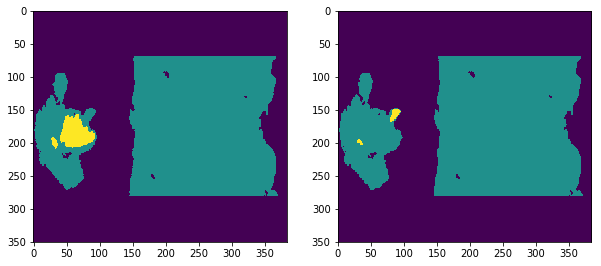

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 130, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 163, Metal: 0, Groups total: 1.0


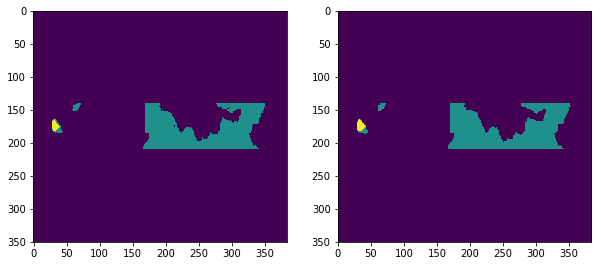

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 309, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 182, Metal: 0, Groups total: 1.0


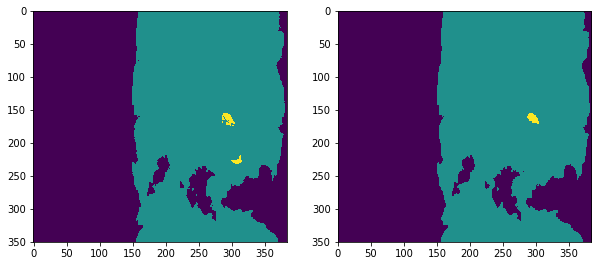

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 263, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 191, Metal: 0, Groups total: 2.0


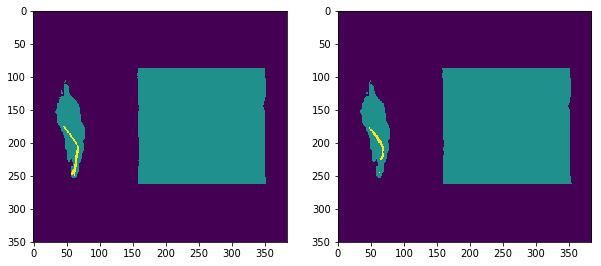

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 3253, Metal: 0, Groups total: 7.0
Prediction   -> Bone: 1324, Metal: 0, Groups total: 7.0


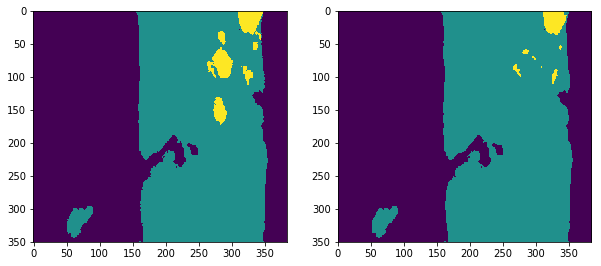

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 240, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 316, Metal: 0, Groups total: 7.0


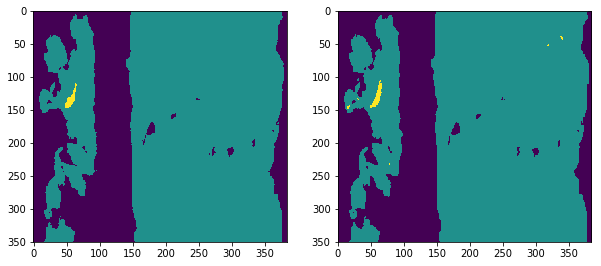

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 883, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 599, Metal: 0, Groups total: 4.0


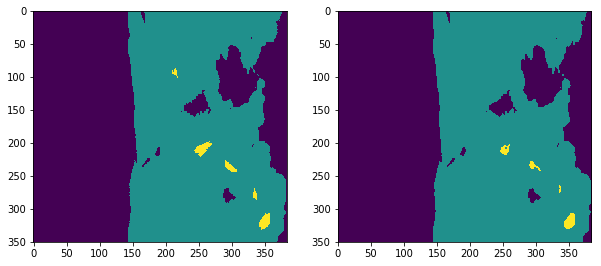

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 269, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 290, Metal: 0, Groups total: 2.0


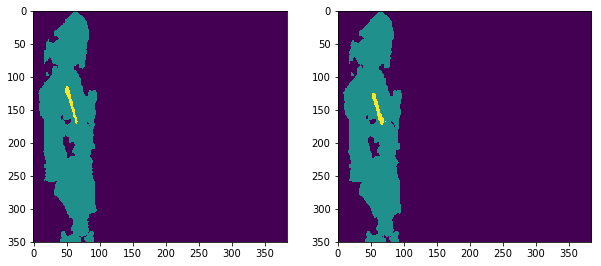

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 35, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 299, Metal: 0, Groups total: 2.0


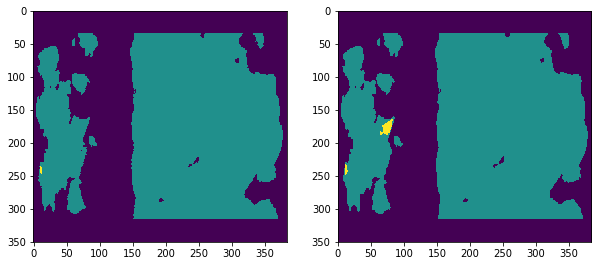

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 52, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 59, Metal: 0, Groups total: 1.0


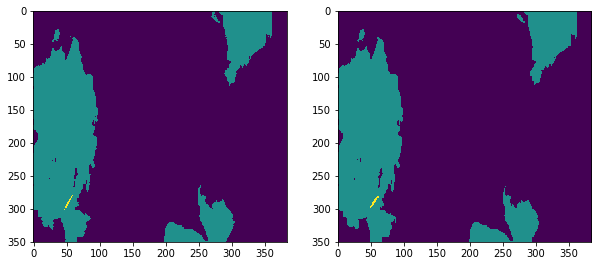

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 158, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


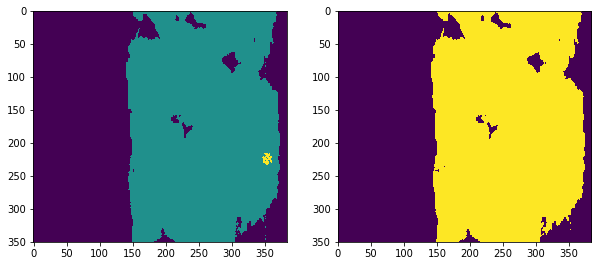

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 301, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 182, Metal: 0, Groups total: 1.0


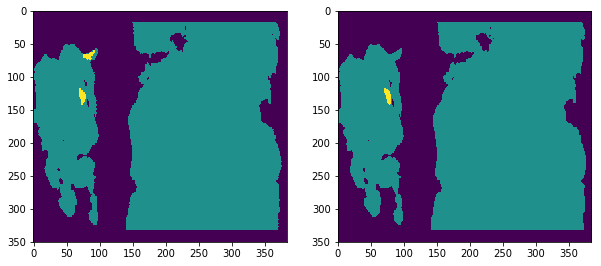

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


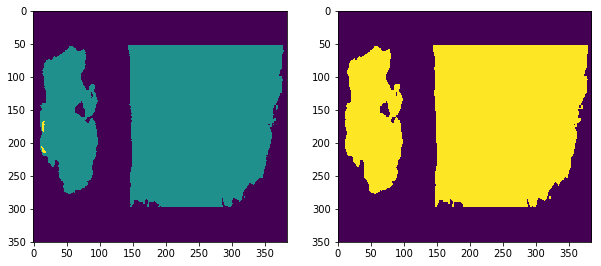

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


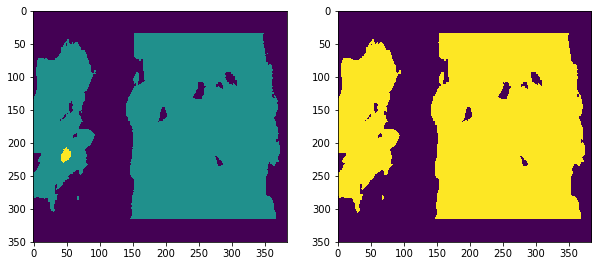

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 112, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 175, Metal: 0, Groups total: 4.0


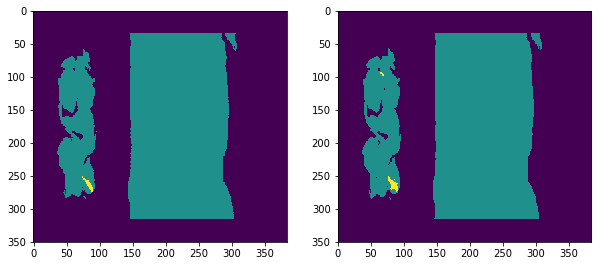

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 255, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


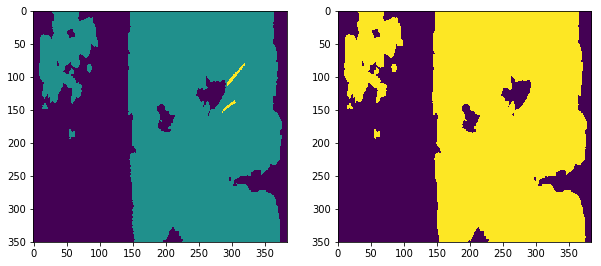

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1054, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1128, Metal: 0, Groups total: 3.0


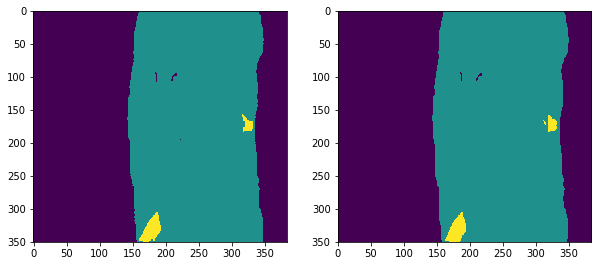

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 123, Metal: 0, Groups total: 1.0


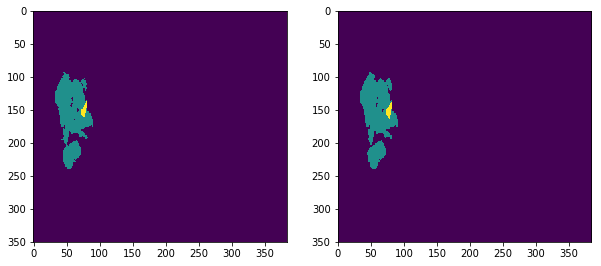

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 117, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


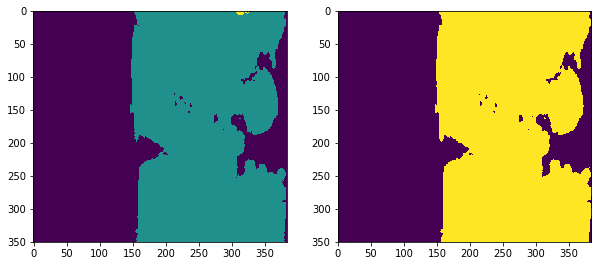

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 177, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 205, Metal: 0, Groups total: 1.0


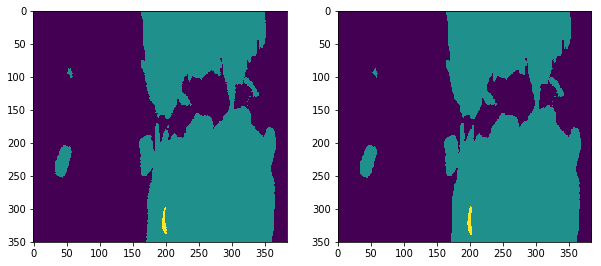

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 3.0


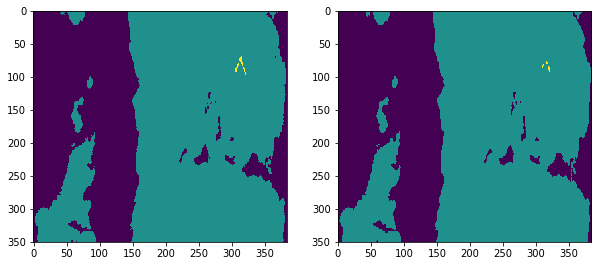

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 83, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


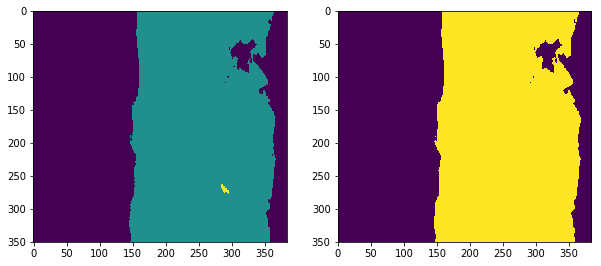

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 575, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 644, Metal: 0, Groups total: 1.0


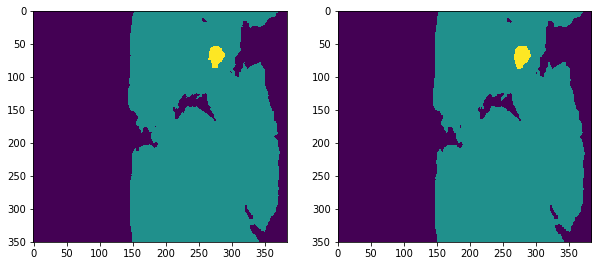

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 246, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 1.0


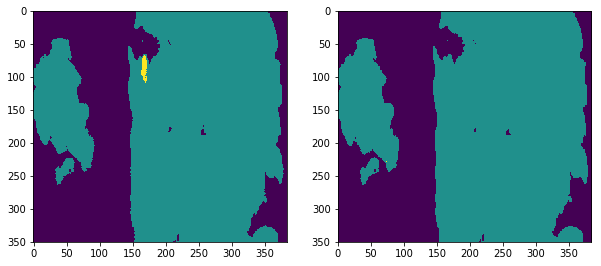

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 521, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 339, Metal: 0, Groups total: 1.0


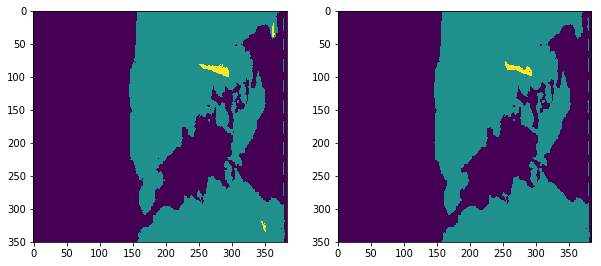

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 103, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 228, Metal: 0, Groups total: 2.0


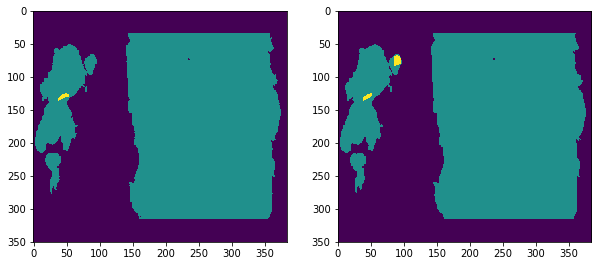

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


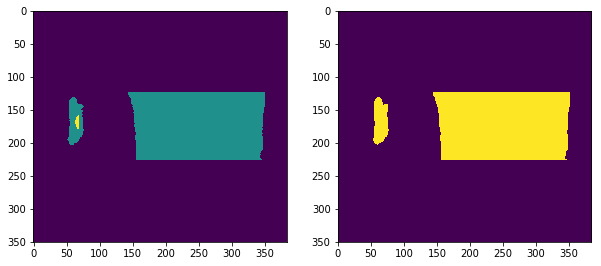

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 92, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 80, Metal: 0, Groups total: 1.0


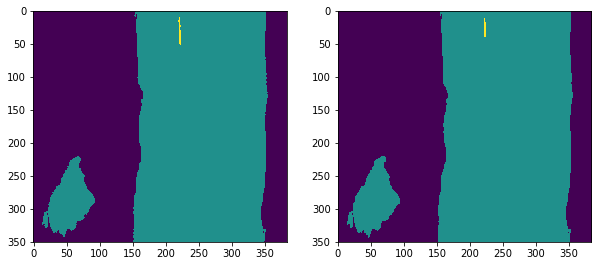

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 173, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


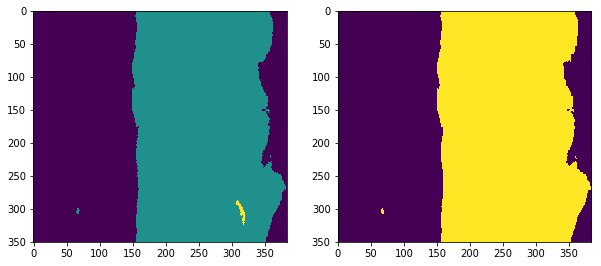

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 99, Metal: 0, Groups total: 1.0


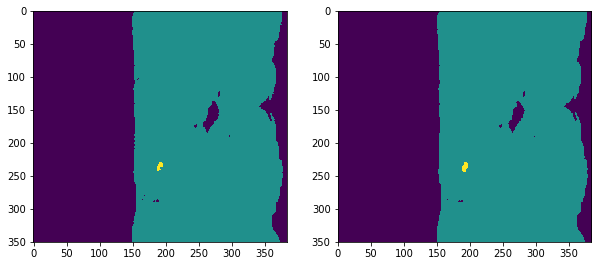

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 288, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 64, Metal: 0, Groups total: 8.0


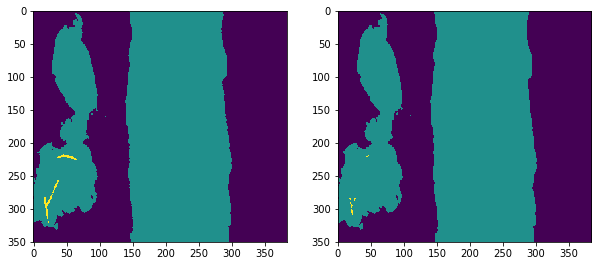

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 215, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 116, Metal: 0, Groups total: 2.0


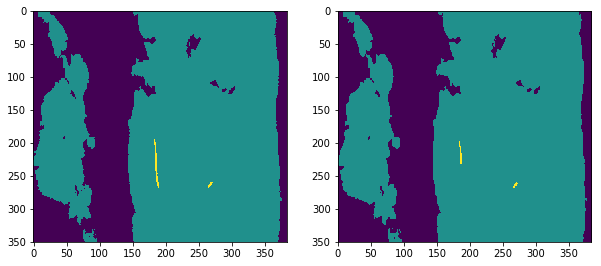

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 280, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 37, Metal: 0, Groups total: 1.0


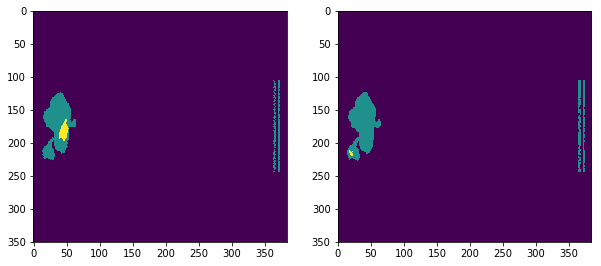

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1622, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1044, Metal: 0, Groups total: 4.0


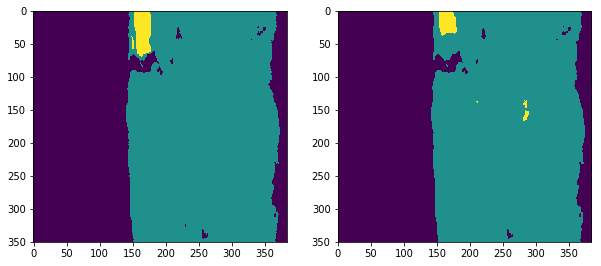

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 297, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 207, Metal: 0, Groups total: 1.0


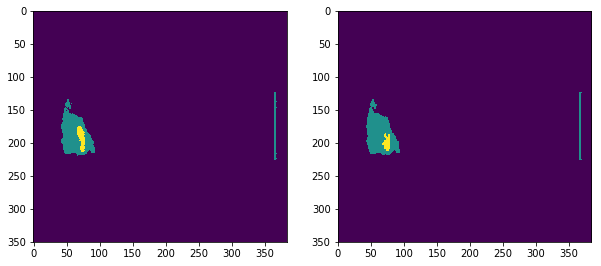

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 298, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 188, Metal: 0, Groups total: 7.0


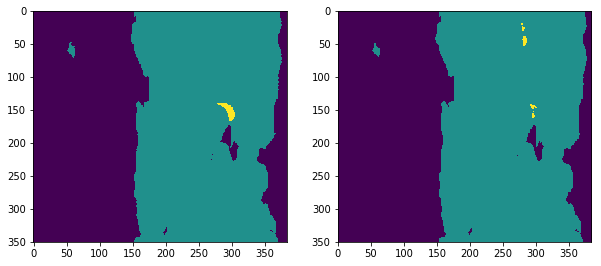

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 630, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 442, Metal: 0, Groups total: 1.0


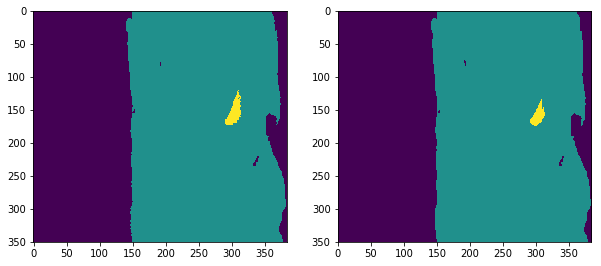

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 150, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


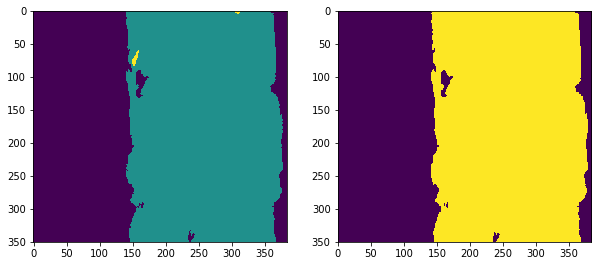

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 138, Metal: 0, Groups total: 1.0


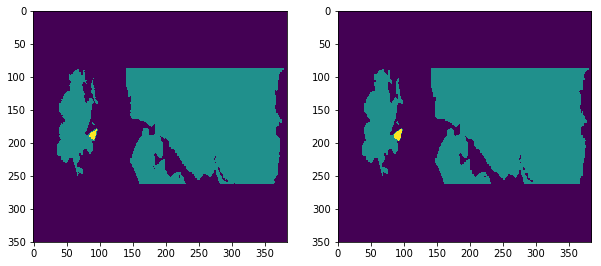

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 110, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


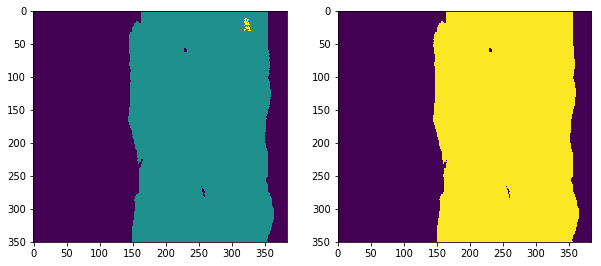

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 261, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 36, Metal: 0, Groups total: 1.0


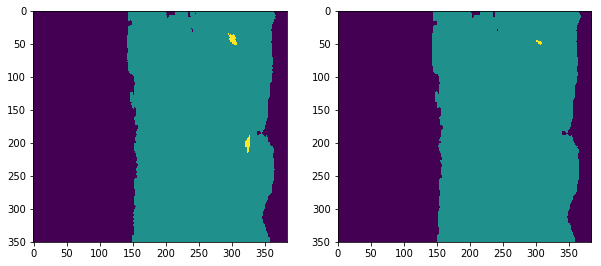

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 6.0


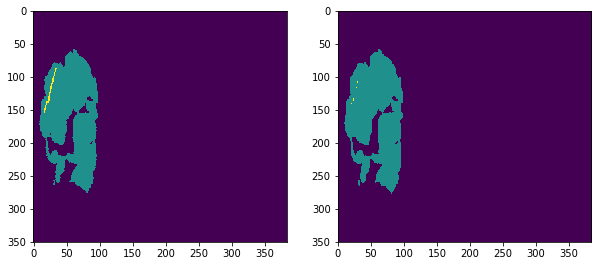

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 1.0


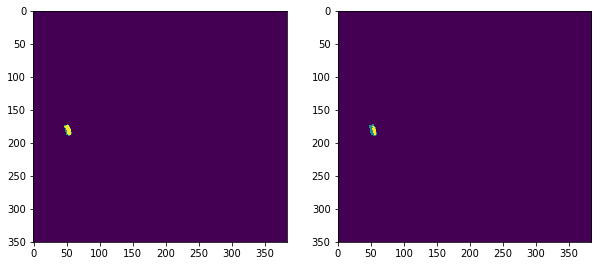

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 67, Metal: 0, Groups total: 1.0


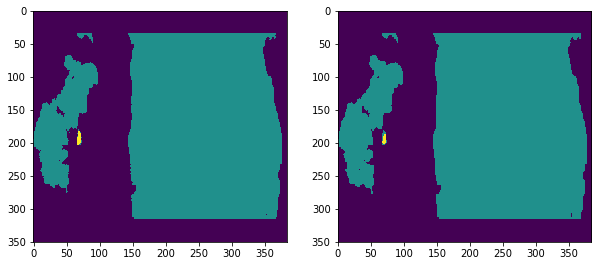

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 220, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


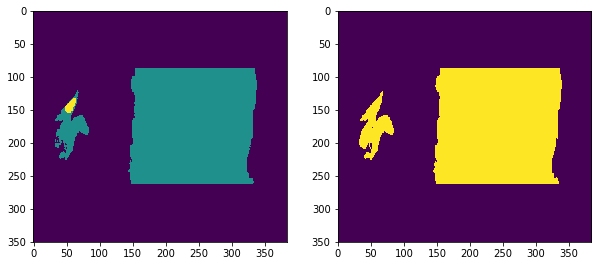

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


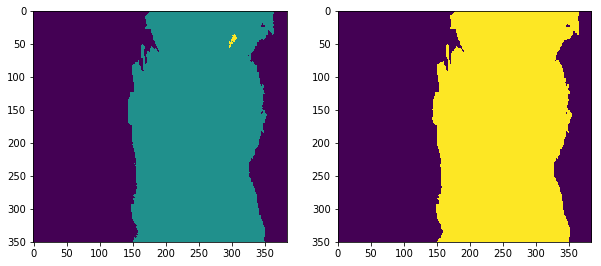

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 87, Metal: 0, Groups total: 1.0


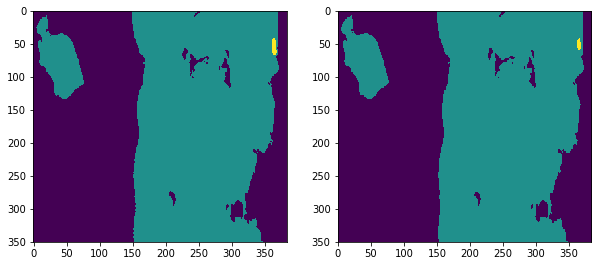

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 96, Metal: 0, Groups total: 1.0


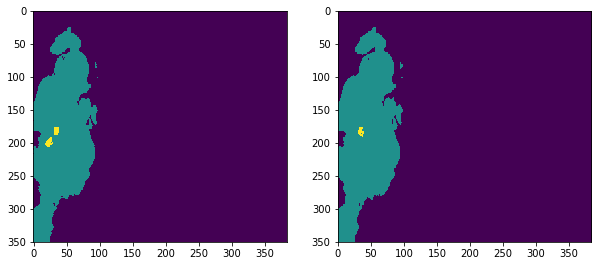

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


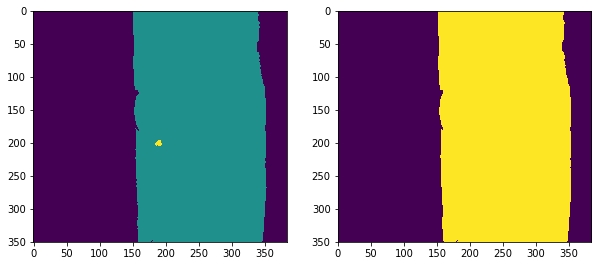

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 322, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 258, Metal: 0, Groups total: 2.0


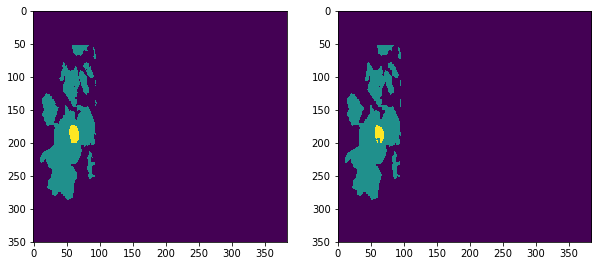

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 157, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


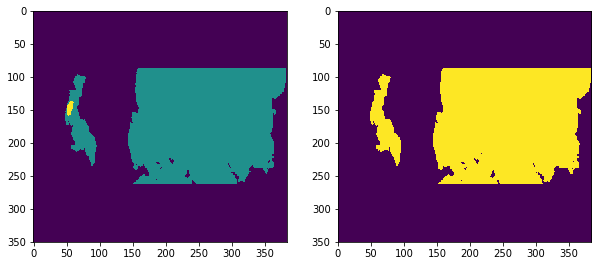

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 52, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


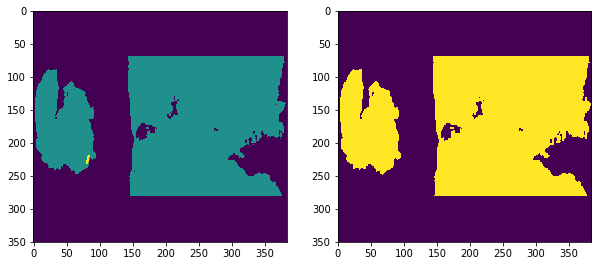

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 93, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 48, Metal: 0, Groups total: 2.0


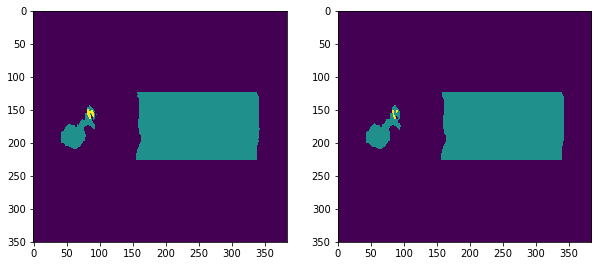

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 330, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 89, Metal: 0, Groups total: 3.0


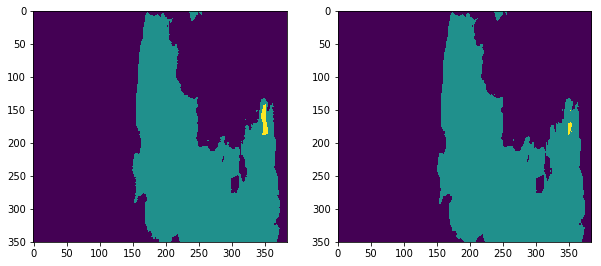

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 24, Metal: 0, Groups total: 1.0


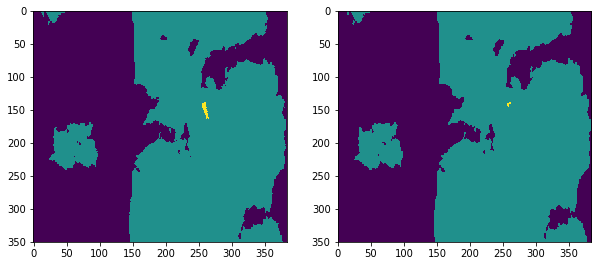

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 190, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 458, Metal: 0, Groups total: 4.0


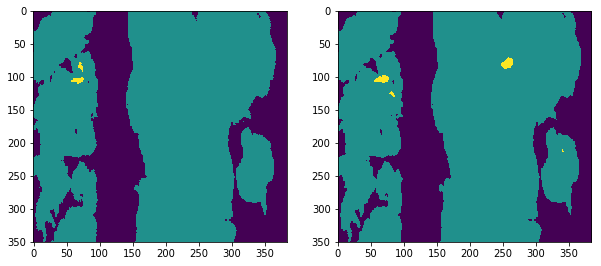

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 51, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 165, Metal: 0, Groups total: 1.0


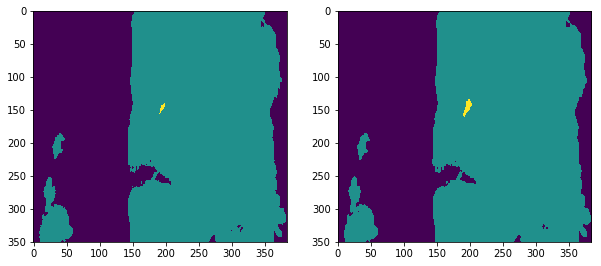

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 132, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 147, Metal: 0, Groups total: 1.0


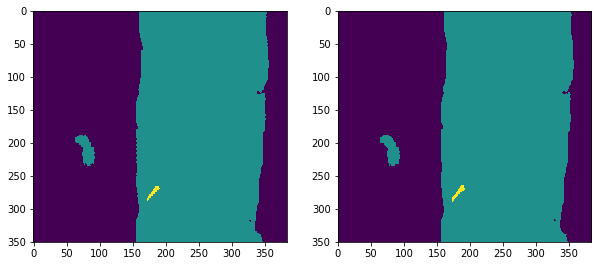

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 107, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 148, Metal: 0, Groups total: 1.0


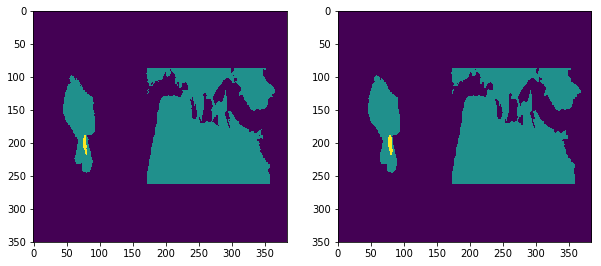

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 321, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 5, Metal: 0, Groups total: 2.0


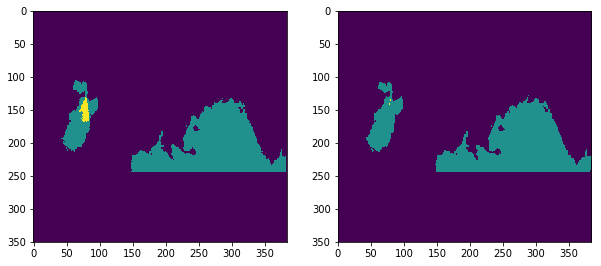

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 217, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 245, Metal: 0, Groups total: 1.0


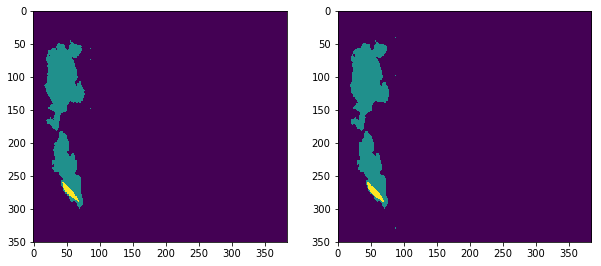

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 89, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 76, Metal: 0, Groups total: 1.0


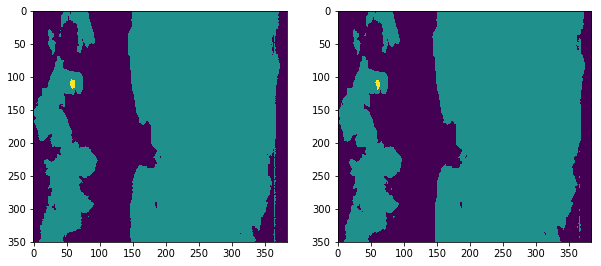

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


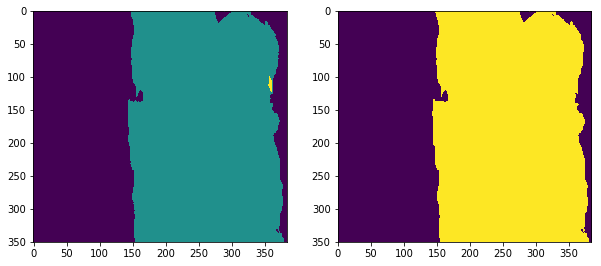

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 75, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


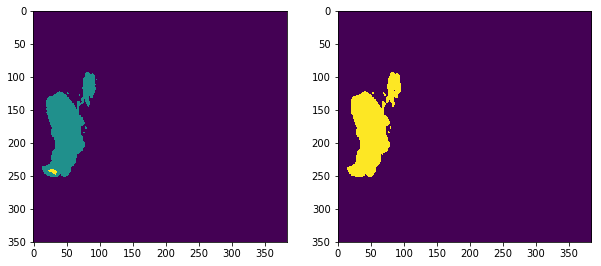

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 199, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


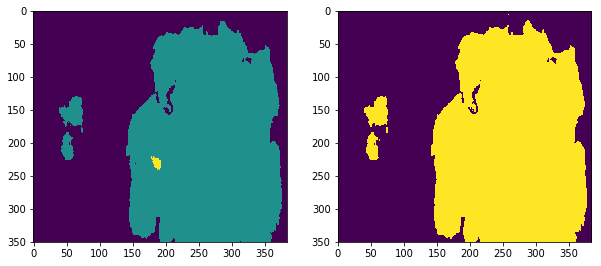

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 80, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 1.0


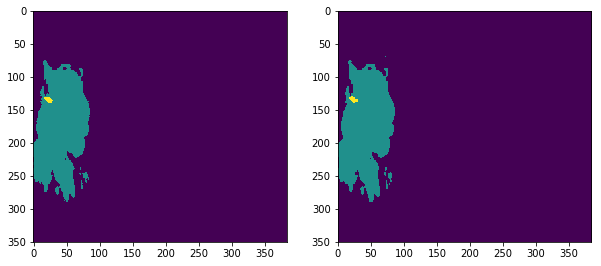

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 186, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 95, Metal: 0, Groups total: 1.0


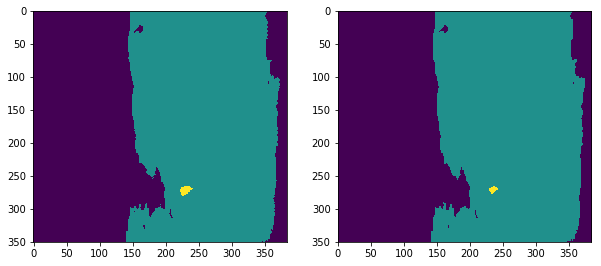

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 31, Metal: 0, Groups total: 2.0


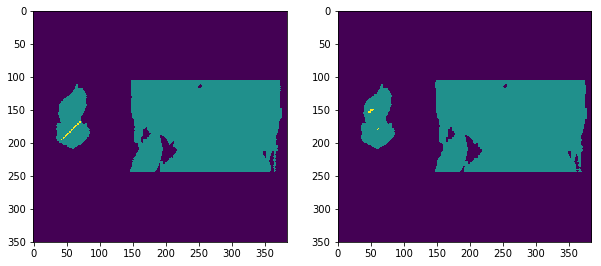

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 676, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 679, Metal: 0, Groups total: 1.0


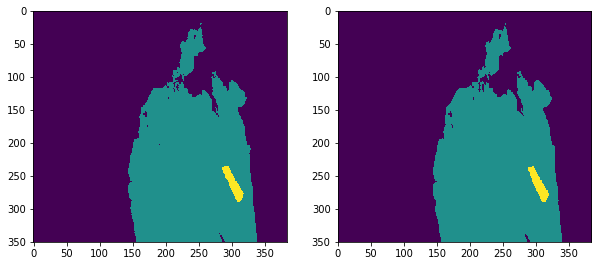

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 349, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 10, Metal: 0, Groups total: 2.0


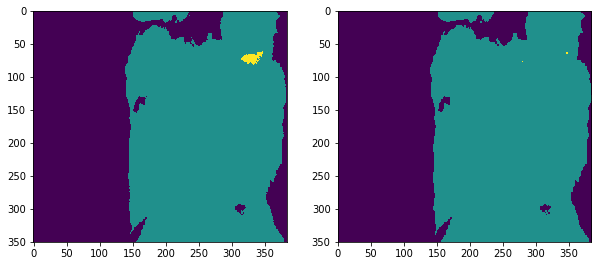

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 897, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1249, Metal: 0, Groups total: 2.0


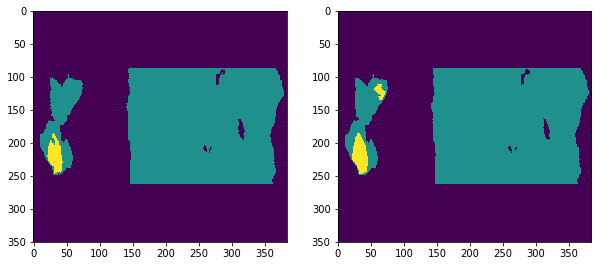

There is Metal / Found Metal
[0 1 3]
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 9, Groups total: 1.0


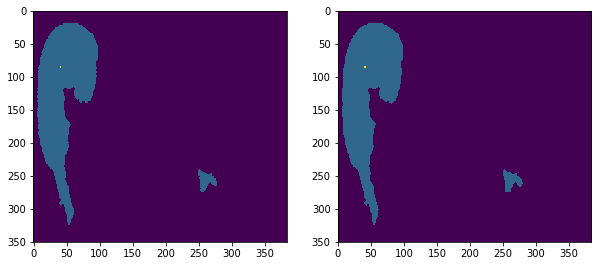

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 292, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 2.0


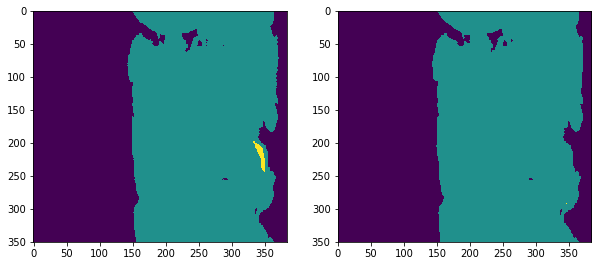

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 187, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 189, Metal: 0, Groups total: 1.0


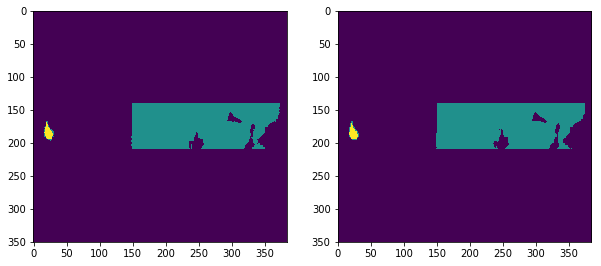

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 741, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 1.0


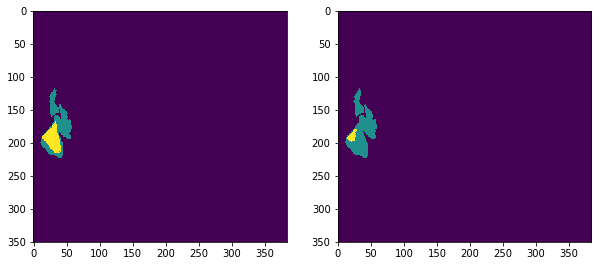

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 76, Metal: 0, Groups total: 1.0


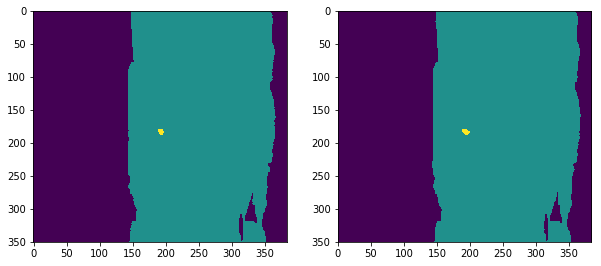

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 127, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 0, Groups total: 1.0


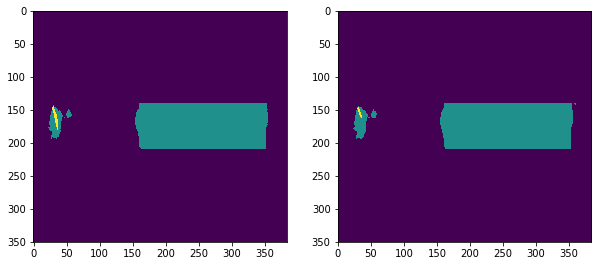

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 56, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 44, Metal: 0, Groups total: 1.0


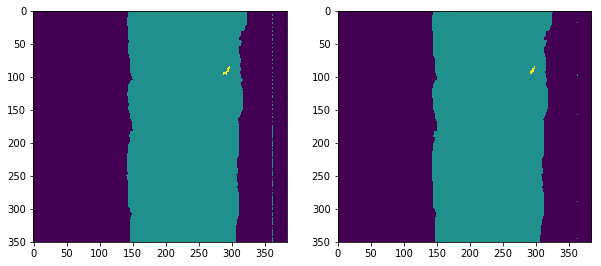

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


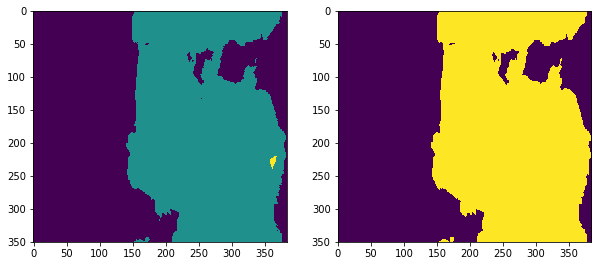

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 261, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


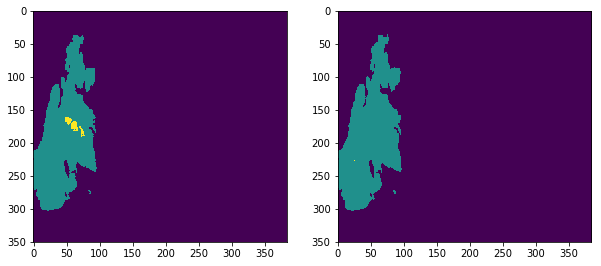

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 221, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


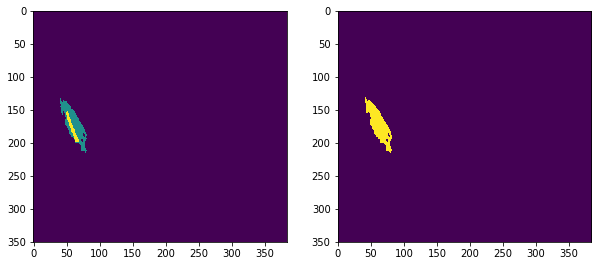

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 100, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 1.0


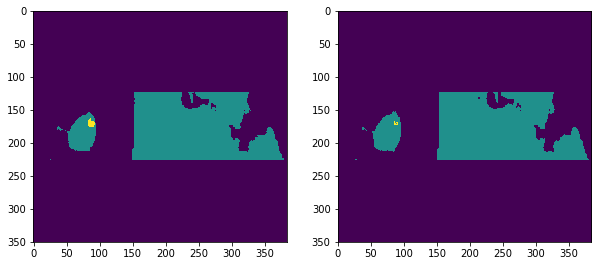

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 99, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


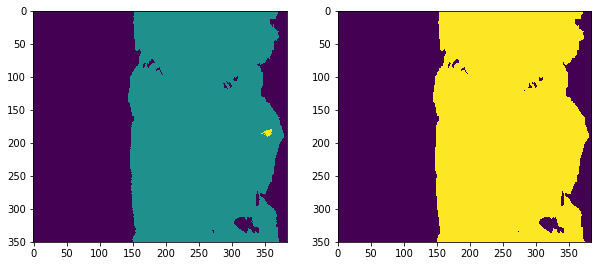

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


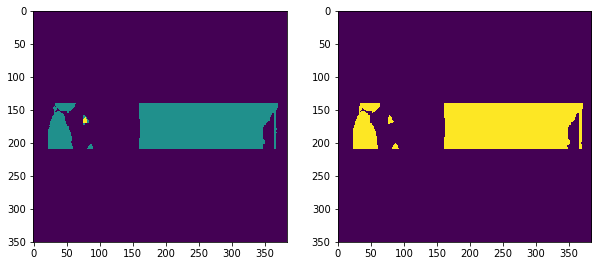

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 760, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 72, Metal: 0, Groups total: 4.0


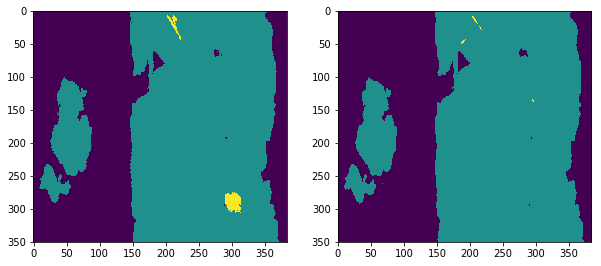

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 23, Metal: 0, Groups total: 1.0


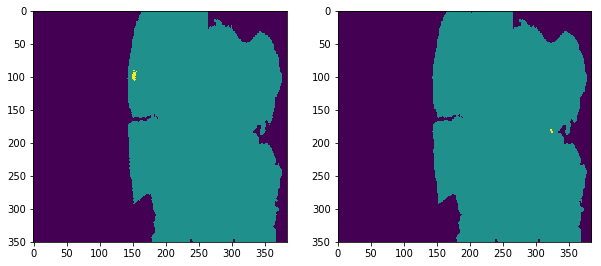

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 197, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


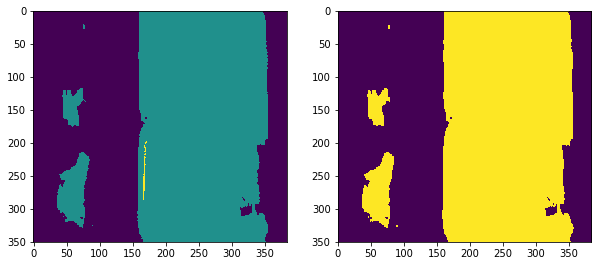

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 314, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 123, Metal: 0, Groups total: 1.0


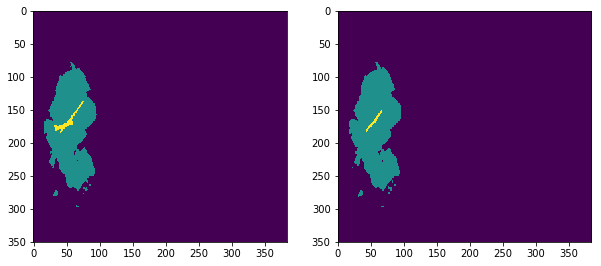

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 260, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 309, Metal: 0, Groups total: 1.0


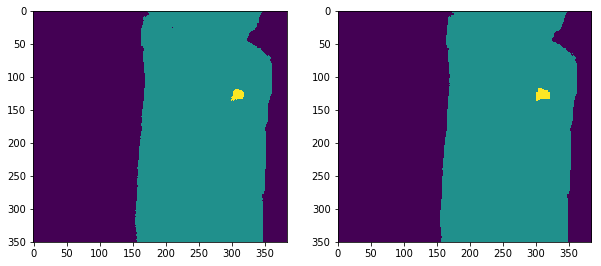

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 204, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


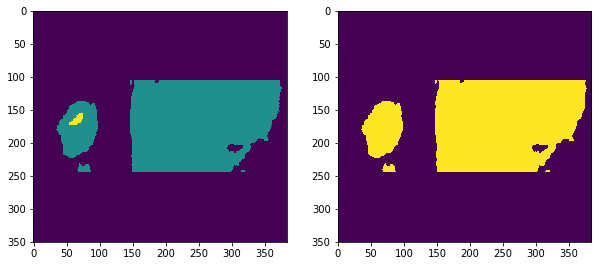

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 59, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 173, Metal: 0, Groups total: 2.0


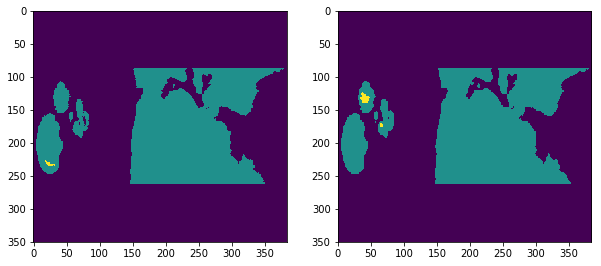

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 138, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 118, Metal: 0, Groups total: 1.0


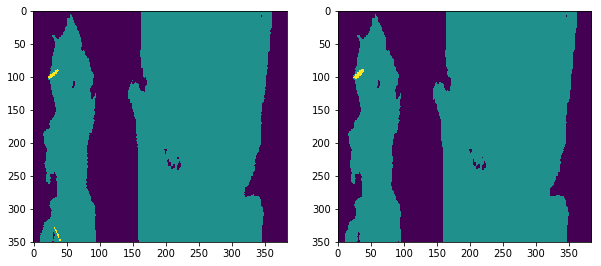

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 235, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 228, Metal: 0, Groups total: 3.0


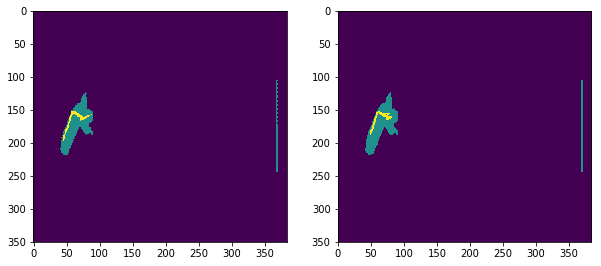

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1083, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 769, Metal: 0, Groups total: 4.0


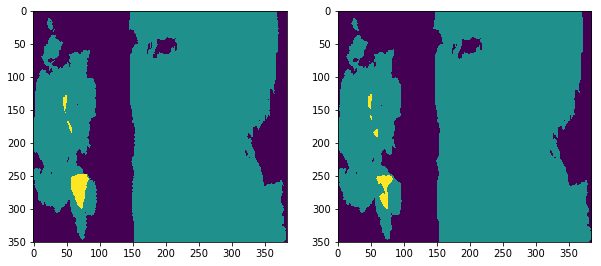

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 602, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 192, Metal: 0, Groups total: 1.0


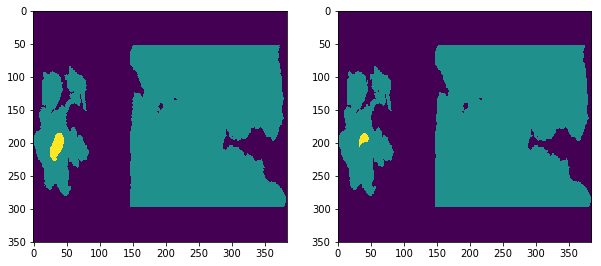

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 821, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 881, Metal: 0, Groups total: 2.0


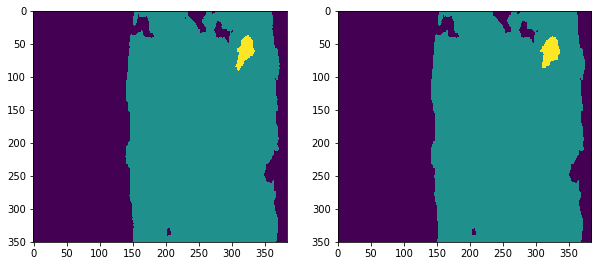

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 199, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 141, Metal: 0, Groups total: 2.0


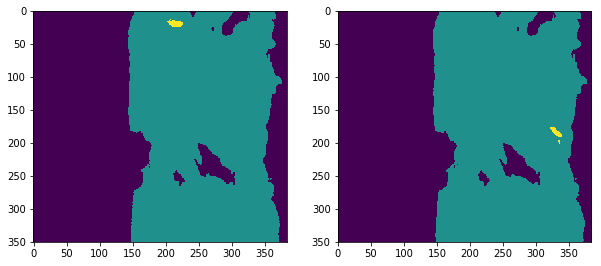

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 131, Metal: 0, Groups total: 1.0


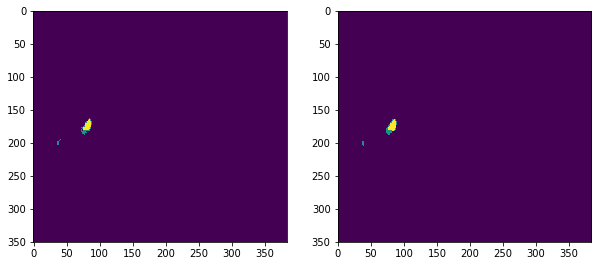

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


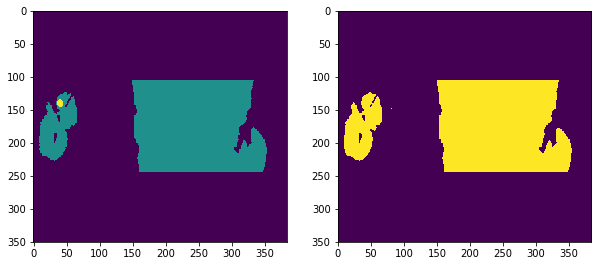

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


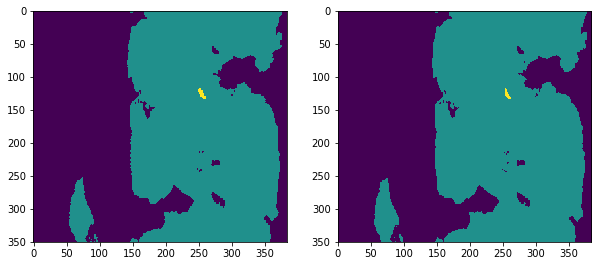

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 108, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


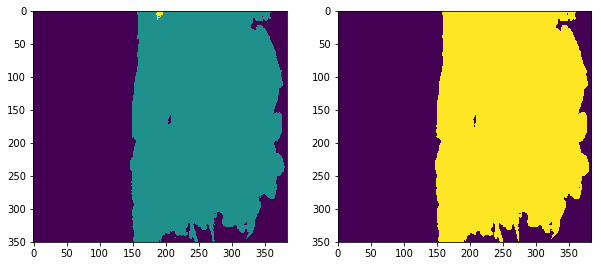

There is Bone / Found Bone and Metal
[0 1 2 3]
Pixel count
Ground truth -> Bone: 66, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 67, Metal: 1, Groups total: 2.0


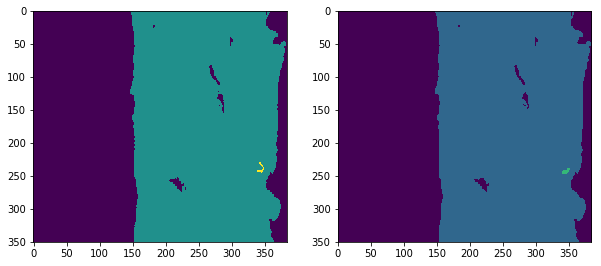

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 304, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


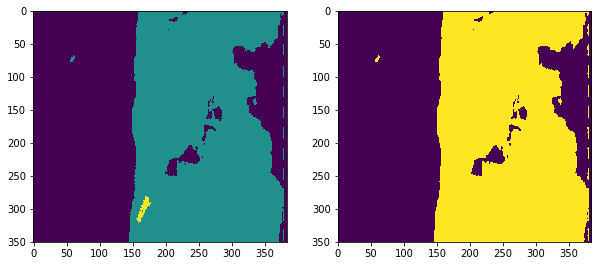

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 470, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 314, Metal: 0, Groups total: 4.0


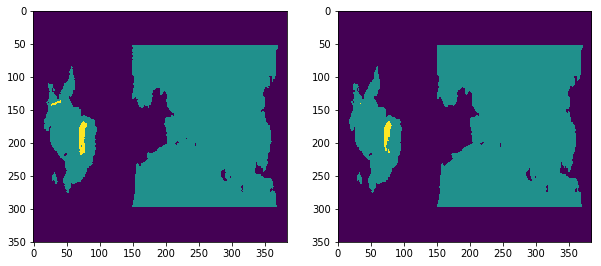

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 367, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 276, Metal: 0, Groups total: 2.0


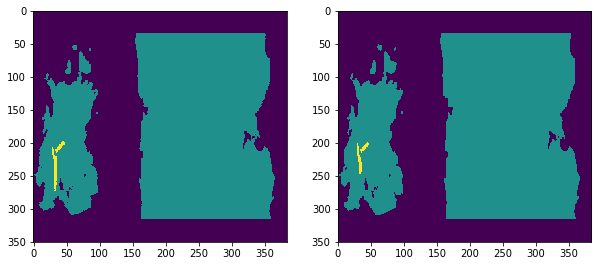

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 56, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 125, Metal: 0, Groups total: 2.0


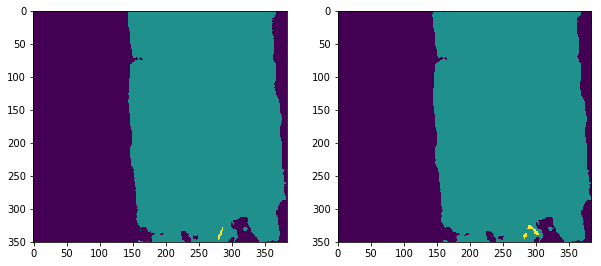

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 247, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 215, Metal: 0, Groups total: 2.0


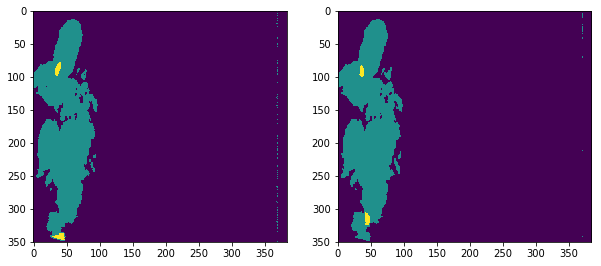

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 399, Metal: 0, Groups total: 4.0


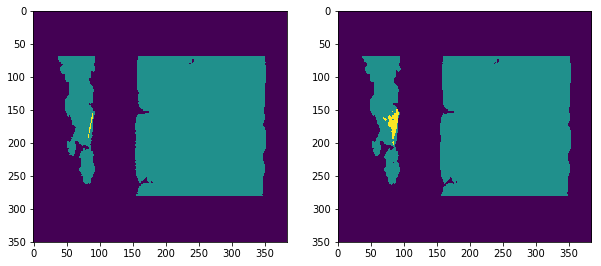

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


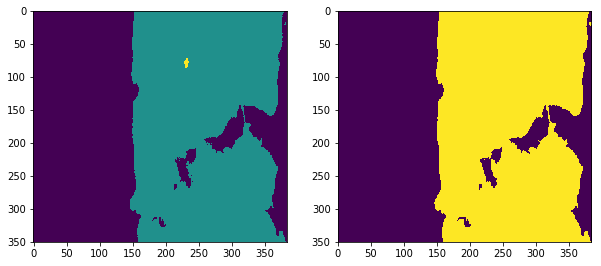

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 338, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 340, Metal: 0, Groups total: 1.0


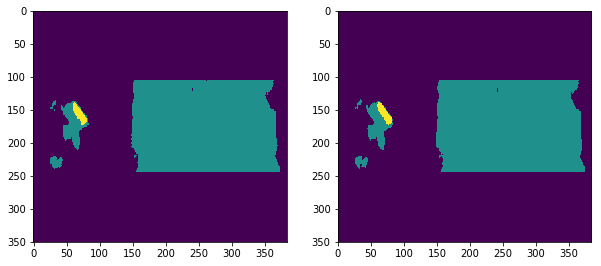

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


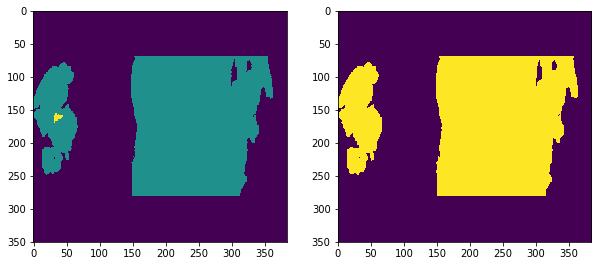

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 115, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


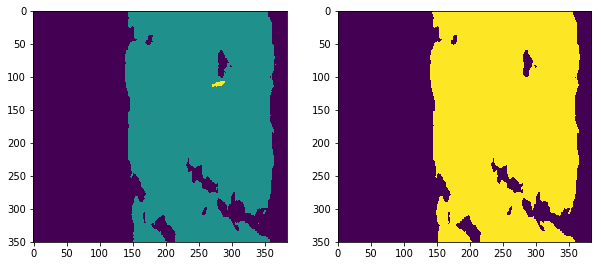

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 178, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 132, Metal: 0, Groups total: 2.0


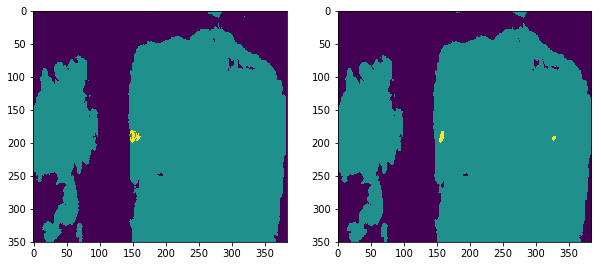

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


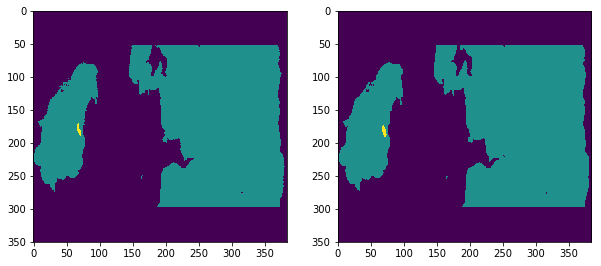

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 60, Metal: 0, Groups total: 2.0


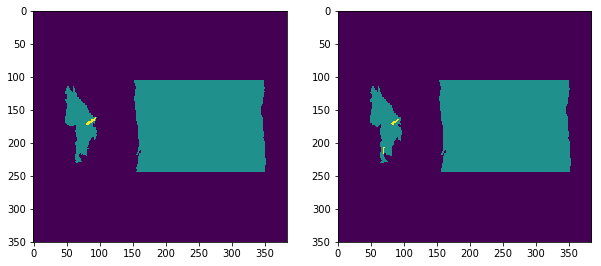

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 157, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 45, Metal: 0, Groups total: 2.0


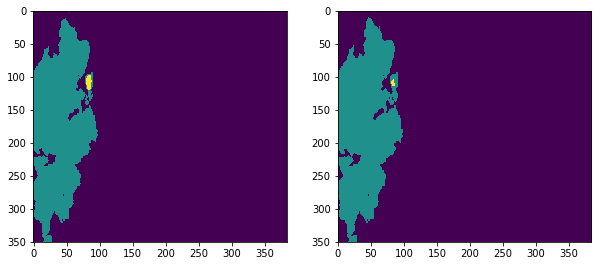

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 260, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 251, Metal: 0, Groups total: 1.0


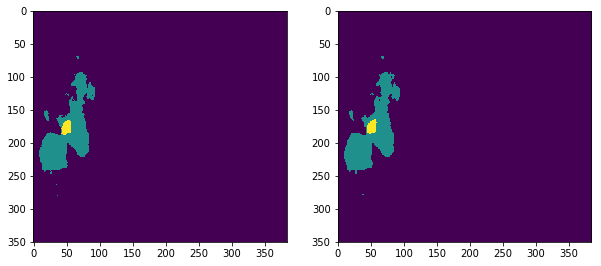

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 181, Metal: 0, Groups total: 2.0


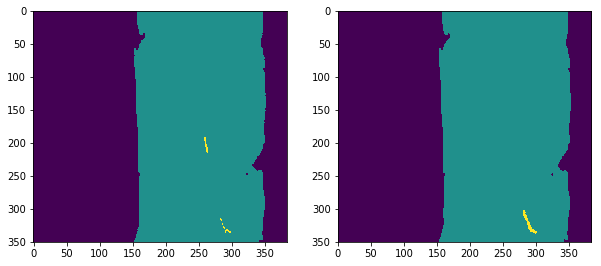

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 107, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


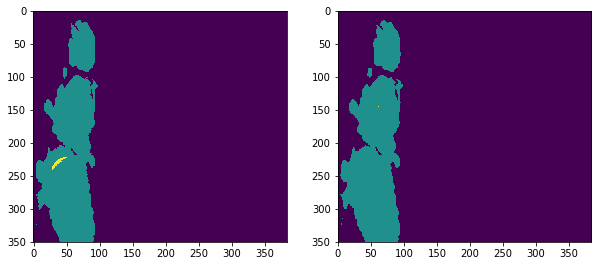

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


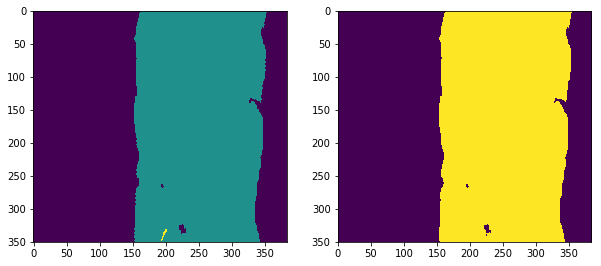

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 277, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 219, Metal: 0, Groups total: 1.0


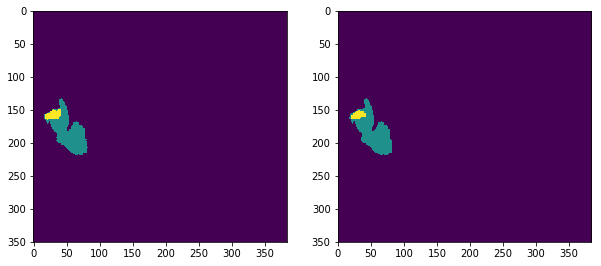

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 292, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


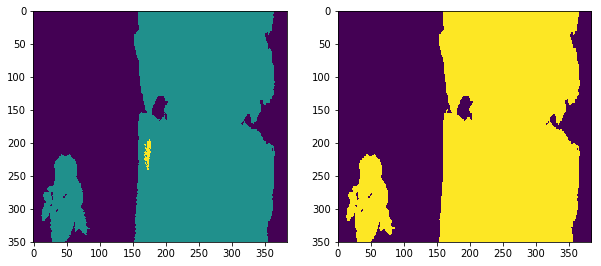

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


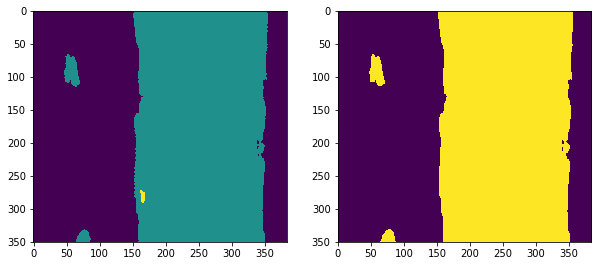

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 363, Metal: 0, Groups total: 4.0


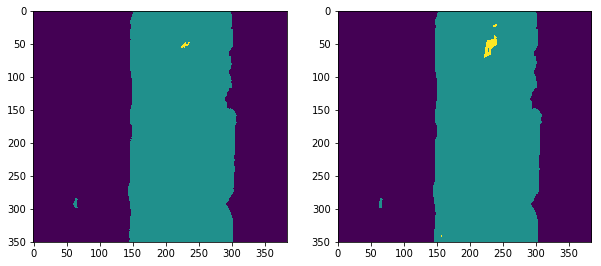

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 112, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 135, Metal: 0, Groups total: 3.0


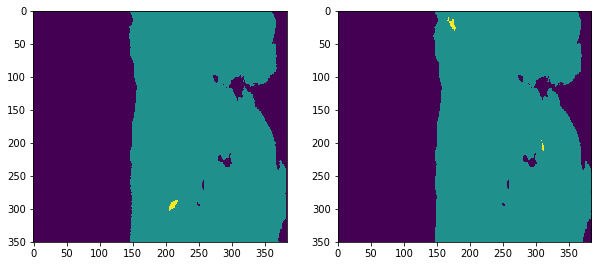

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


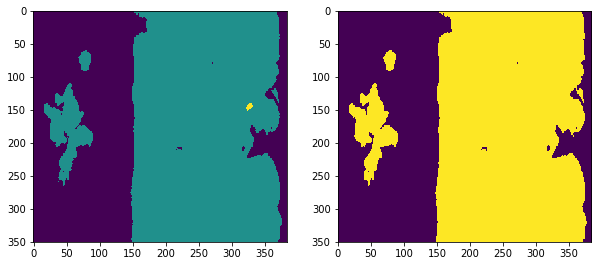

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 67, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


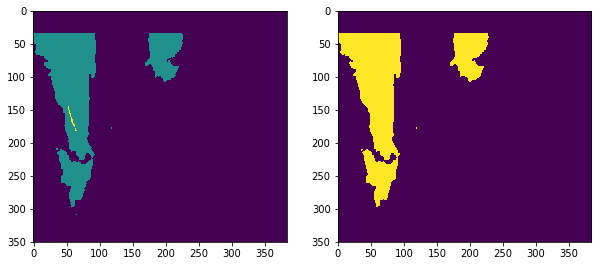

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 981, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 586, Metal: 0, Groups total: 1.0


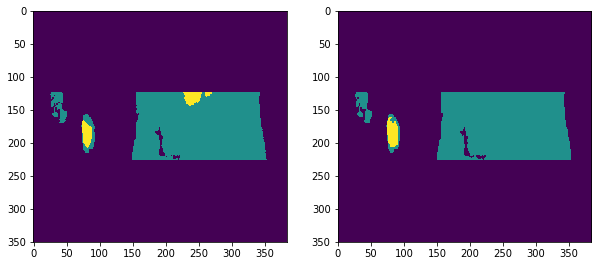

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 41, Metal: 0, Groups total: 1.0


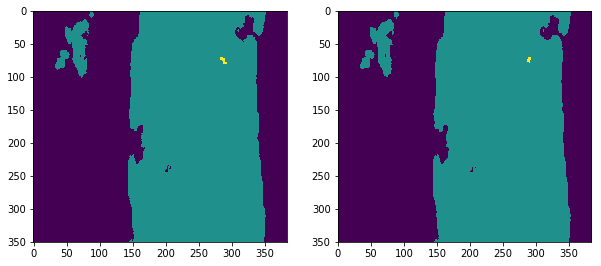

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 124, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 1.0


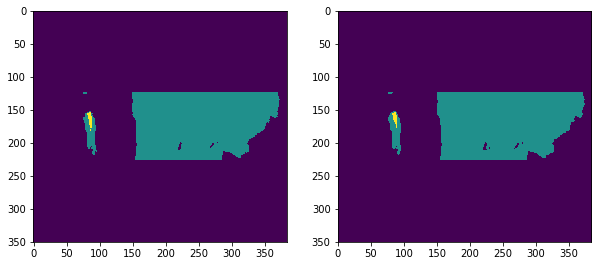

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 199, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 288, Metal: 0, Groups total: 1.0


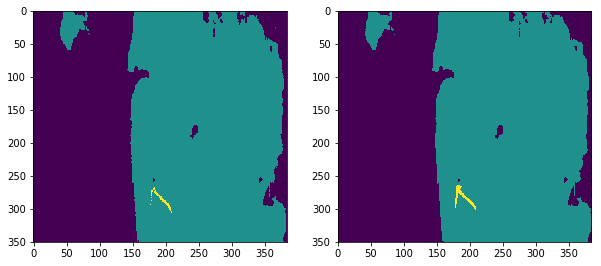

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


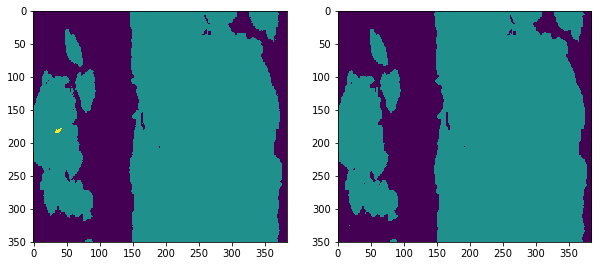

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 20, Metal: 0, Groups total: 1.0


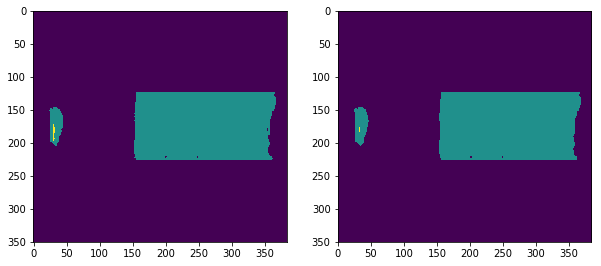

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


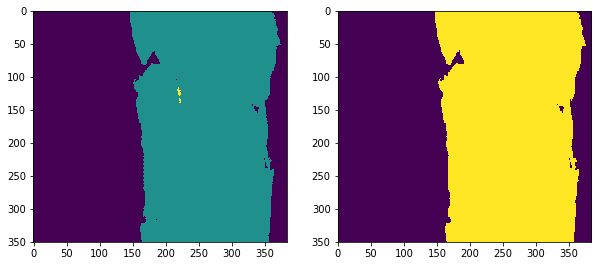

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 275, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 89, Metal: 0, Groups total: 3.0


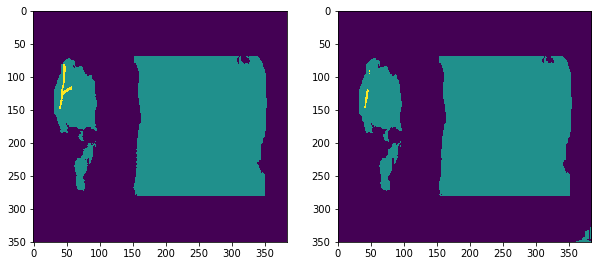

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 63, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 119, Metal: 0, Groups total: 2.0


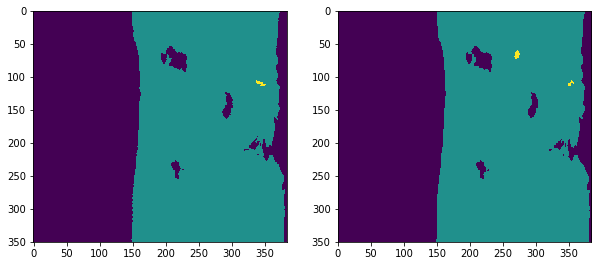

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


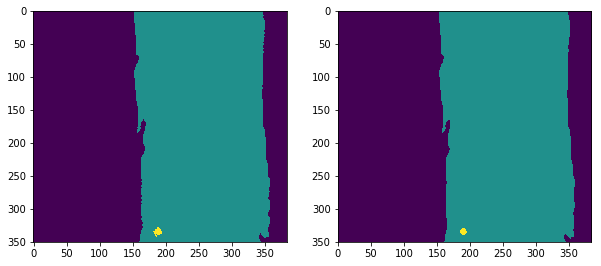

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 141, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 146, Metal: 0, Groups total: 1.0


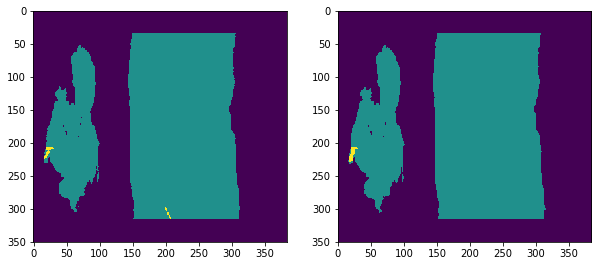

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 158, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


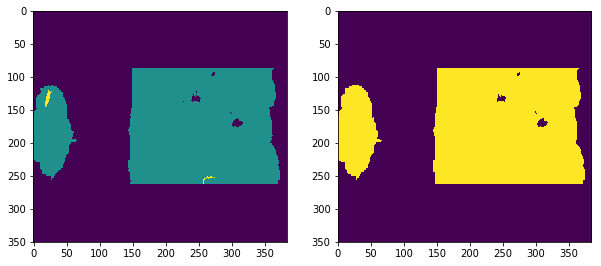

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 130, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 33, Metal: 0, Groups total: 1.0


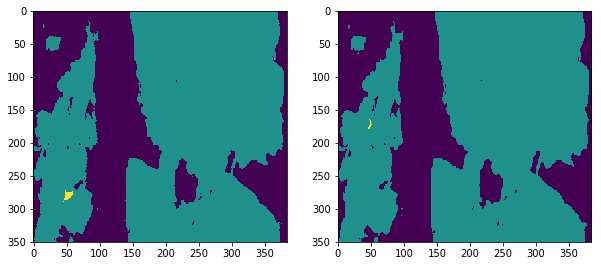

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 207, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 167, Metal: 0, Groups total: 1.0


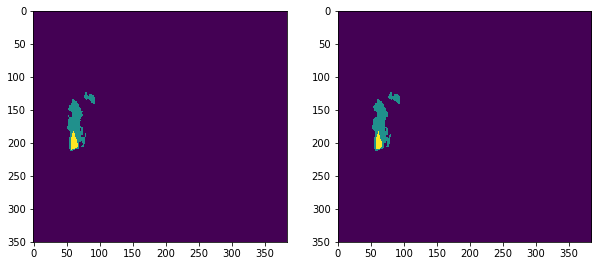

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1071, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 108, Metal: 0, Groups total: 1.0


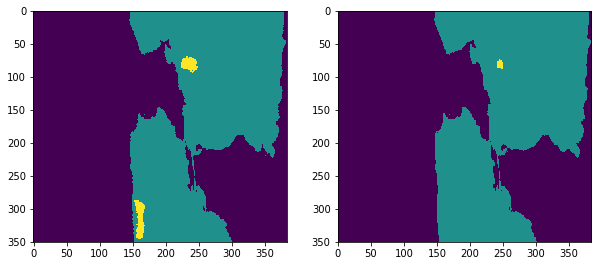

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


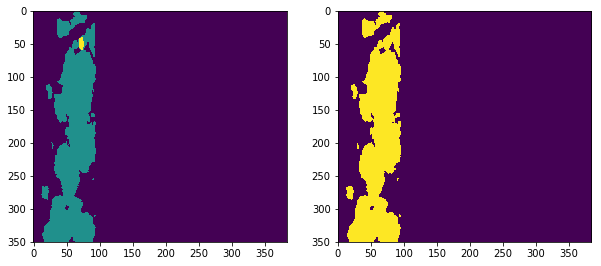

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 65, Metal: 0, Groups total: 1.0


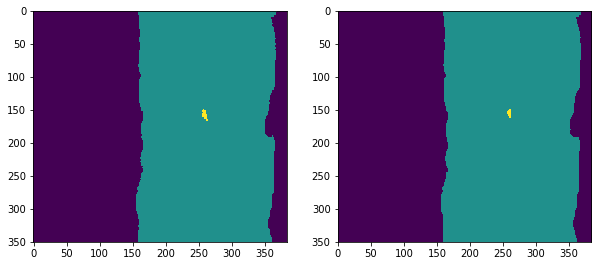

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 176, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 2.0


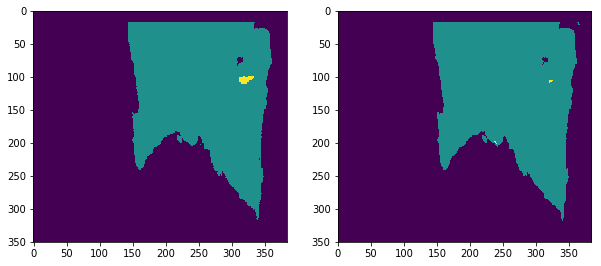

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 177, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 4, Metal: 0, Groups total: 1.0


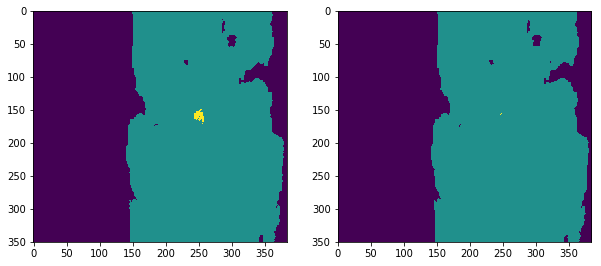

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 229, Metal: 0, Groups total: 3.0


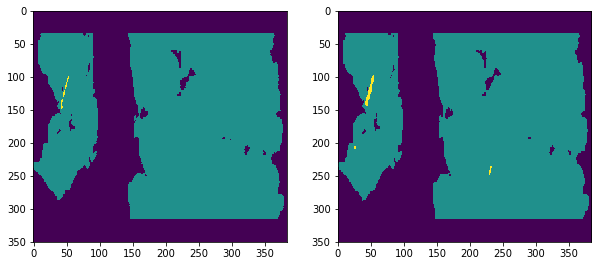

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 64, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 124, Metal: 0, Groups total: 2.0


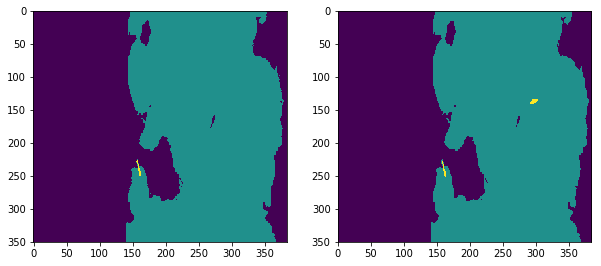

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 87, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 2.0


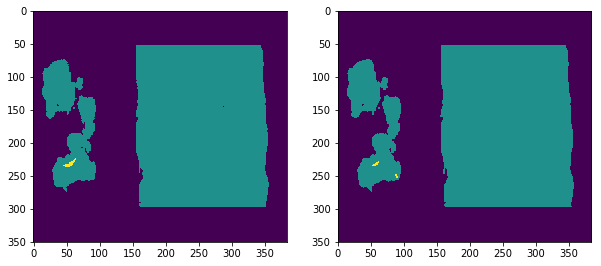

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 121, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 325, Metal: 0, Groups total: 1.0


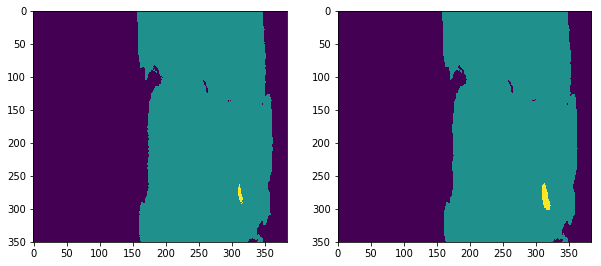

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 119, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


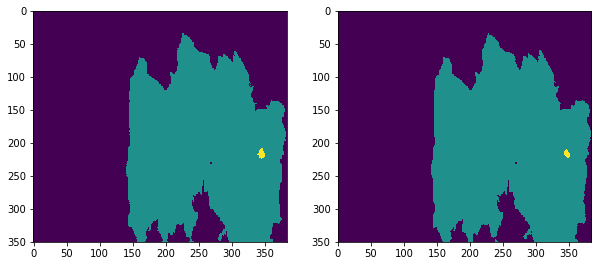

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


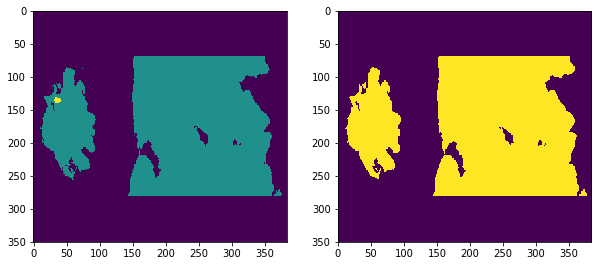

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 254, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 248, Metal: 0, Groups total: 1.0


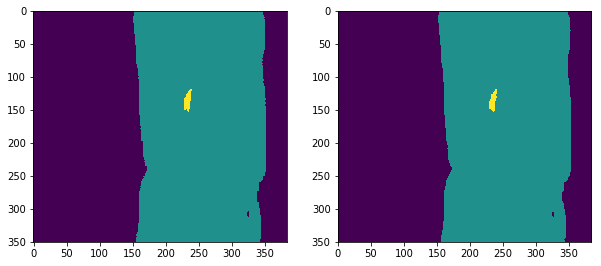

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 13, Metal: 0, Groups total: 1.0


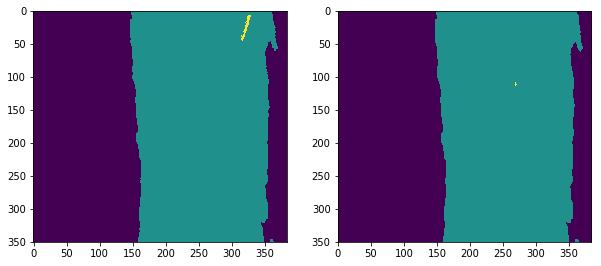

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 73, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


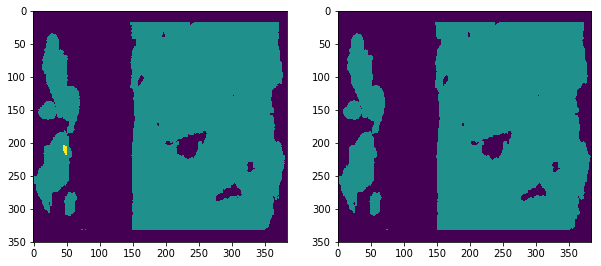

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 81, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 338, Metal: 0, Groups total: 1.0


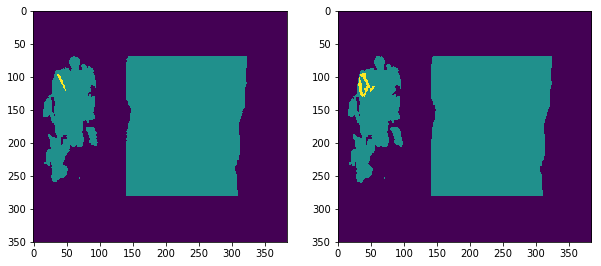

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 81, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 120, Metal: 0, Groups total: 2.0


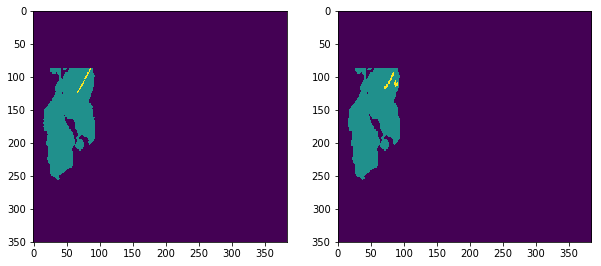

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 491, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 346, Metal: 0, Groups total: 1.0


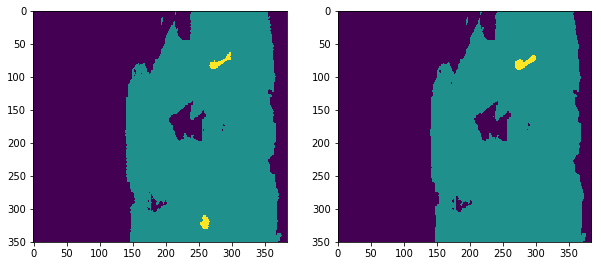

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 67, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


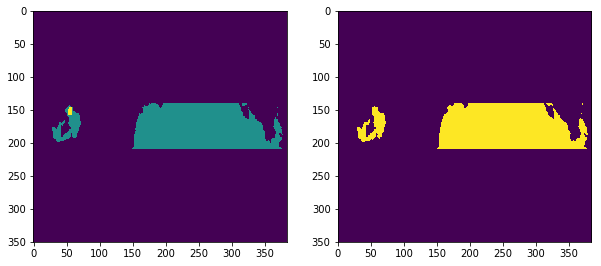

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 78, Metal: 0, Groups total: 2.0


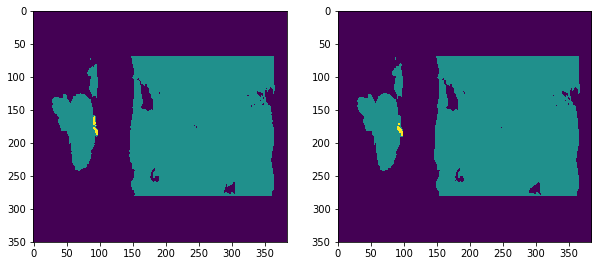

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 142, Metal: 0, Groups total: 1.0


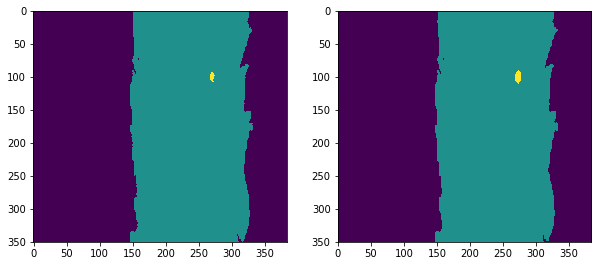

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 141, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 143, Metal: 0, Groups total: 1.0


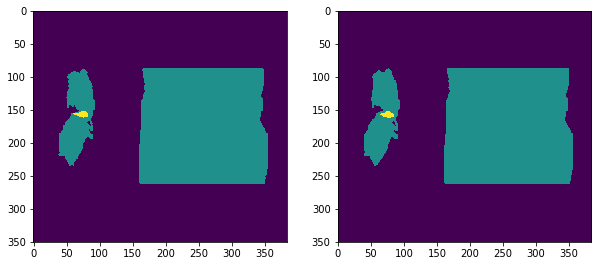

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 145, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 234, Metal: 0, Groups total: 2.0


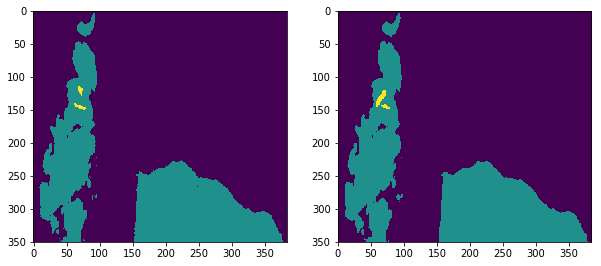

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


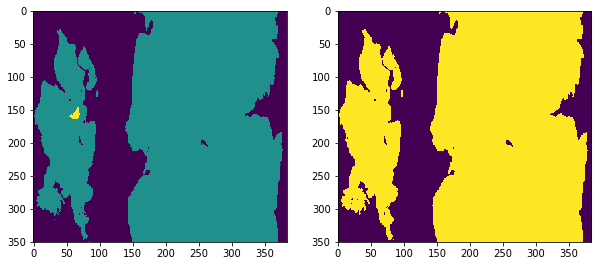

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 498, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 284, Metal: 0, Groups total: 2.0


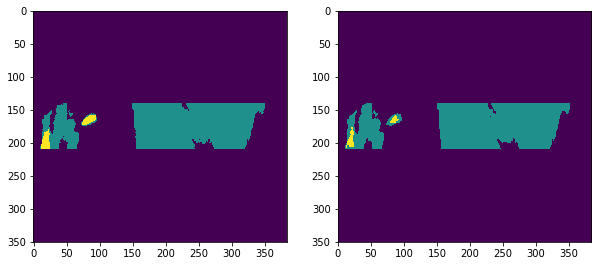

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 142, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


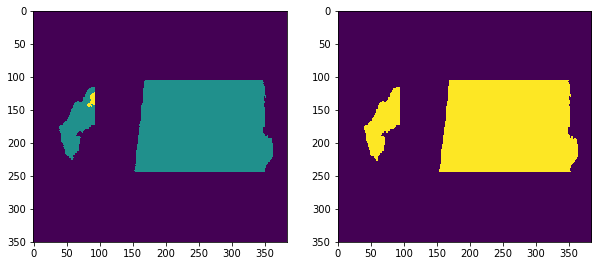

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 676, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 589, Metal: 0, Groups total: 2.0


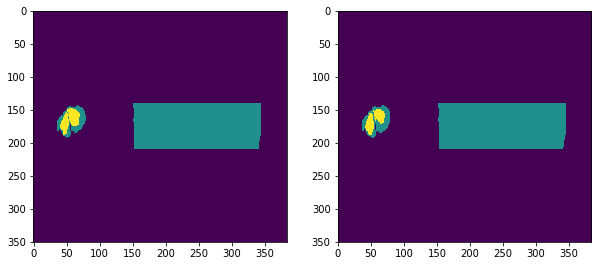

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 305, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 1.0


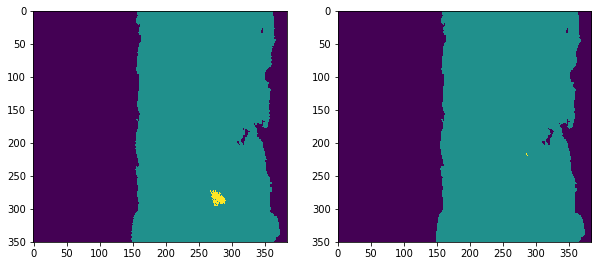

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 223, Metal: 0, Groups total: 6.0


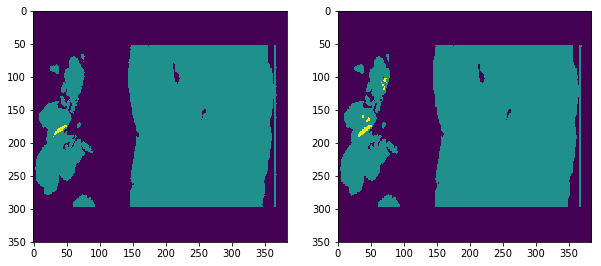

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 107, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


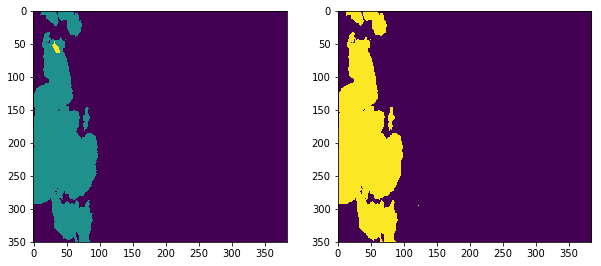

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 111, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 118, Metal: 0, Groups total: 2.0


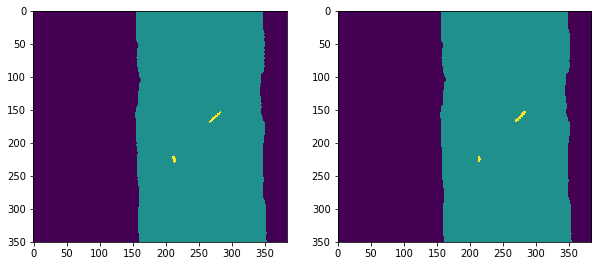

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 348, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


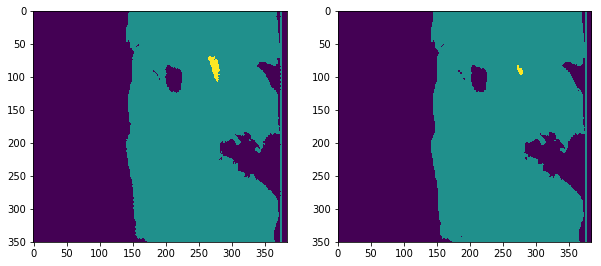

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1181, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 272, Metal: 0, Groups total: 2.0


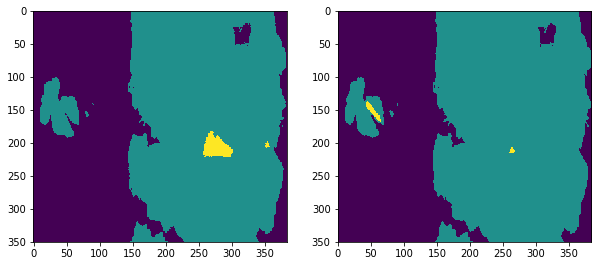

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 144, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 241, Metal: 0, Groups total: 3.0


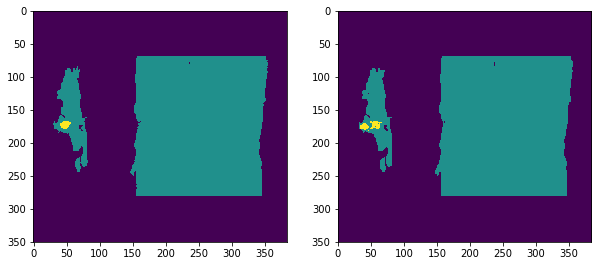

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 140, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 30, Metal: 0, Groups total: 1.0


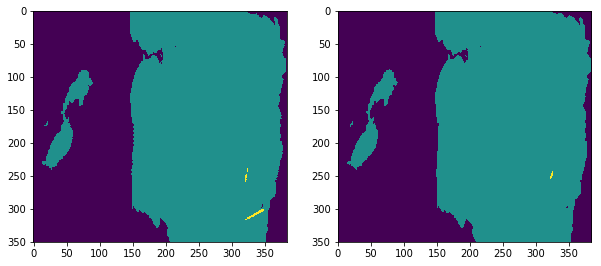

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 1.0


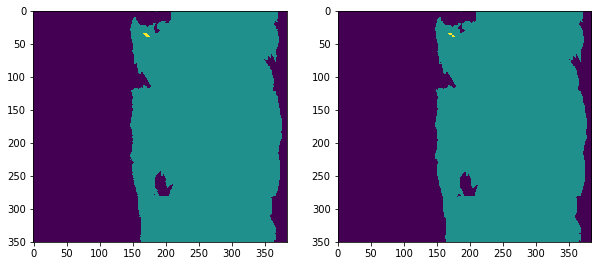

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 229, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 266, Metal: 0, Groups total: 1.0


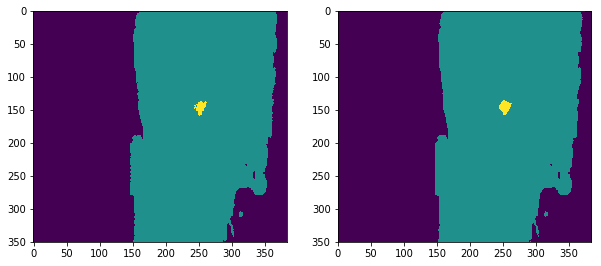

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 316, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 74, Metal: 0, Groups total: 1.0


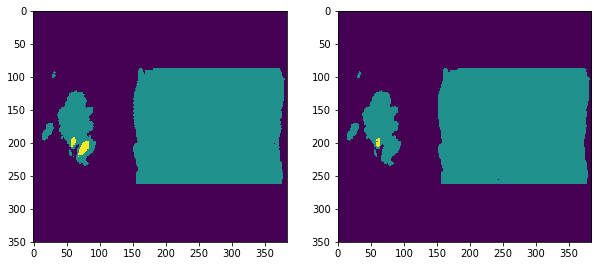

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 80, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 11, Metal: 0, Groups total: 1.0


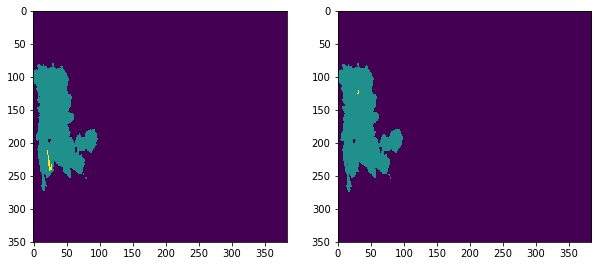

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 163, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 178, Metal: 0, Groups total: 1.0


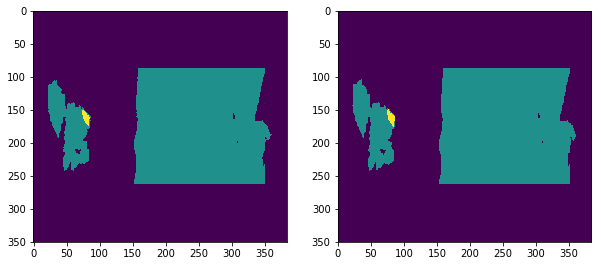

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 172, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 122, Metal: 0, Groups total: 4.0


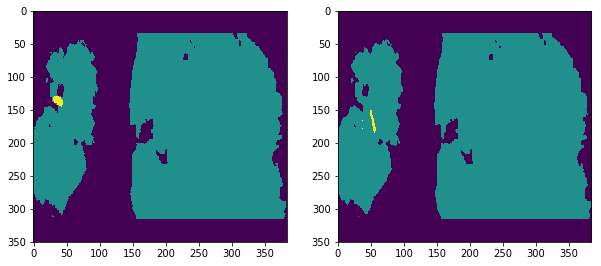

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 99, Metal: 0, Groups total: 1.0


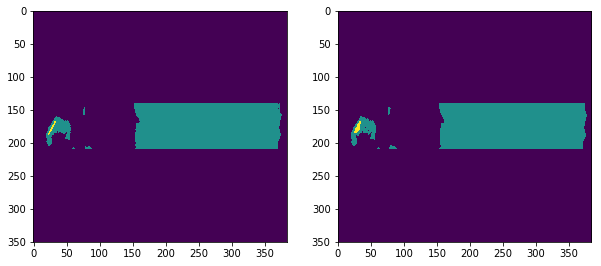

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 405, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 385, Metal: 0, Groups total: 1.0


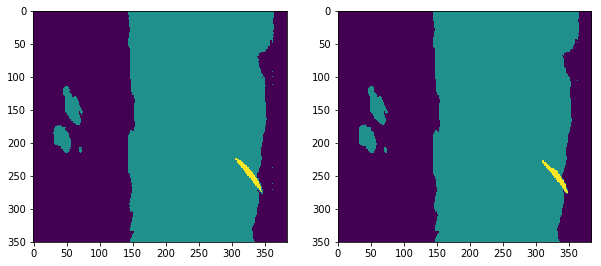

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 187, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 98, Metal: 0, Groups total: 1.0


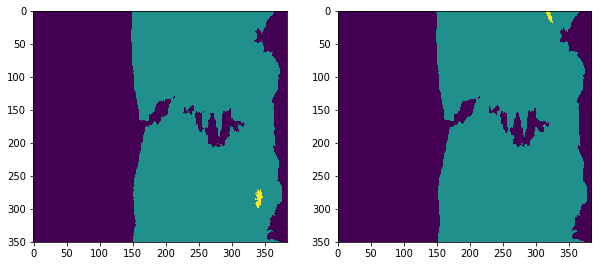

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 480, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 189, Metal: 0, Groups total: 1.0


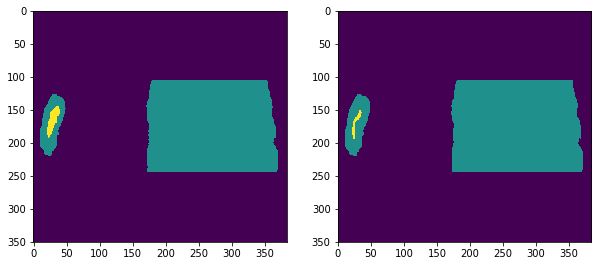

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 800, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 816, Metal: 0, Groups total: 5.0


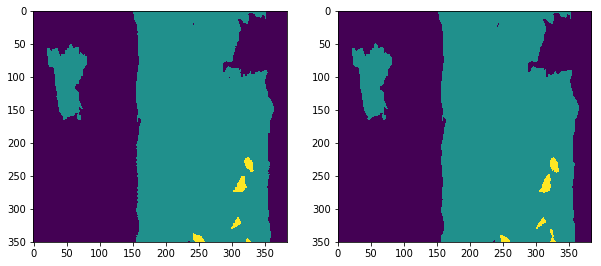

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 208, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 65, Metal: 0, Groups total: 2.0


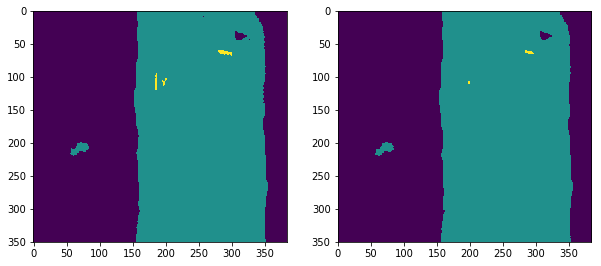

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 61, Metal: 0, Groups total: 1.0


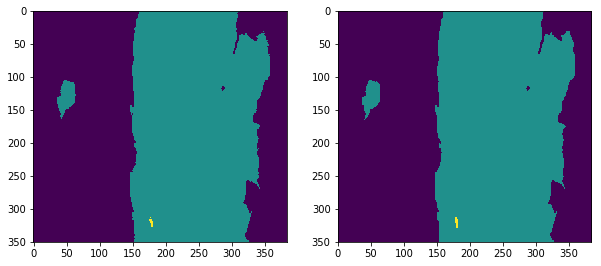

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 258, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 596, Metal: 0, Groups total: 2.0


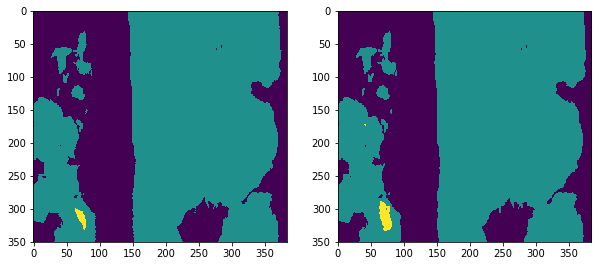

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 195, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 121, Metal: 0, Groups total: 2.0


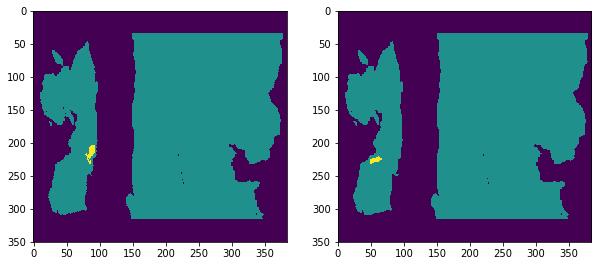

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 197, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 229, Metal: 0, Groups total: 1.0


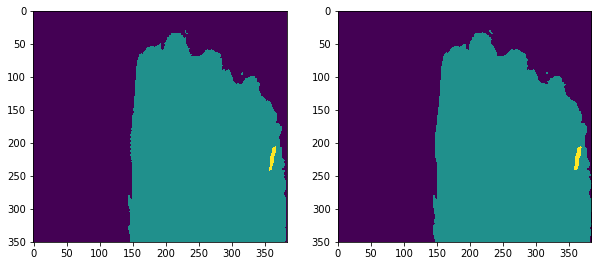

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 125, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 82, Metal: 0, Groups total: 1.0


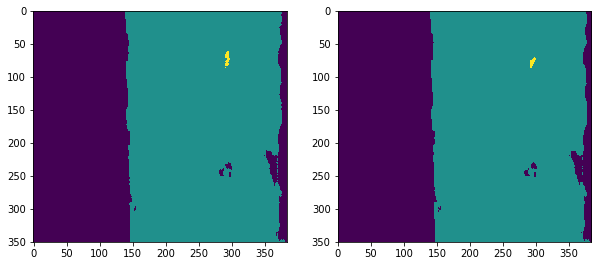

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 160, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 146, Metal: 0, Groups total: 1.0


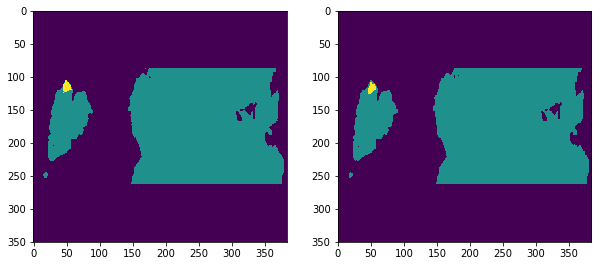

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


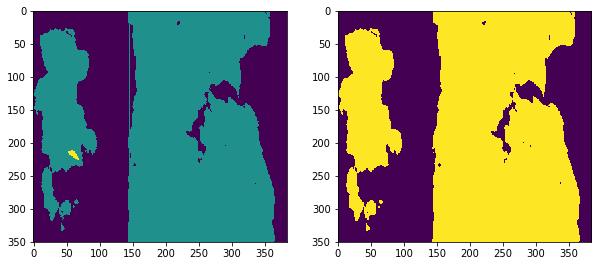

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 1014, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


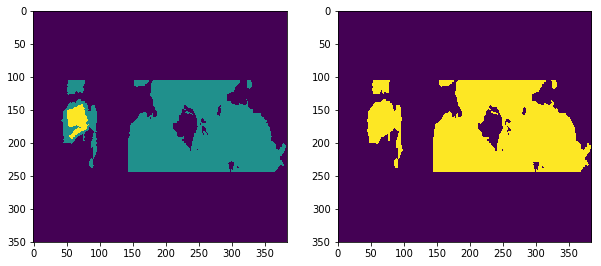

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 72, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 114, Metal: 0, Groups total: 5.0


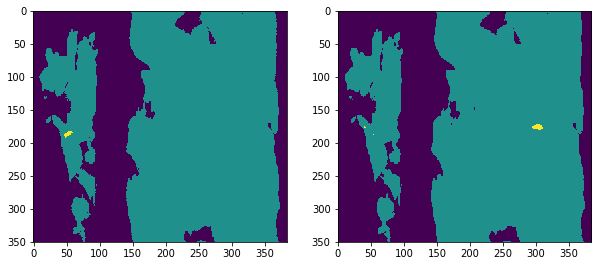

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 282, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 98, Metal: 0, Groups total: 3.0


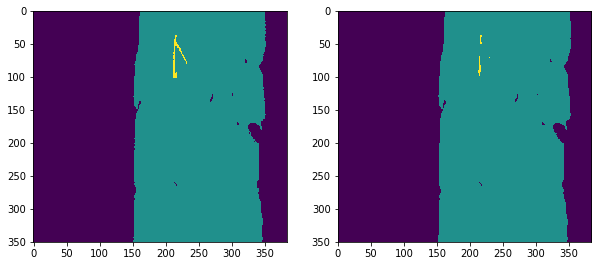

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 13, Metal: 0, Groups total: 1.0


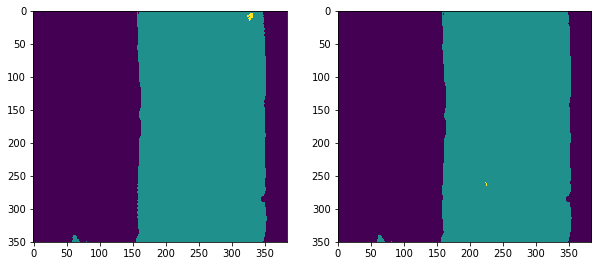

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 238, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 235, Metal: 0, Groups total: 3.0


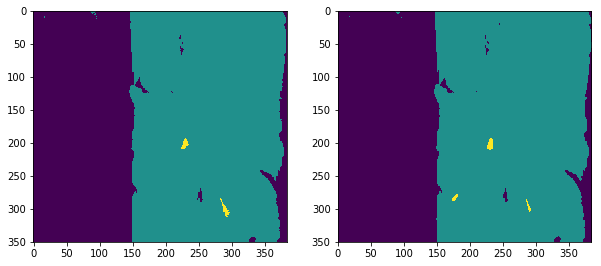

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 215, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 220, Metal: 0, Groups total: 4.0


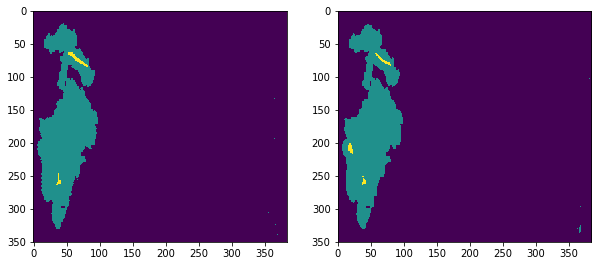

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 1.0


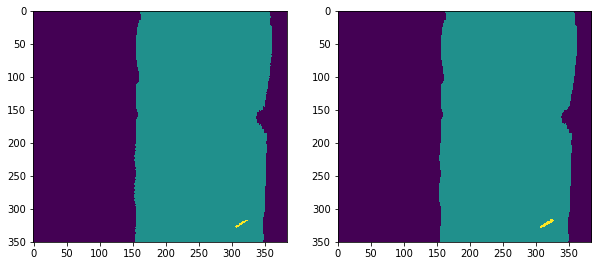

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 153, Metal: 0, Groups total: 1.0


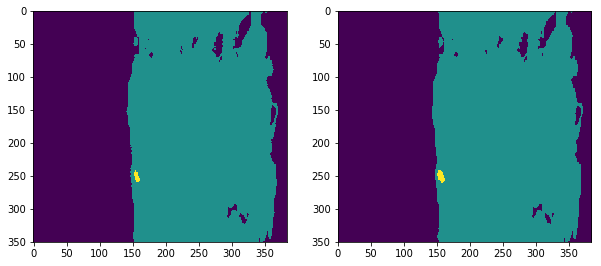

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 53, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


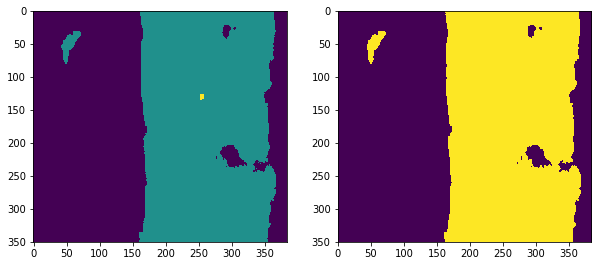

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 151, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


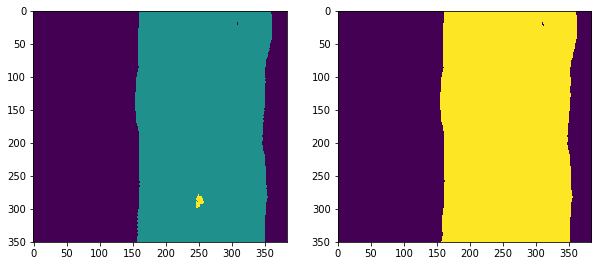

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 210, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 249, Metal: 0, Groups total: 2.0


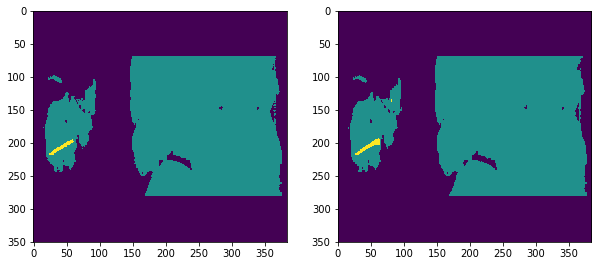

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 185, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


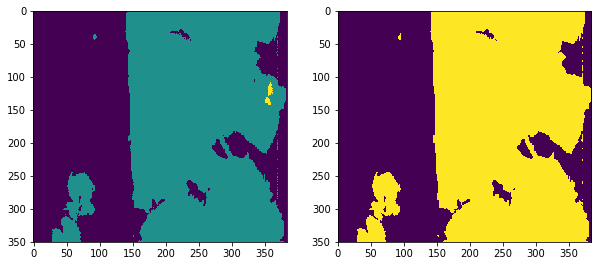

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 272, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 175, Metal: 0, Groups total: 1.0


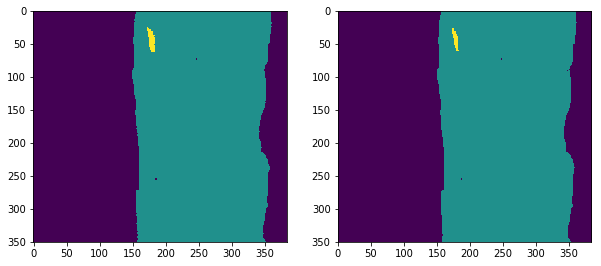

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 98, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 121, Metal: 0, Groups total: 3.0


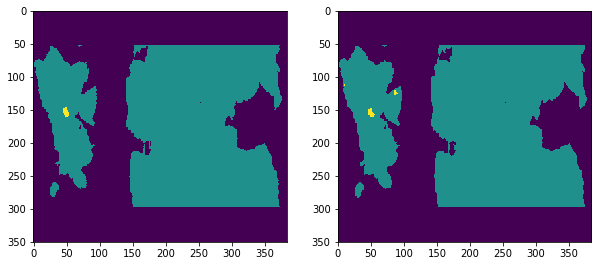

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 157, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 101, Metal: 0, Groups total: 1.0


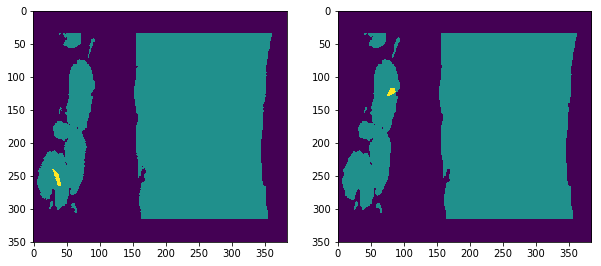

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 423, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 268, Metal: 0, Groups total: 2.0


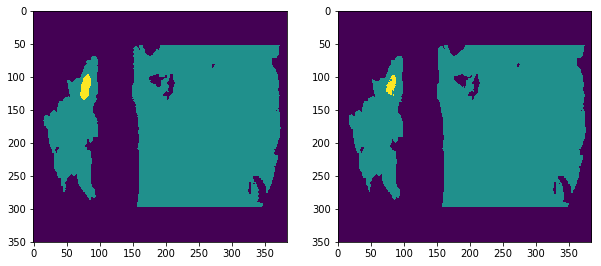

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


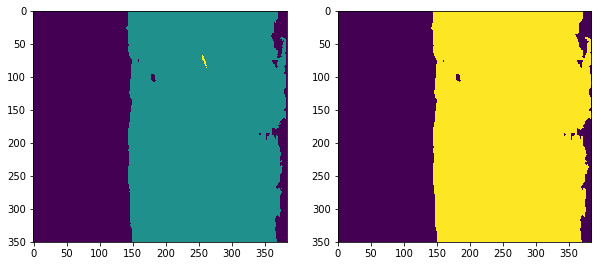

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 261, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 51, Metal: 0, Groups total: 2.0


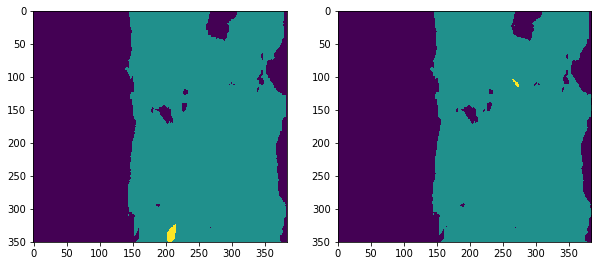

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 307, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 93, Metal: 0, Groups total: 3.0


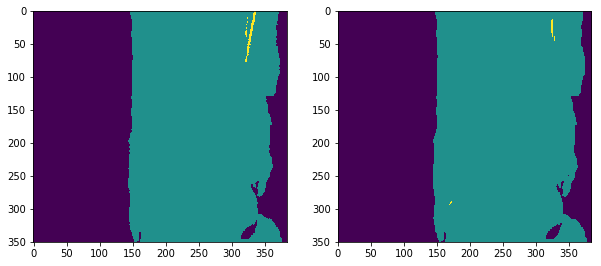

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 143, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 169, Metal: 0, Groups total: 2.0


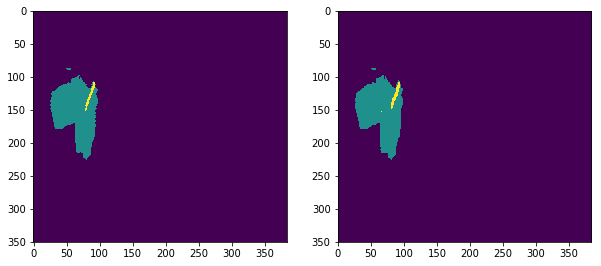

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


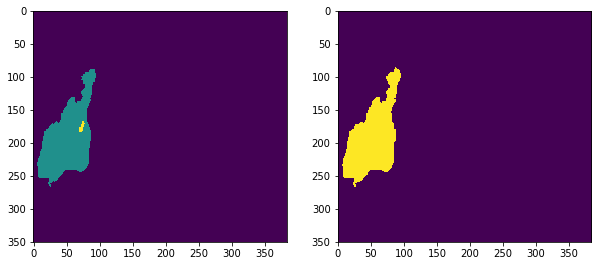

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 91, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 2.0


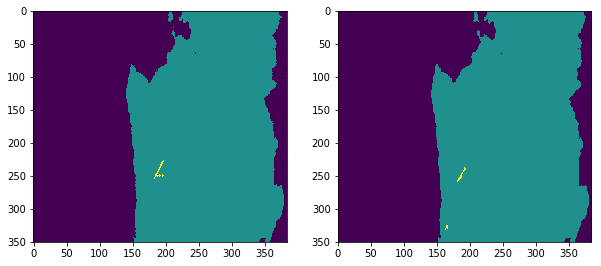

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 121, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


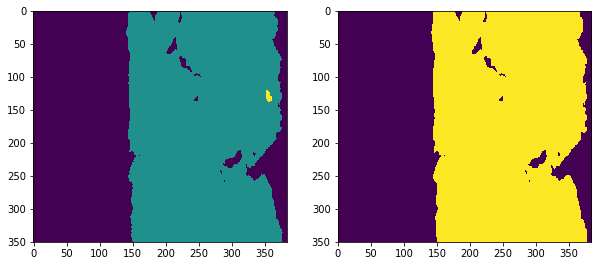

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 2065, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 1047, Metal: 0, Groups total: 3.0


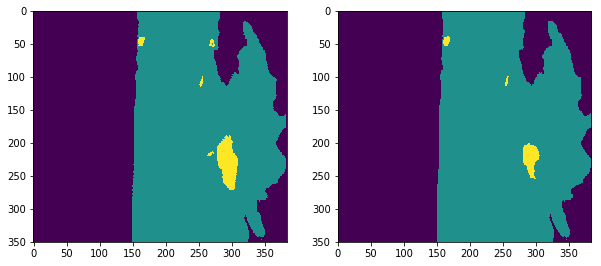

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 3, Metal: 0, Groups total: 2.0


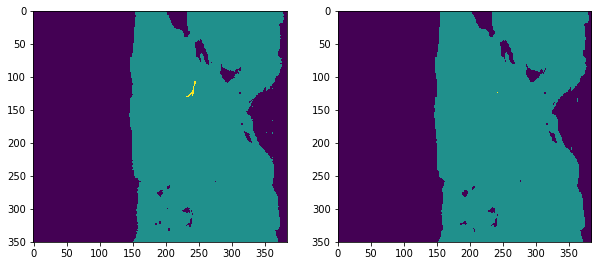

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 852, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 450, Metal: 0, Groups total: 1.0


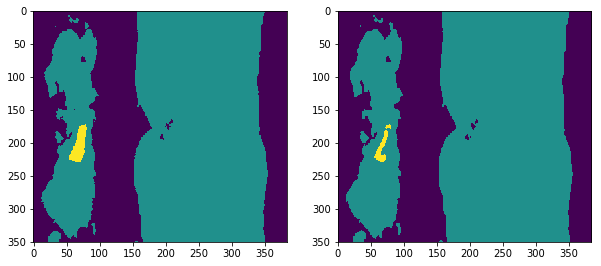

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 398, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 445, Metal: 0, Groups total: 1.0


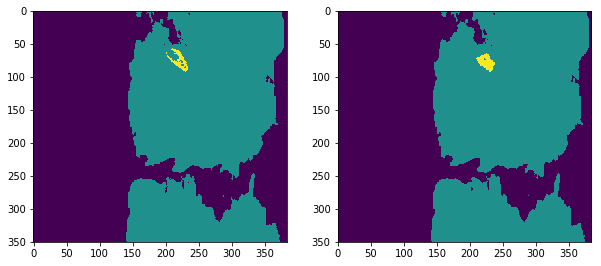

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


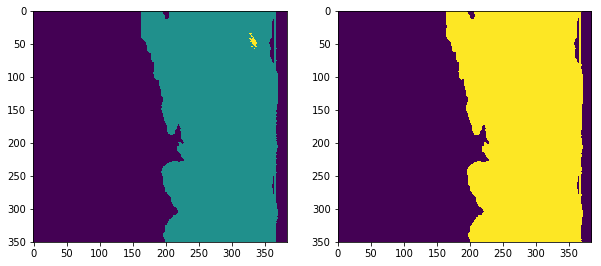

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 313, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 382, Metal: 0, Groups total: 1.0


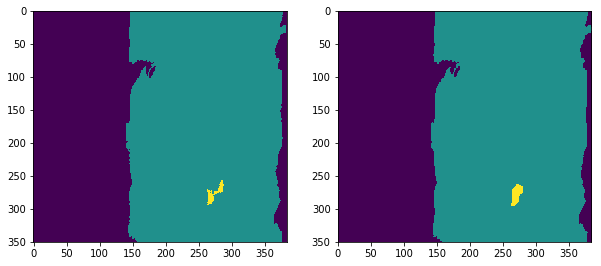

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 149, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 109, Metal: 0, Groups total: 1.0


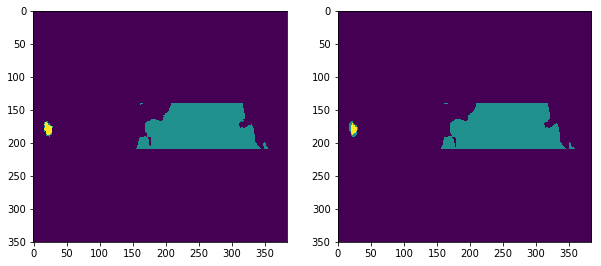

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 515, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 550, Metal: 0, Groups total: 1.0


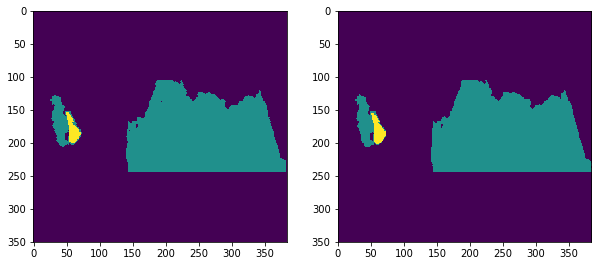

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 176, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


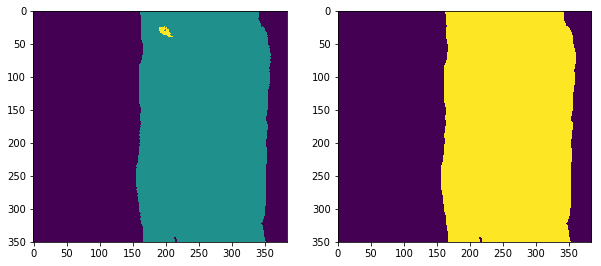

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 645, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 513, Metal: 0, Groups total: 2.0


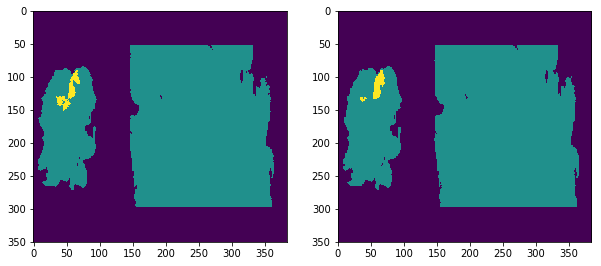

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 96, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 1.0


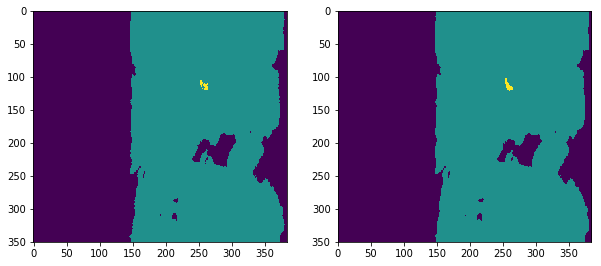

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


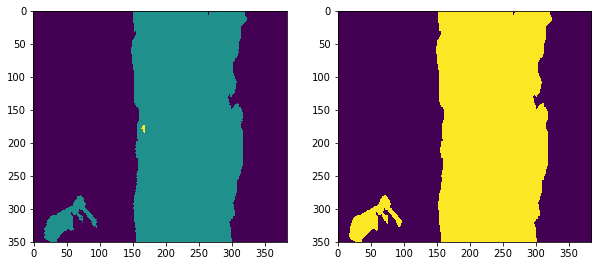

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 231, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 23, Metal: 0, Groups total: 2.0


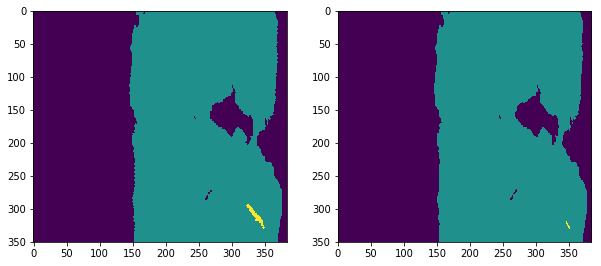

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 89, Metal: 0, Groups total: 1.0


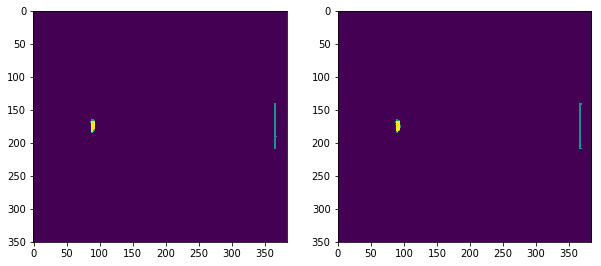

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


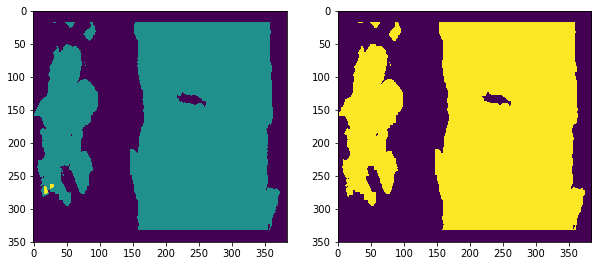

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 62, Metal: 0, Groups total: 1.0


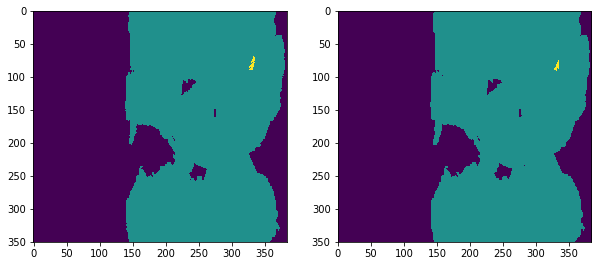

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 155, Metal: 0, Groups total: 1.0


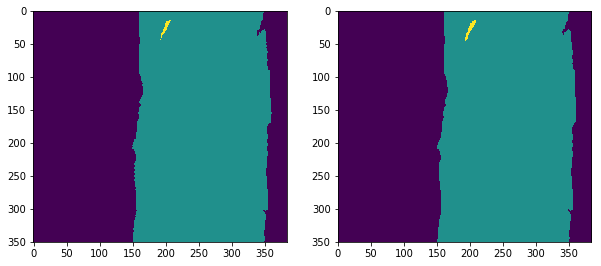

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 170, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 6, Metal: 0, Groups total: 1.0


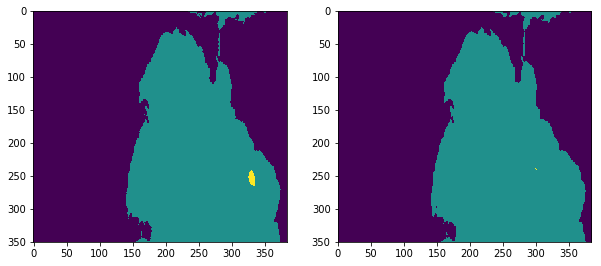

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 68, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 55, Metal: 0, Groups total: 2.0


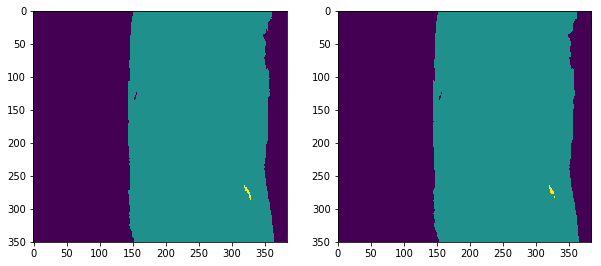

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 337, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 492, Metal: 0, Groups total: 2.0


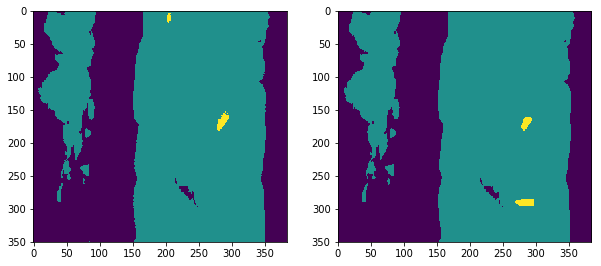

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 465, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 71, Metal: 0, Groups total: 2.0


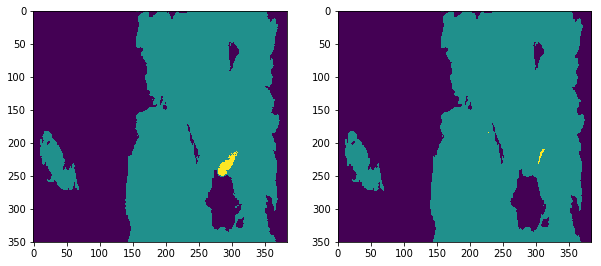

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 108, Metal: 0, Groups total: 1.0


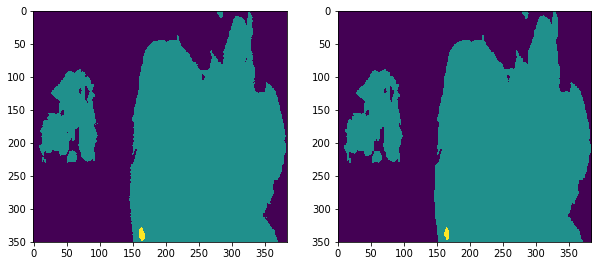

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1120, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1056, Metal: 0, Groups total: 2.0


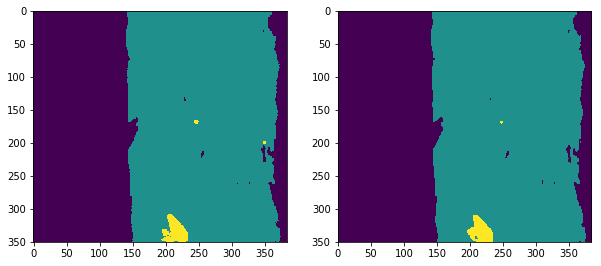

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 149, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 223, Metal: 0, Groups total: 4.0


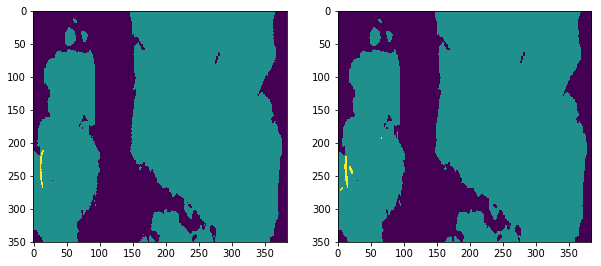

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 97, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 63, Metal: 0, Groups total: 2.0


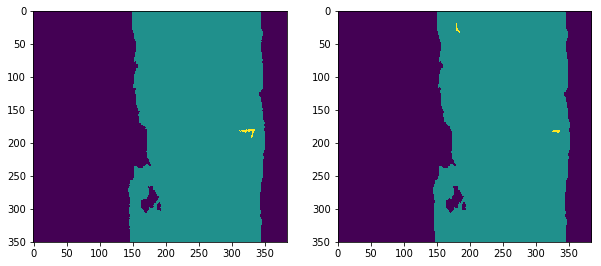

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1377, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1383, Metal: 0, Groups total: 3.0


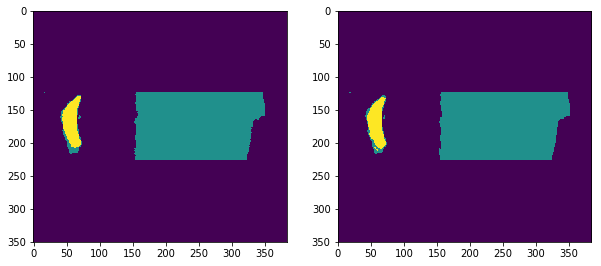

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 165, Metal: 0, Groups total: 2.0


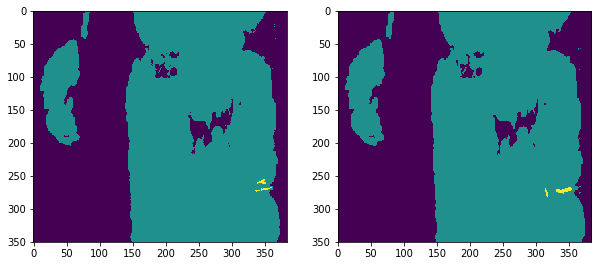

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 136, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


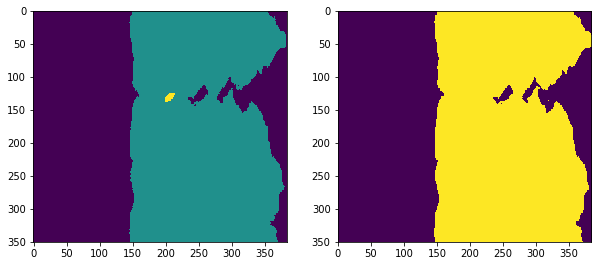

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 181, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 158, Metal: 0, Groups total: 1.0


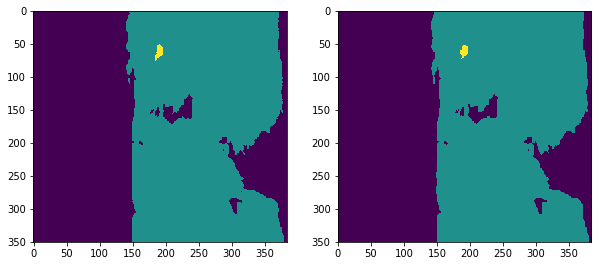

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 87, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


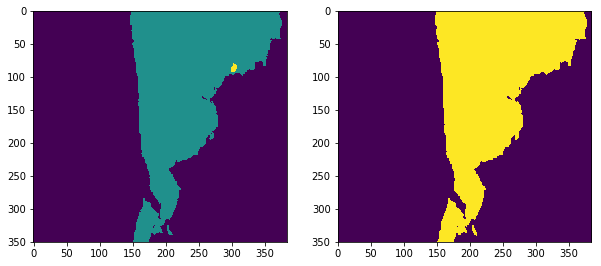

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 339, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 81, Metal: 0, Groups total: 4.0


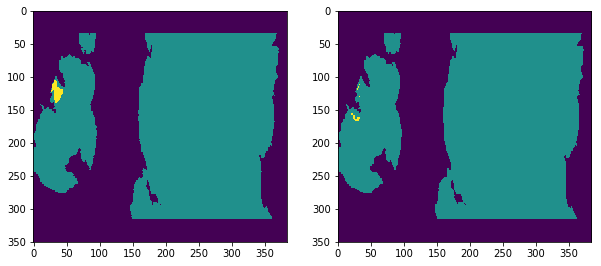

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 607, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 210, Metal: 0, Groups total: 1.0


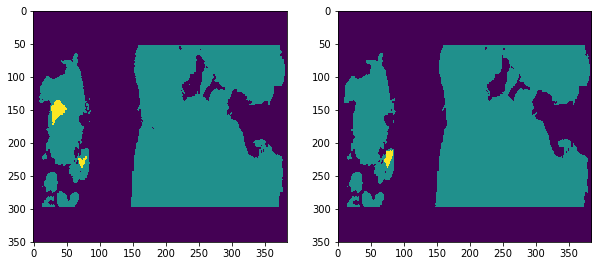

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 238, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 32, Metal: 0, Groups total: 1.0


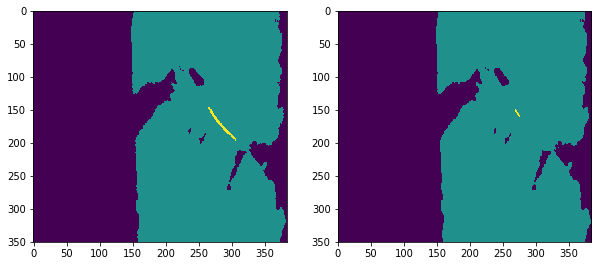

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 370, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


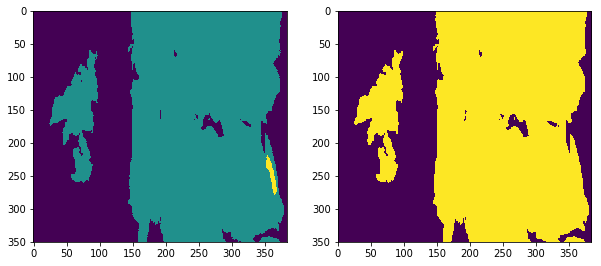

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


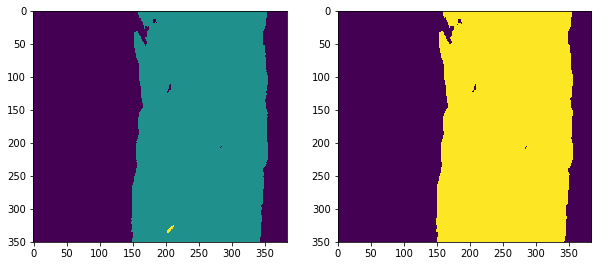

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 180, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 4.0


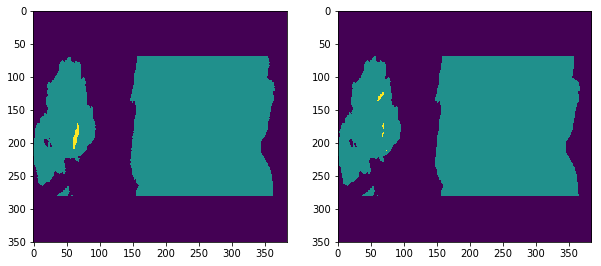

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


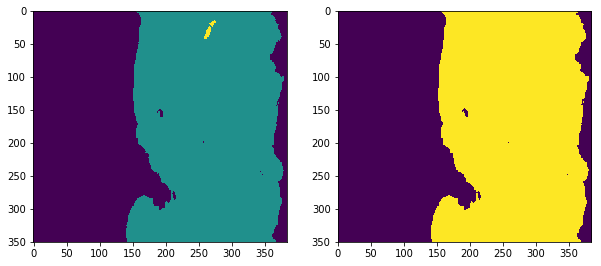

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 51, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 78, Metal: 0, Groups total: 2.0


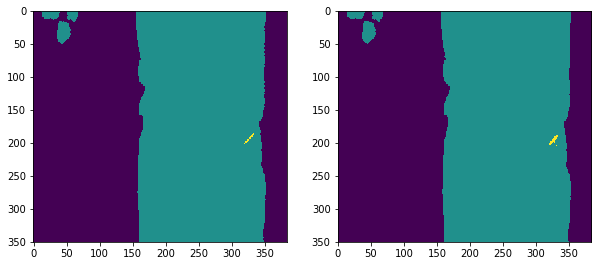

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 103, Metal: 0, Groups total: 2.0


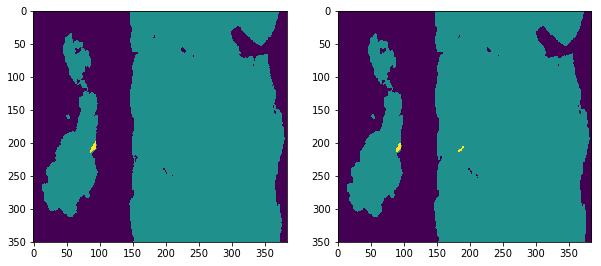

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 200, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 112, Metal: 0, Groups total: 1.0


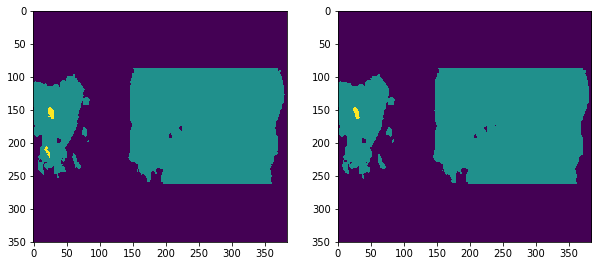

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


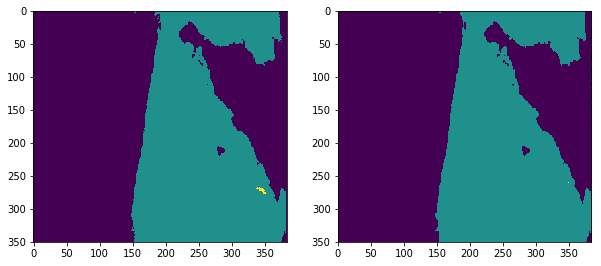

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 62, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 71, Metal: 0, Groups total: 1.0


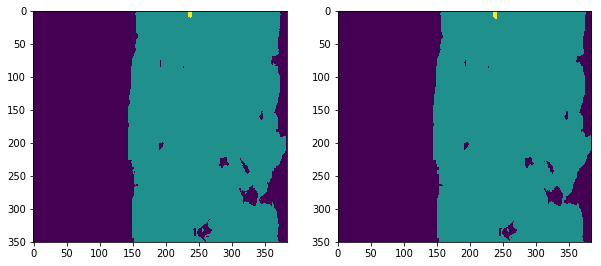

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 127, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 3.0


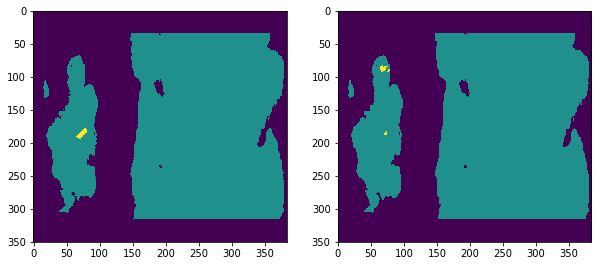

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 329, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


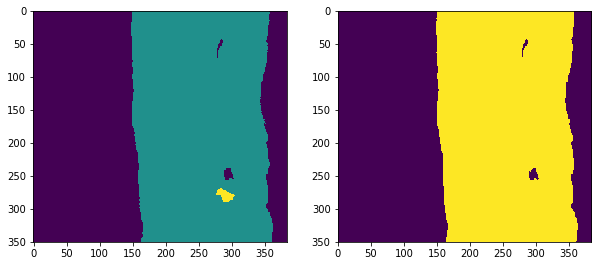

There is Metal / Found Bone and Metal
[0 1 2 3]
Pixel count
Ground truth -> Bone: 0, Metal: 1, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 4, Groups total: 2.0


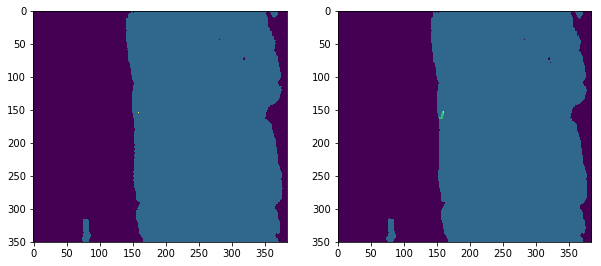

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 61, Metal: 0, Groups total: 1.0


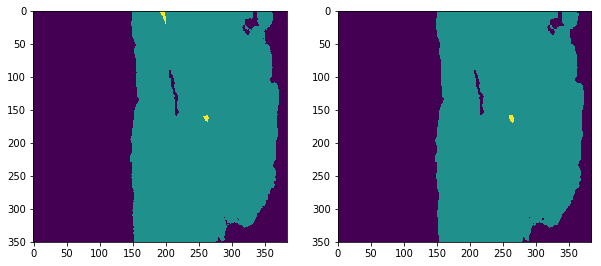

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 67, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


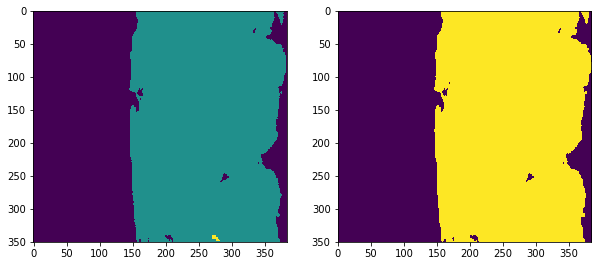

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 362, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 513, Metal: 0, Groups total: 4.0


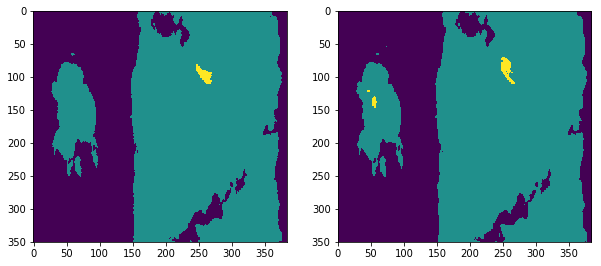

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


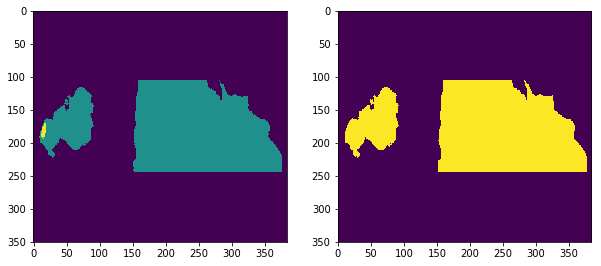

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 418, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 500, Metal: 0, Groups total: 1.0


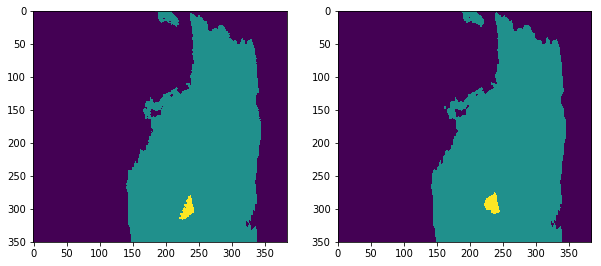

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 312, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 32, Metal: 0, Groups total: 1.0


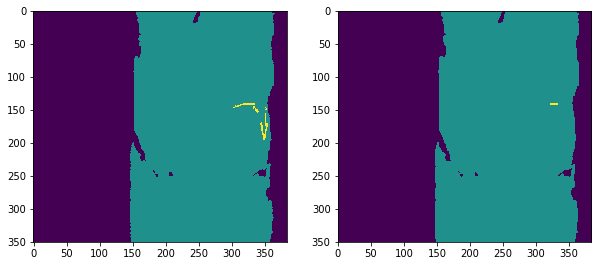

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 627, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 628, Metal: 0, Groups total: 1.0


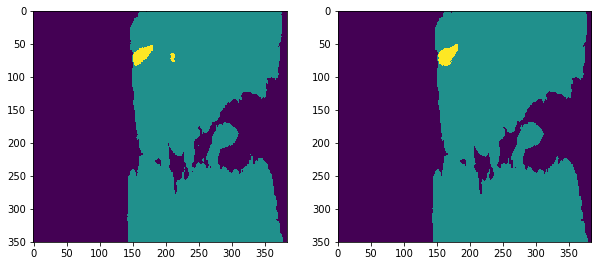

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 135, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 105, Metal: 0, Groups total: 2.0


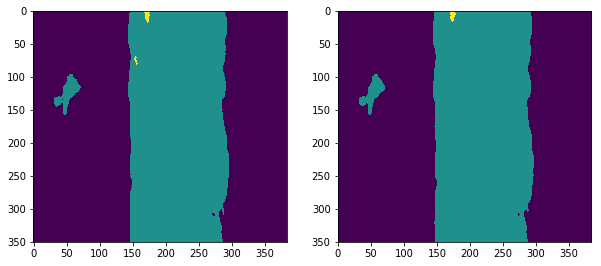

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 69, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 1.0


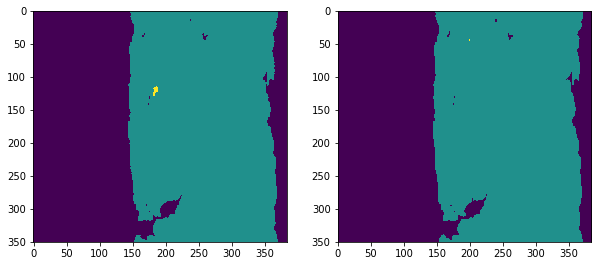

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 60, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


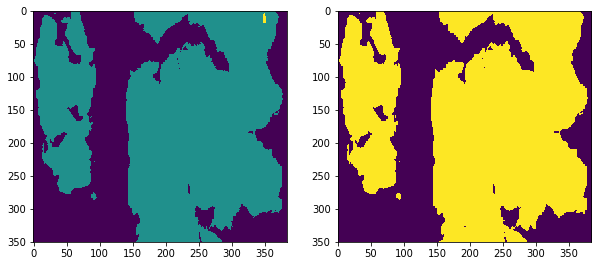

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 338, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 223, Metal: 0, Groups total: 3.0


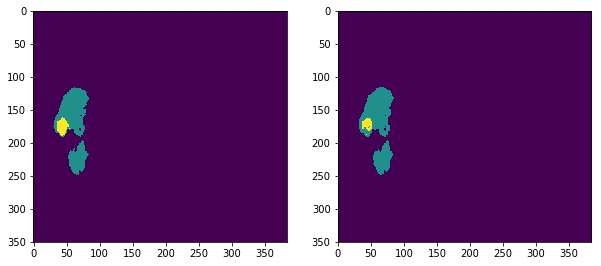

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 248, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


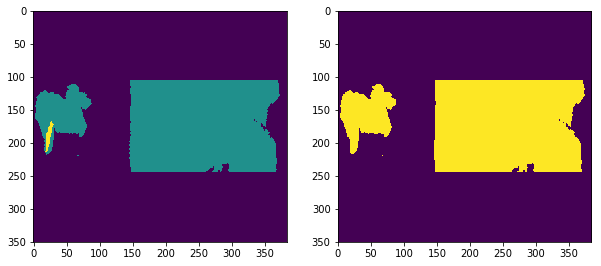

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 4634, Metal: 0, Groups total: 11.0
Prediction   -> Bone: 4008, Metal: 0, Groups total: 12.0


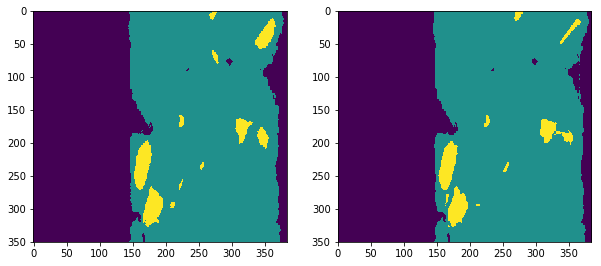

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 52, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 141, Metal: 0, Groups total: 1.0


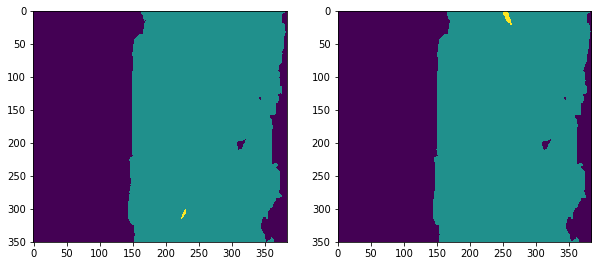

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1745, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 327, Metal: 0, Groups total: 4.0


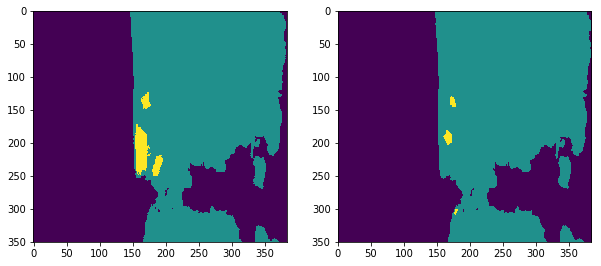

There is Metal / Found Metal
[0 1 3]
Pixel count
Ground truth -> Bone: 0, Metal: 2, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 8, Groups total: 1.0


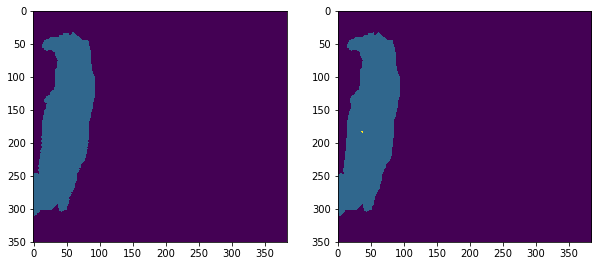

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 83, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 295, Metal: 0, Groups total: 2.0


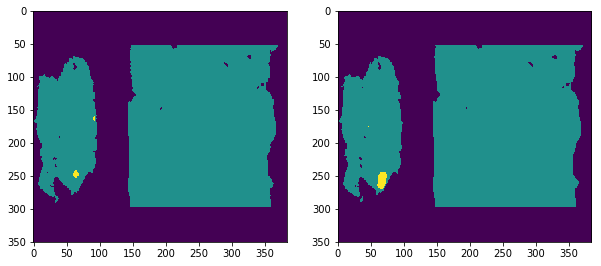

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 50, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


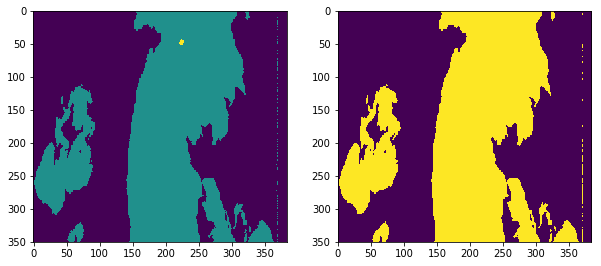

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 151, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 311, Metal: 0, Groups total: 1.0


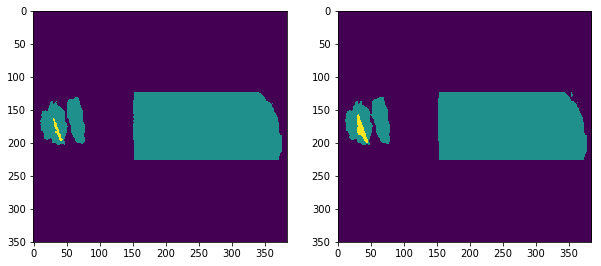

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 104, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


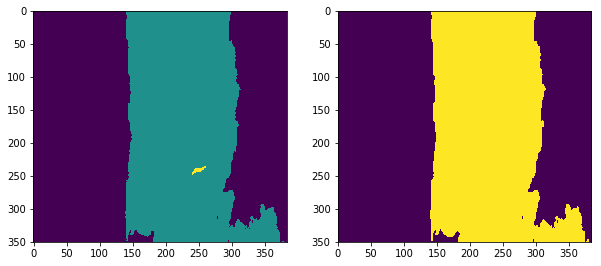

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 48, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 251, Metal: 0, Groups total: 2.0


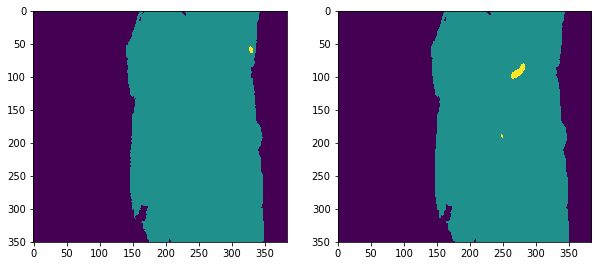

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 90, Metal: 0, Groups total: 1.0


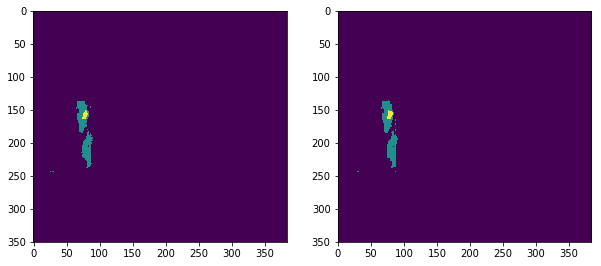

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 105, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


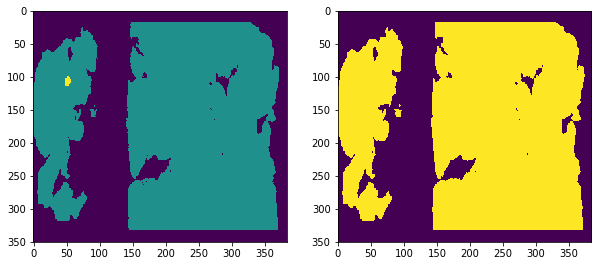

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 50, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 173, Metal: 0, Groups total: 2.0


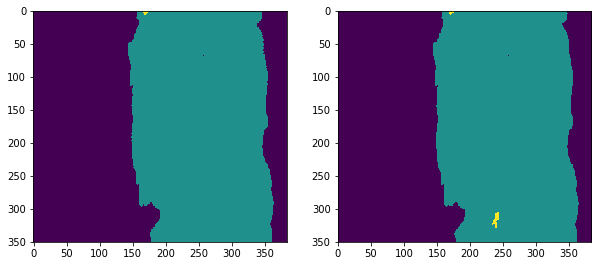

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 134, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 9, Metal: 0, Groups total: 1.0


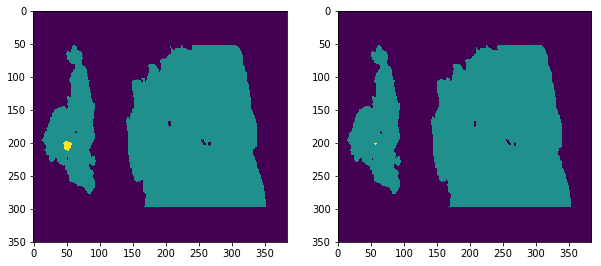

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


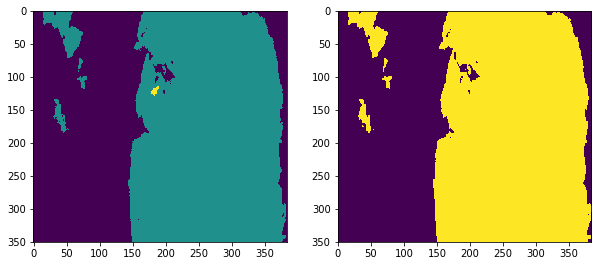

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 79, Metal: 0, Groups total: 1.0


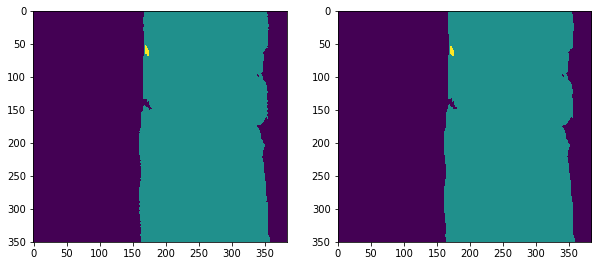

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 2474, Metal: 0, Groups total: 5.0
Prediction   -> Bone: 902, Metal: 0, Groups total: 4.0


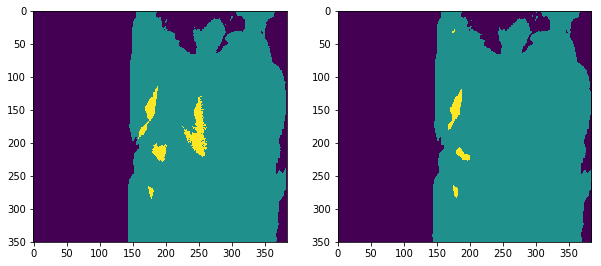

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 85, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 0, Groups total: 1.0


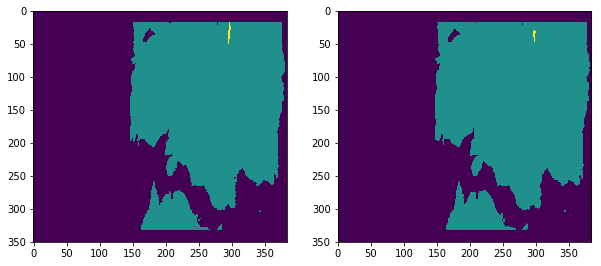

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 719, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 710, Metal: 0, Groups total: 1.0


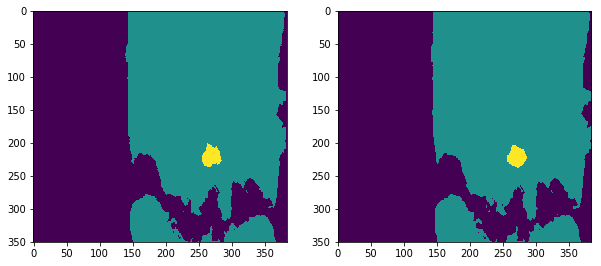

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 157, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 25, Metal: 0, Groups total: 3.0


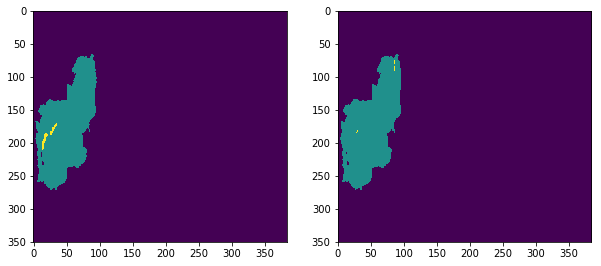

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 265, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


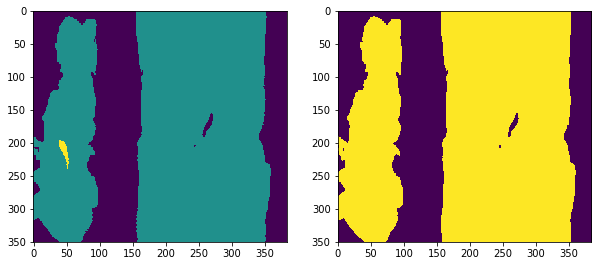

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 159, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 153, Metal: 0, Groups total: 1.0


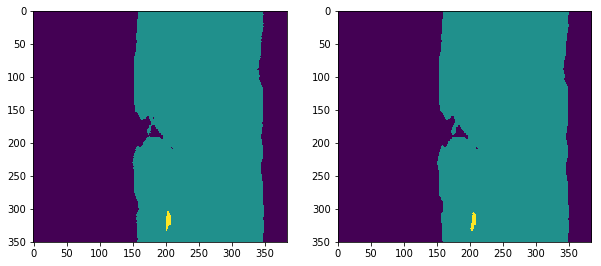

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 730, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 872, Metal: 0, Groups total: 3.0


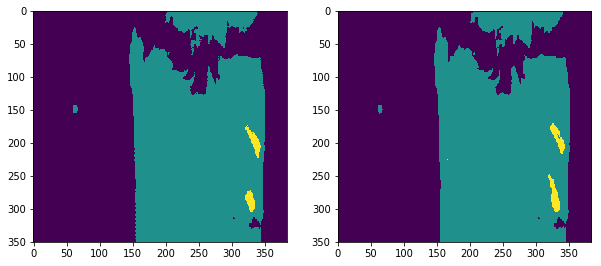

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 290, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 455, Metal: 0, Groups total: 3.0


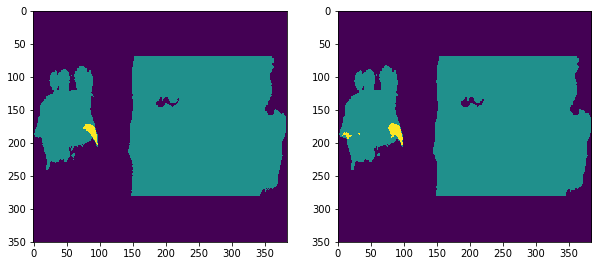

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 51, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


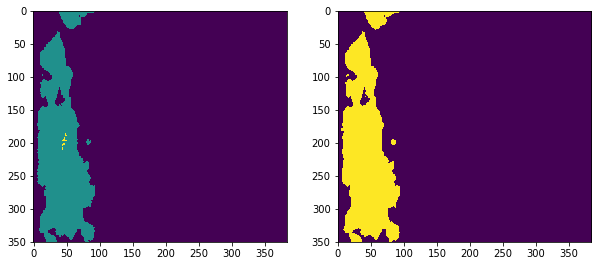

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1276, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 632, Metal: 0, Groups total: 3.0


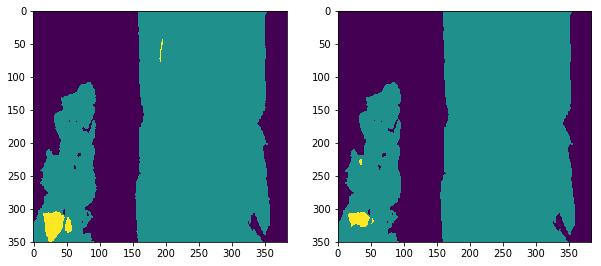

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 183, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 3.0


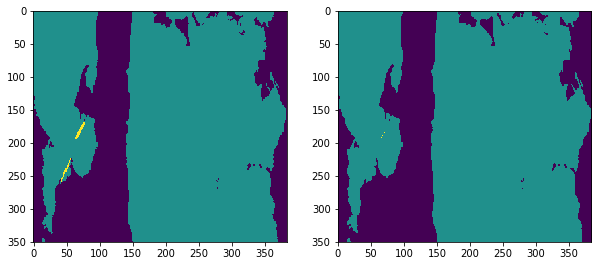

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 93, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 103, Metal: 0, Groups total: 1.0


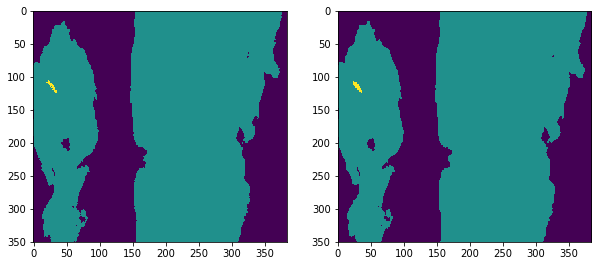

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 205, Metal: 0, Groups total: 4.0


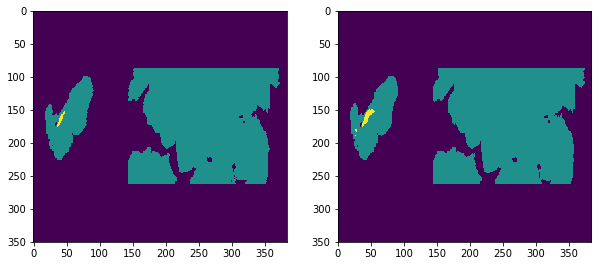

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 518, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 666, Metal: 0, Groups total: 1.0


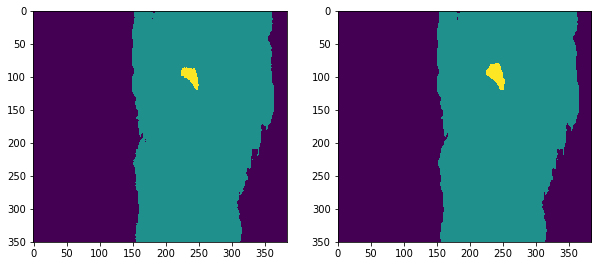

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 71, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


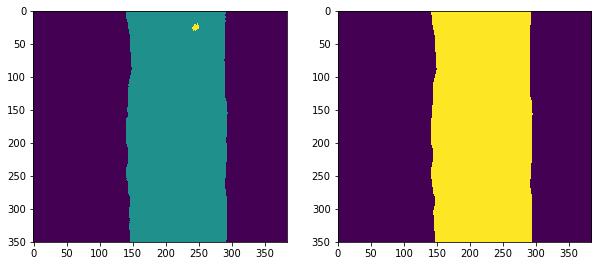

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 52, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 53, Metal: 0, Groups total: 1.0


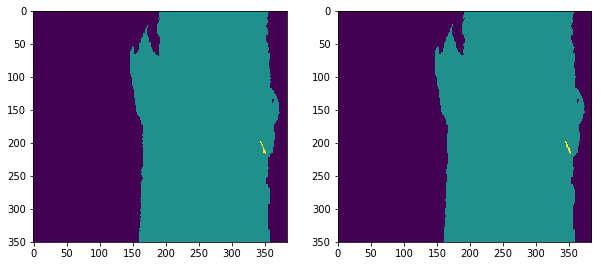

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 325, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 75, Metal: 0, Groups total: 1.0


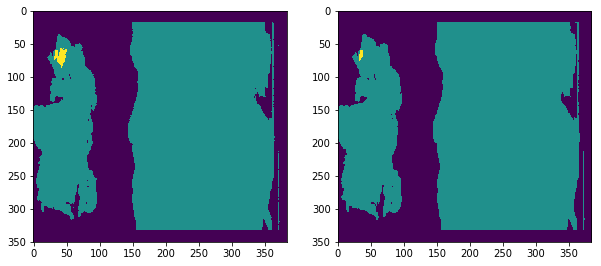

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 538, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 88, Metal: 0, Groups total: 2.0


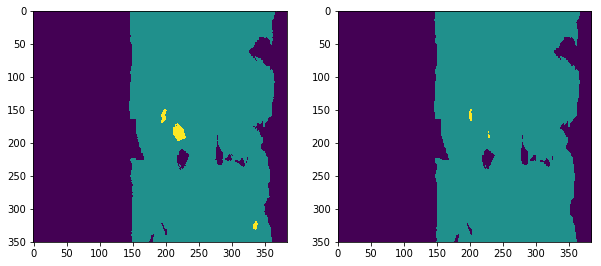

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 90, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


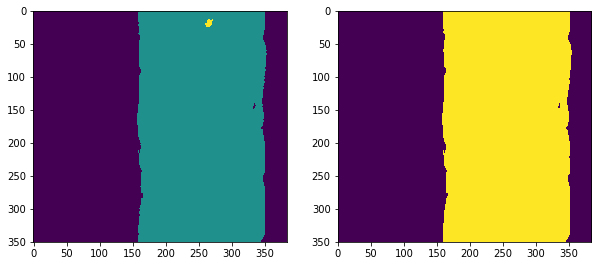

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 88, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 226, Metal: 0, Groups total: 1.0


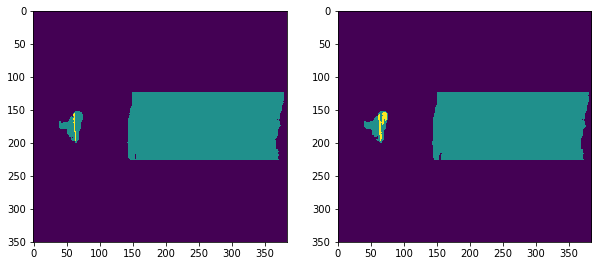

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 51, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 6, Metal: 0, Groups total: 1.0


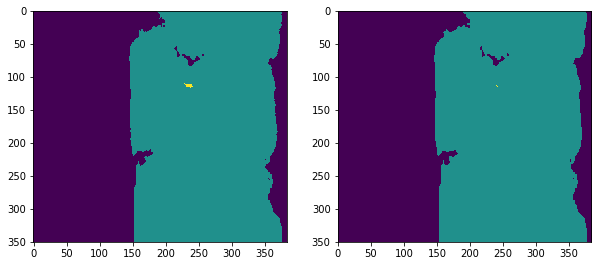

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 786, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 799, Metal: 0, Groups total: 2.0


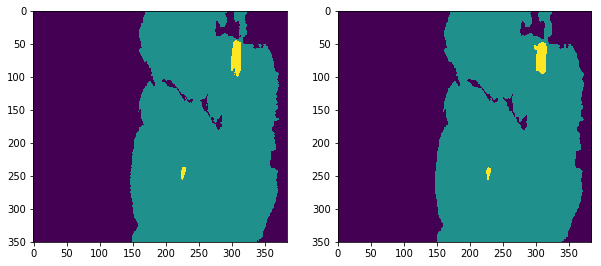

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 25, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 84, Metal: 0, Groups total: 1.0


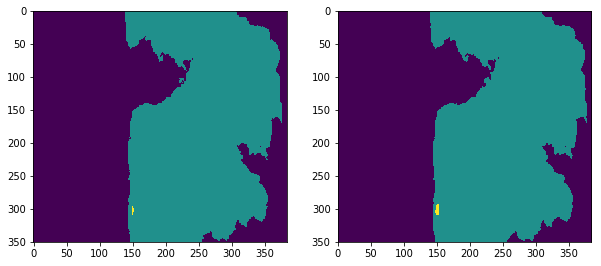

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 272, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 357, Metal: 0, Groups total: 1.0


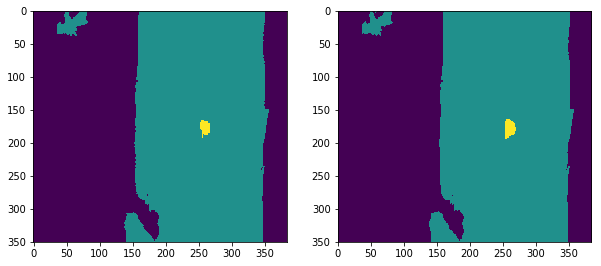

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 240, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 312, Metal: 0, Groups total: 1.0


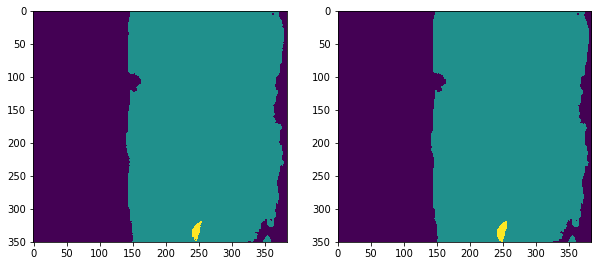

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 61, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 1.0


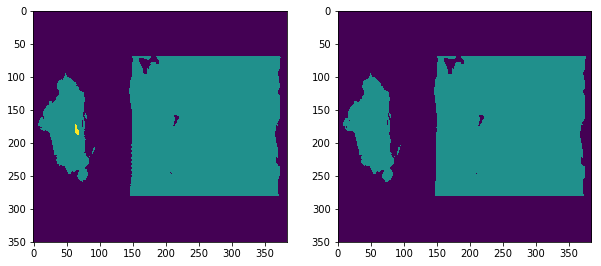

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 41, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 62, Metal: 0, Groups total: 2.0


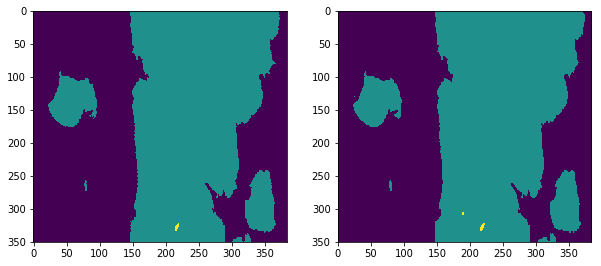

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 552, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


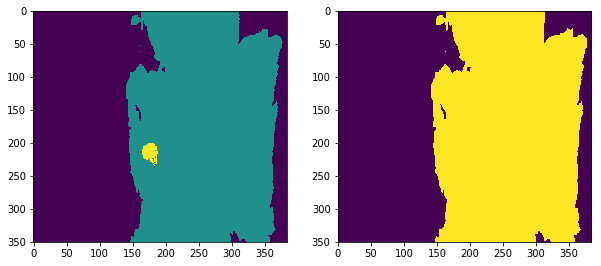

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 107, Metal: 0, Groups total: 1.0


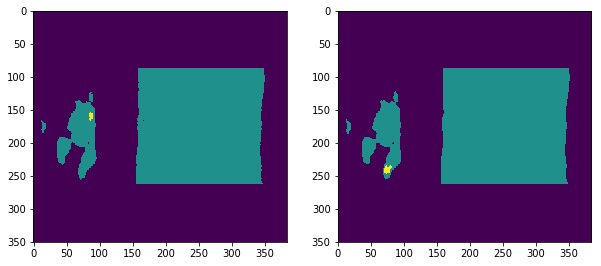

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 179, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 189, Metal: 0, Groups total: 1.0


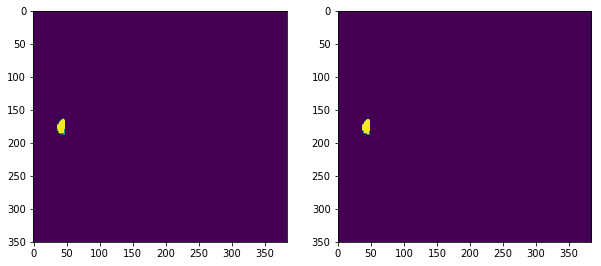

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 113, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


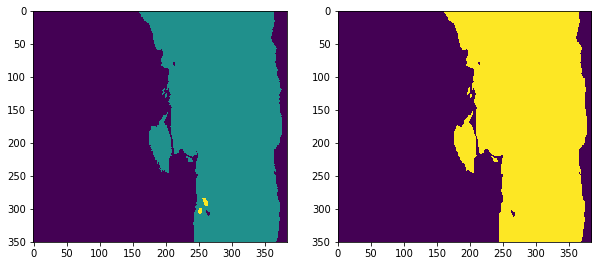

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 79, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 78, Metal: 0, Groups total: 1.0


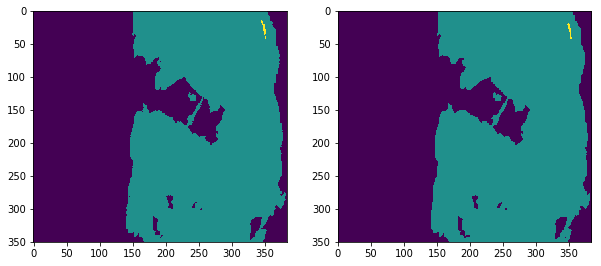

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 599, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


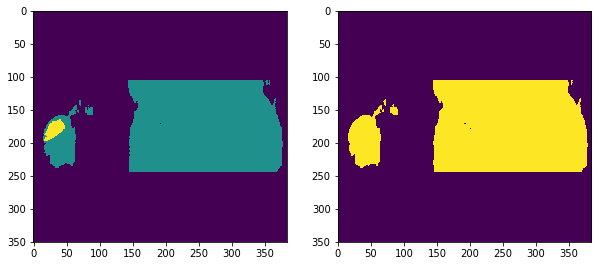

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 141, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 152, Metal: 0, Groups total: 2.0


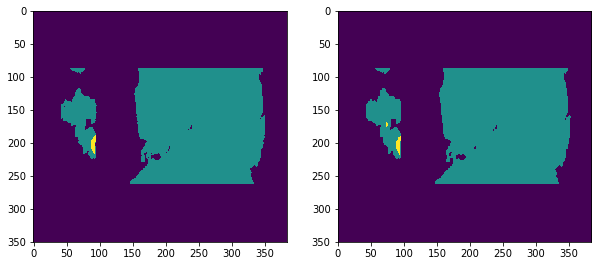

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 109, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 200, Metal: 0, Groups total: 4.0


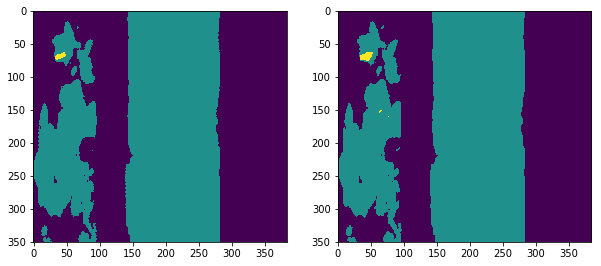

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1429, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 325, Metal: 0, Groups total: 2.0


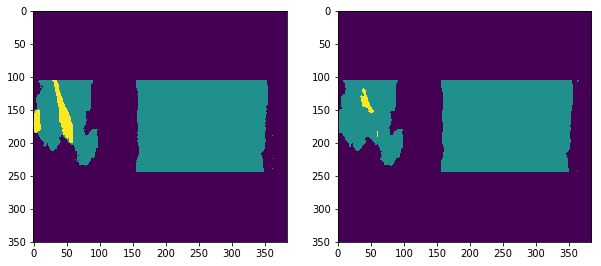

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


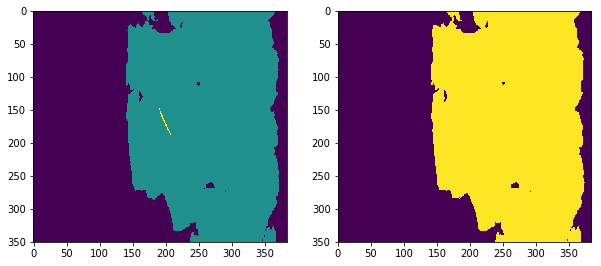

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 57, Metal: 0, Groups total: 1.0


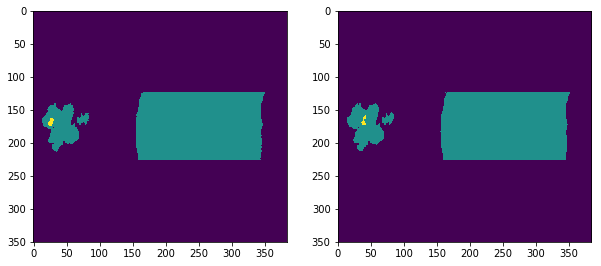

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 326, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 174, Metal: 0, Groups total: 1.0


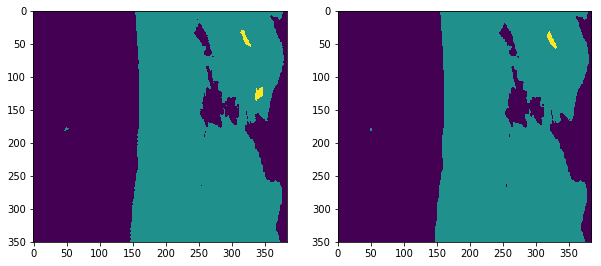

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 54, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 15, Metal: 0, Groups total: 1.0


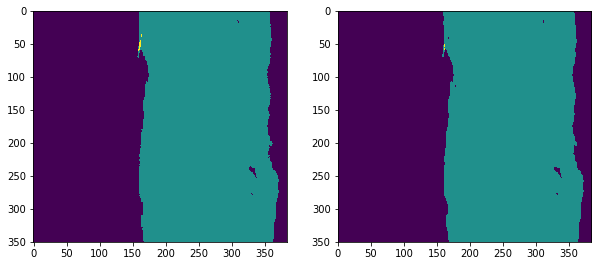

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 42, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 33, Metal: 0, Groups total: 1.0


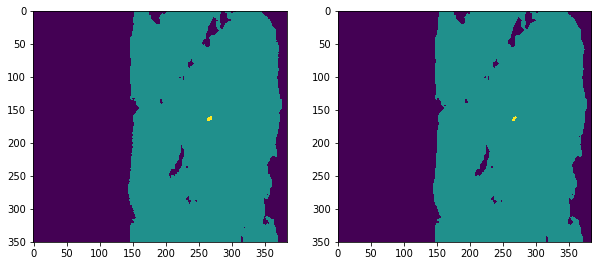

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 32, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 65, Metal: 0, Groups total: 2.0


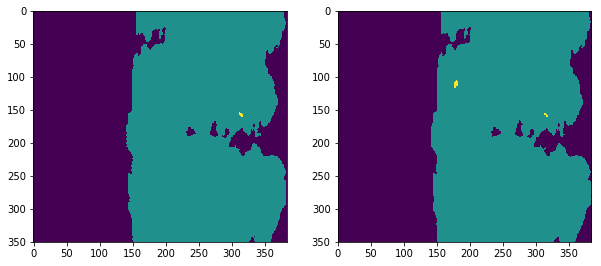

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 70, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


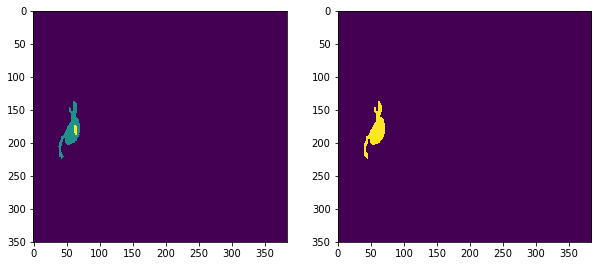

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 56, Metal: 0, Groups total: 1.0


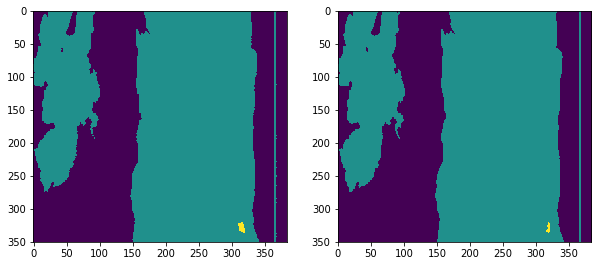

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 99, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 121, Metal: 0, Groups total: 1.0


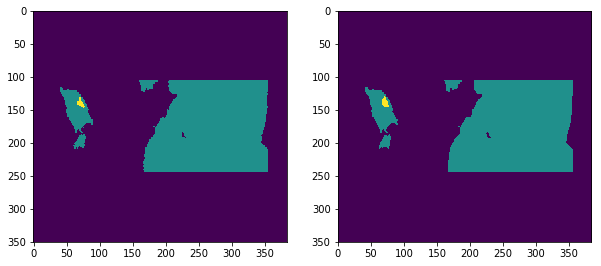

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 122, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 122, Metal: 0, Groups total: 1.0


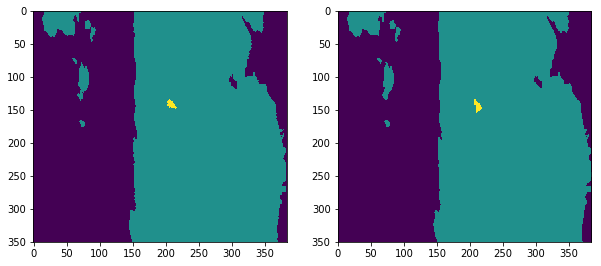

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 371, Metal: 0, Groups total: 4.0
Prediction   -> Bone: 98, Metal: 0, Groups total: 3.0


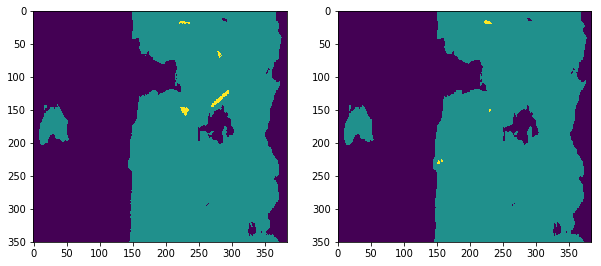

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 271, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


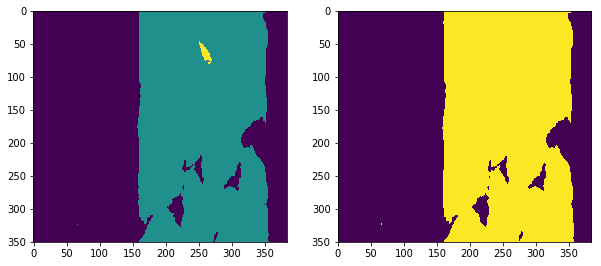

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


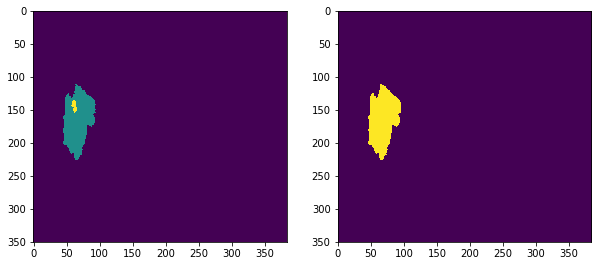

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 466, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 14, Metal: 0, Groups total: 3.0


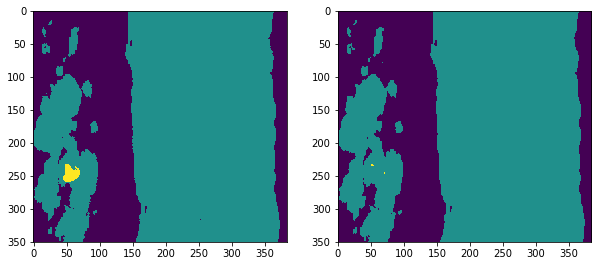

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 58, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


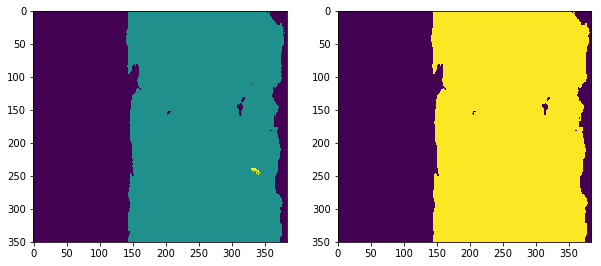

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 44, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1, Metal: 0, Groups total: 1.0


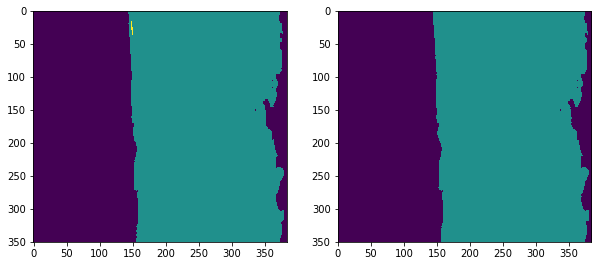

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 2, Metal: 0, Groups total: 2.0


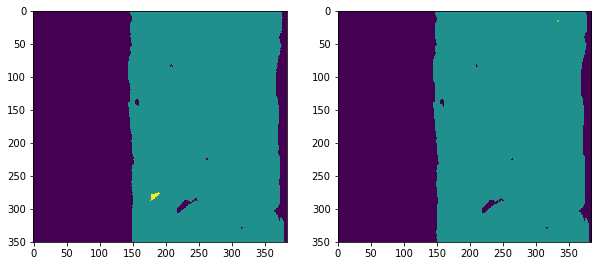

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 264, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 301, Metal: 0, Groups total: 1.0


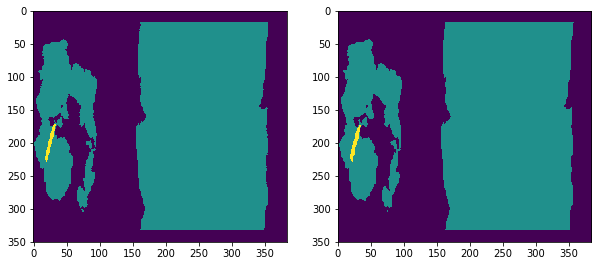

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 193, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


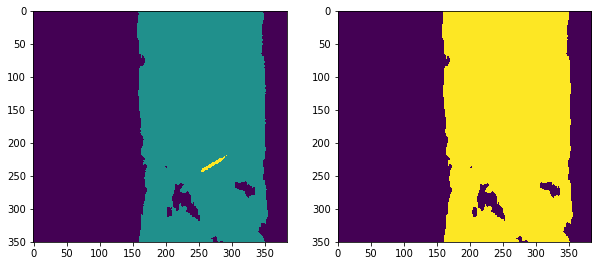

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 431, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 104, Metal: 0, Groups total: 2.0


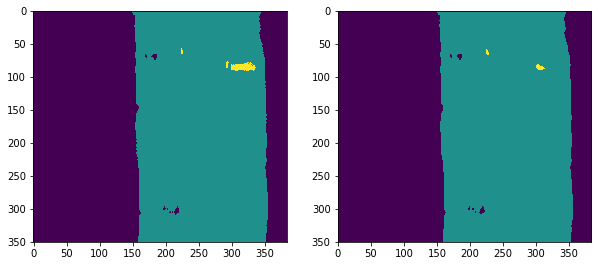

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 271, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 344, Metal: 0, Groups total: 1.0


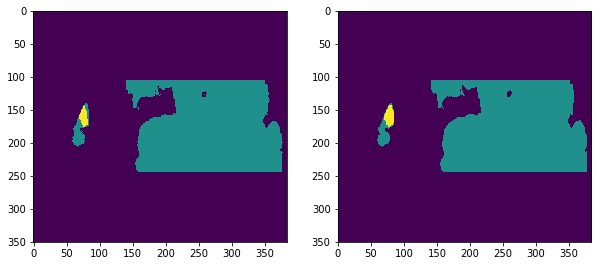

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 137, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 218, Metal: 0, Groups total: 7.0


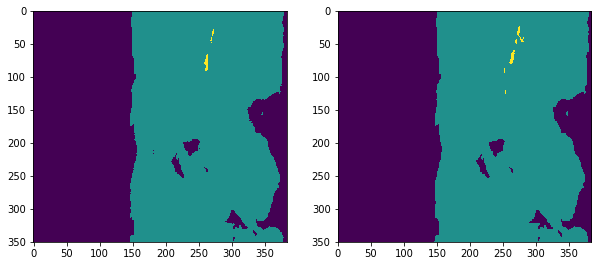

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 93, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 17, Metal: 0, Groups total: 1.0


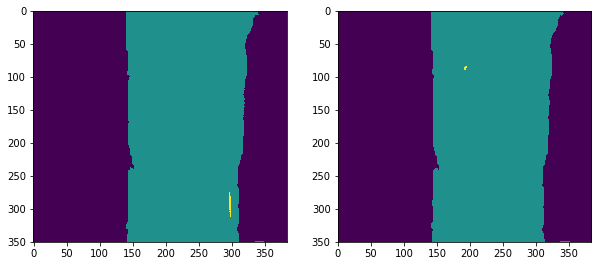

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 184, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


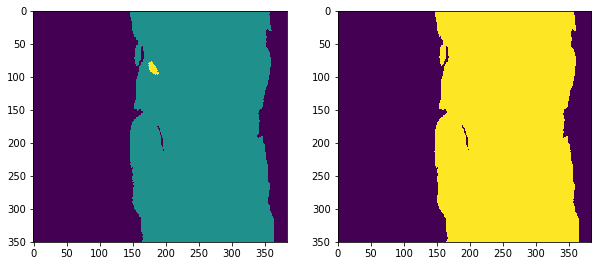

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 82, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 308, Metal: 0, Groups total: 3.0


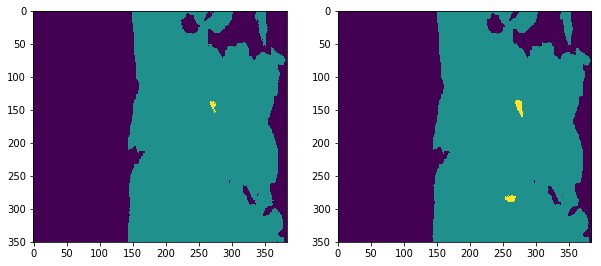

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 441, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 248, Metal: 0, Groups total: 1.0


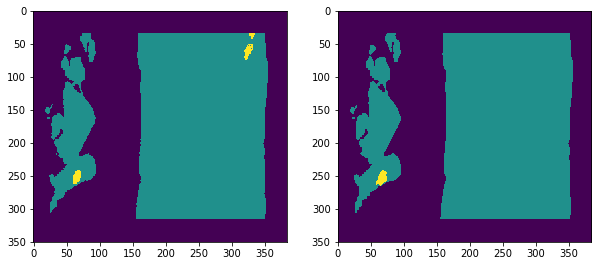

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 256, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 168, Metal: 0, Groups total: 4.0


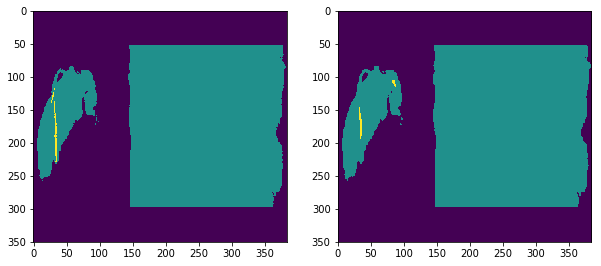

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 71, Metal: 0, Groups total: 2.0


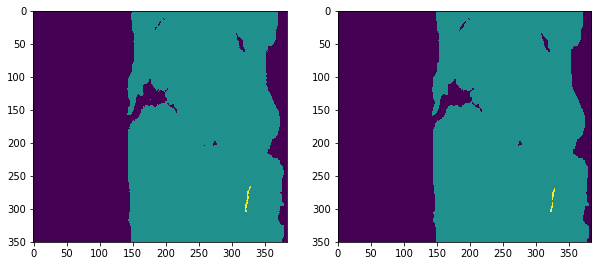

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 179, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 8, Metal: 0, Groups total: 1.0


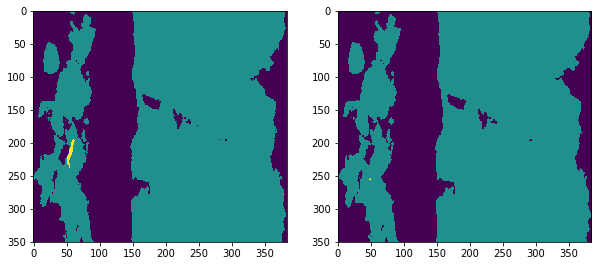

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 178, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 32, Metal: 0, Groups total: 3.0


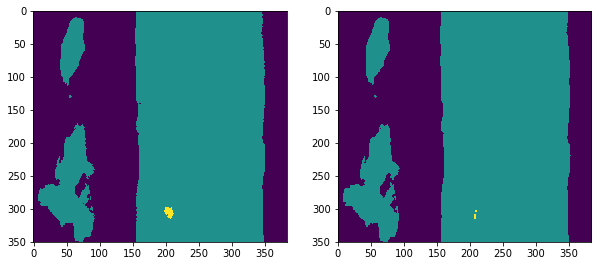

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 55, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 0, Groups total: 1.0


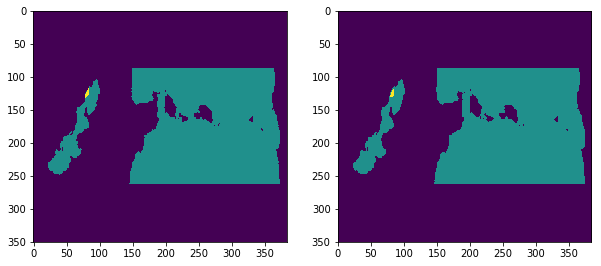

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 102, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


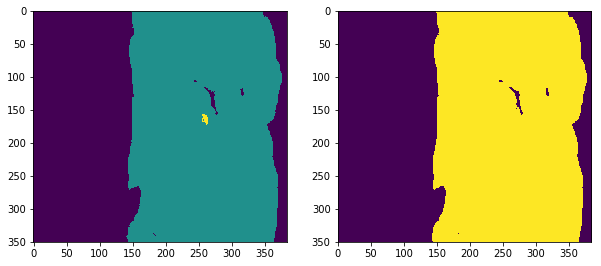

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 84, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 101, Metal: 0, Groups total: 1.0


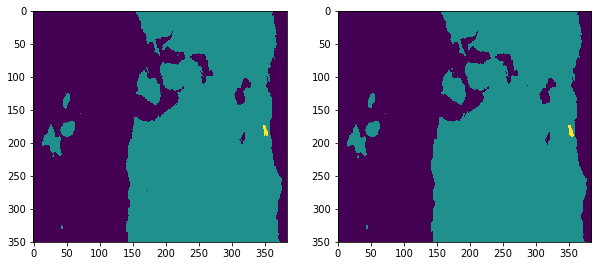

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 158, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 140, Metal: 0, Groups total: 5.0


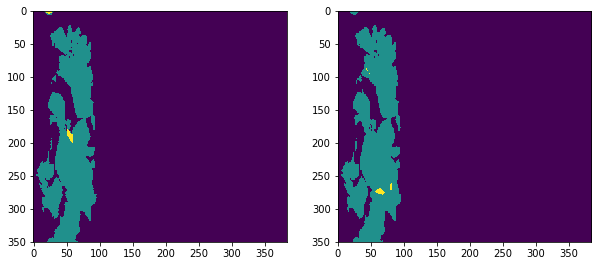

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 218, Metal: 0, Groups total: 1.0


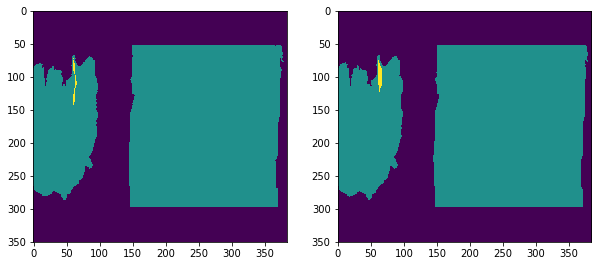

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 95, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


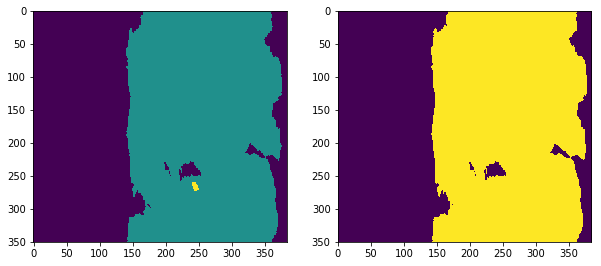

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 152, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 145, Metal: 0, Groups total: 2.0


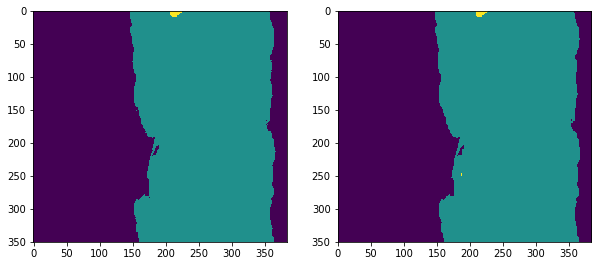

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 74, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 102, Metal: 0, Groups total: 2.0


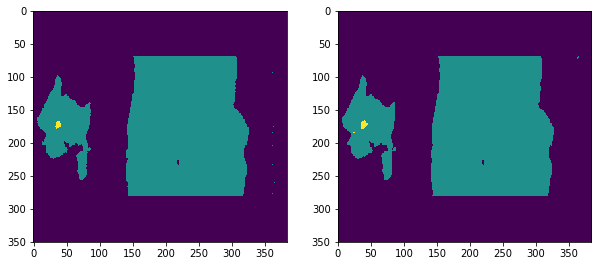

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 675, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 587, Metal: 0, Groups total: 3.0


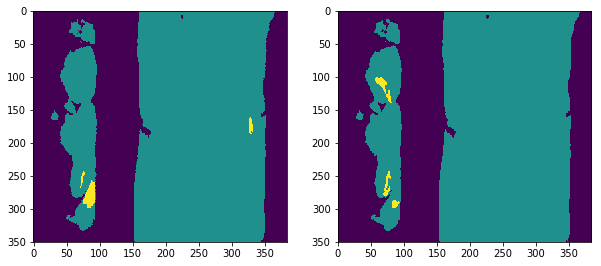

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 94, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


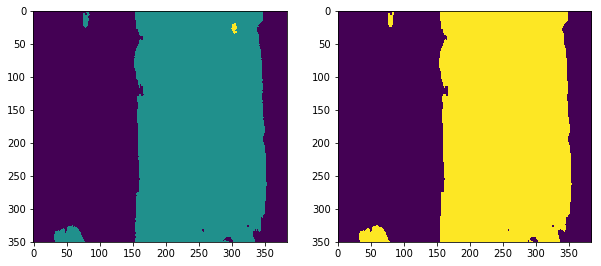

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 53, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


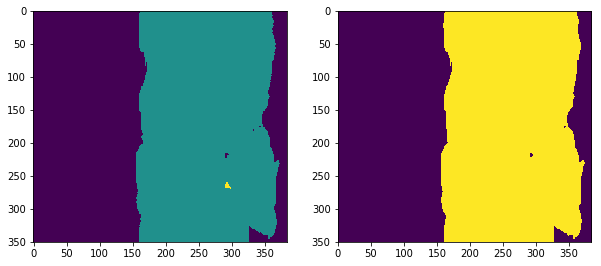

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 230, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


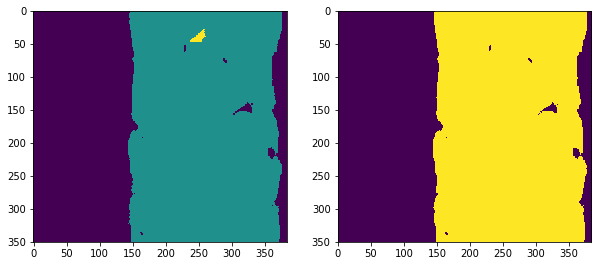

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1332, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 1145, Metal: 0, Groups total: 1.0


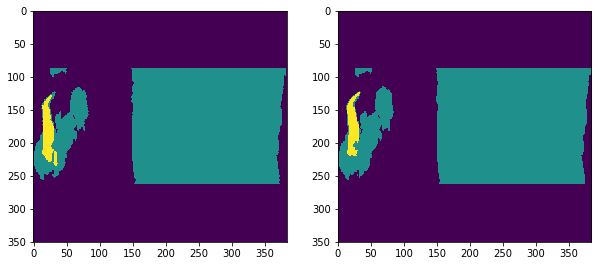

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 76, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


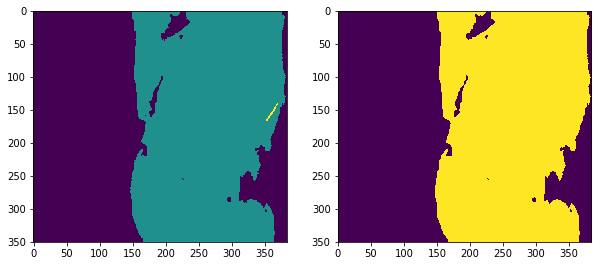

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 187, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


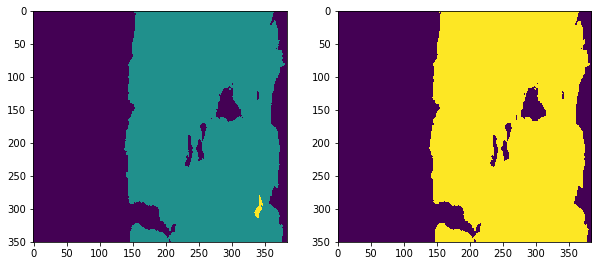

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 970, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 1413, Metal: 0, Groups total: 1.0


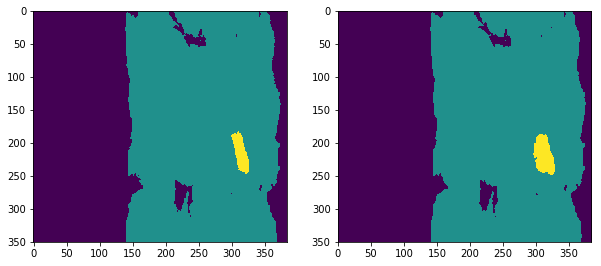

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 126, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 156, Metal: 0, Groups total: 2.0


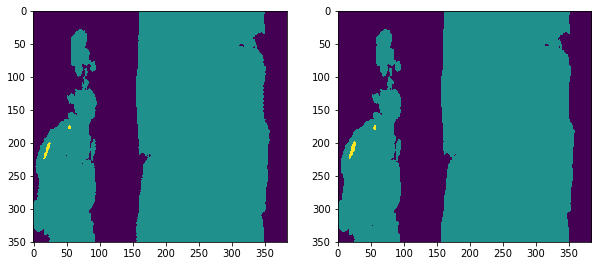

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 128, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 7, Metal: 0, Groups total: 2.0


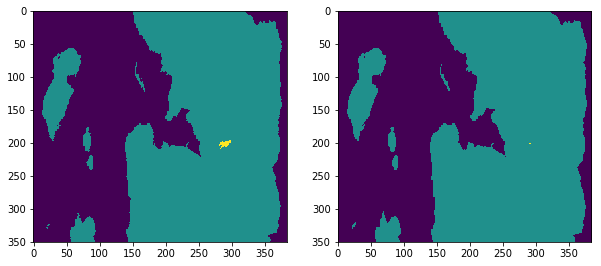

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 1123, Metal: 0, Groups total: 3.0
Prediction   -> Bone: 1179, Metal: 0, Groups total: 11.0


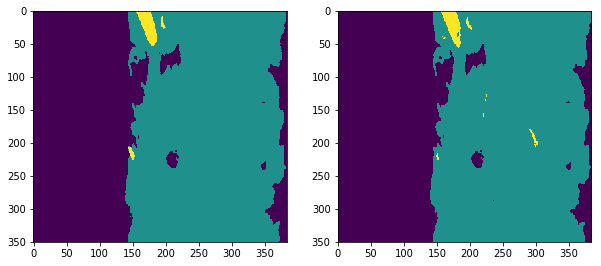

There is Bone / Found Bone
[0 1 2]
Pixel count
Ground truth -> Bone: 189, Metal: 0, Groups total: 2.0
Prediction   -> Bone: 146, Metal: 0, Groups total: 1.0


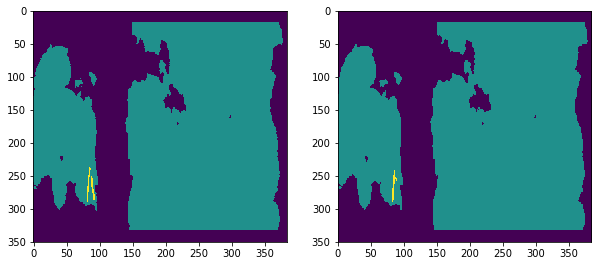

There is Bone / Found just Meat
[0 1]
Pixel count
Ground truth -> Bone: 114, Metal: 0, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 0, Groups total: 0.0


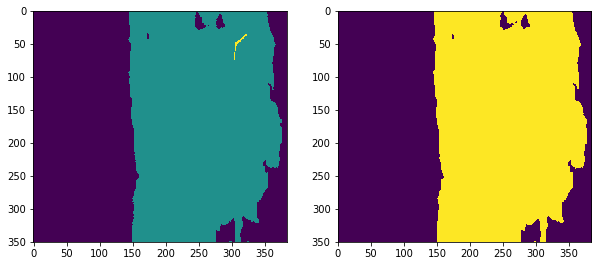

In [41]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(preds.shape[0]):
    prediction = preds.argmax(dim=1)[i]
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print(np.unique(prediction))
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3]), numb_contaminants(y[i])))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()
    

### The three metal images selcted for metal validation

Time for prediction: 9.486078977584839 seconds
There is Metal / Found Metal
[0 1 3]
Pixel count
Ground truth -> Bone: 0, Metal: 11, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 9, Groups total: 1.0


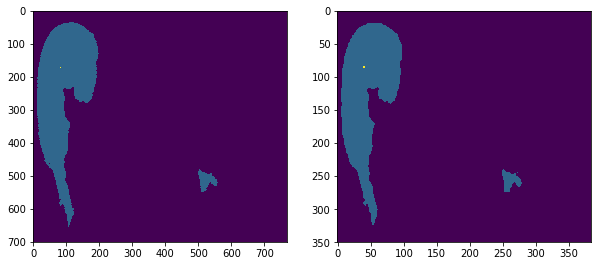

Time for prediction: 0.1683180332183838 seconds
There is Metal / Found Bone and Metal
[0 1 2 3]
Pixel count
Ground truth -> Bone: 0, Metal: 3, Groups total: 1.0
Prediction   -> Bone: 50, Metal: 4, Groups total: 2.0


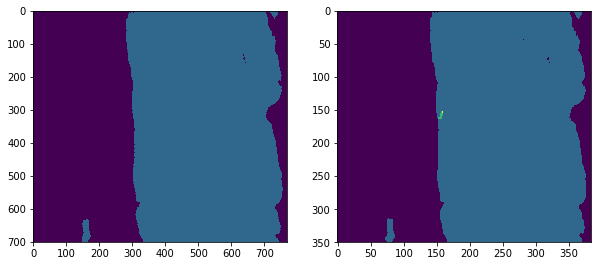

Time for prediction: 0.12961339950561523 seconds
There is Metal / Found Metal
[0 1 3]
Pixel count
Ground truth -> Bone: 0, Metal: 5, Groups total: 1.0
Prediction   -> Bone: 0, Metal: 8, Groups total: 1.0


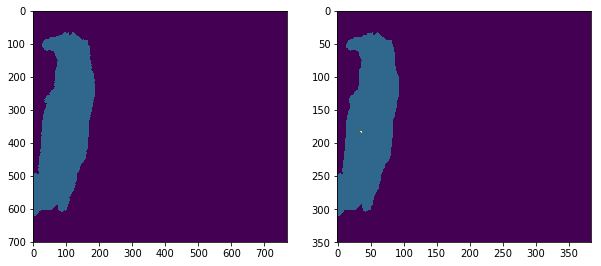

In [42]:
import time

# These validaion_metals are defined here above
validation_metal = ['MAGNA_56_-1CL_0.446517kg.tiff', 'MAGNA_61_83.7706CL_3.88116kg.tiff',
                             'MAGNA_54_-1CL_0.441927kg.tiff']
for name in validation_metal:
    groundTruth = open_image(path / ('masks/' + name), div=False).data[0, :, :]
    t = time.time()
    preds = learn.predict(open_image(path / ('images/' + name)))
    elapsed = time.time() - t
    print("Time for prediction: {} seconds".format(elapsed))

    prediction = preds[1][0, :, :]
    print("There is {} / Found {}".format(getContanimentInfo(groundTruth), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(groundTruth)
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print(np.unique(prediction))
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}, Groups total: {}".format(len(groundTruth[groundTruth == 2]), len(groundTruth[groundTruth == 3]), numb_contaminants(groundTruth)))
    print("Prediction   -> Bone: {}, Metal: {}, Groups total: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3]), numb_contaminants(prediction)))
    plt.show()

In [43]:
total = len(validation_files)
time_sum = 0
for name in validation_files:
    groundTruth = open_image(path / ('masks/' + name), div=False).data[0, :, :]
    t = time.time()
    preds = learn.predict(open_image(path / ('images/' + name)))
    elapsed = time.time() - t
    time_sum += elapsed
    print("Time for prediction: {} seconds".format(elapsed))
    
print("\nThe average is: {} seconds".format(time_sum / total))

Time for prediction: 0.13213539123535156 seconds
Time for prediction: 0.13424062728881836 seconds
Time for prediction: 0.1448225975036621 seconds
Time for prediction: 0.12110567092895508 seconds
Time for prediction: 0.13751554489135742 seconds
Time for prediction: 0.1220090389251709 seconds
Time for prediction: 0.12218046188354492 seconds
Time for prediction: 0.1199789047241211 seconds
Time for prediction: 0.11852049827575684 seconds
Time for prediction: 0.12047553062438965 seconds
Time for prediction: 0.14542865753173828 seconds
Time for prediction: 0.11600470542907715 seconds
Time for prediction: 0.12151598930358887 seconds
Time for prediction: 0.11611652374267578 seconds
Time for prediction: 0.12200140953063965 seconds
Time for prediction: 0.12041068077087402 seconds
Time for prediction: 0.11721134185791016 seconds
Time for prediction: 0.1413862705230713 seconds
Time for prediction: 0.1366727352142334 seconds
Time for prediction: 0.11532974243164062 seconds
Time for prediction: 0.11

Time for prediction: 0.1393730640411377 seconds
Time for prediction: 0.1201026439666748 seconds
Time for prediction: 0.12098813056945801 seconds
Time for prediction: 0.12090063095092773 seconds
Time for prediction: 0.13751435279846191 seconds
Time for prediction: 0.11620521545410156 seconds
Time for prediction: 0.11536955833435059 seconds
Time for prediction: 0.11845707893371582 seconds
Time for prediction: 0.12041449546813965 seconds
Time for prediction: 0.11742377281188965 seconds
Time for prediction: 0.11916017532348633 seconds
Time for prediction: 0.12020635604858398 seconds
Time for prediction: 0.1294233798980713 seconds
Time for prediction: 0.12015986442565918 seconds
Time for prediction: 0.15431642532348633 seconds
Time for prediction: 0.12335944175720215 seconds
Time for prediction: 0.11818242073059082 seconds
Time for prediction: 0.12736034393310547 seconds
Time for prediction: 0.14705705642700195 seconds
Time for prediction: 0.11855244636535645 seconds
Time for prediction: 0.

Time for prediction: 0.12718749046325684 seconds
Time for prediction: 0.1232302188873291 seconds
Time for prediction: 0.1311357021331787 seconds
Time for prediction: 0.1166067123413086 seconds
Time for prediction: 0.11956667900085449 seconds
Time for prediction: 0.12354278564453125 seconds
Time for prediction: 0.11957216262817383 seconds
Time for prediction: 0.12556171417236328 seconds
Time for prediction: 0.11985206604003906 seconds
Time for prediction: 0.1192014217376709 seconds
Time for prediction: 0.11938261985778809 seconds
Time for prediction: 0.1271529197692871 seconds
Time for prediction: 0.11731433868408203 seconds
Time for prediction: 0.11926627159118652 seconds
Time for prediction: 0.12116765975952148 seconds
Time for prediction: 0.13045573234558105 seconds
Time for prediction: 0.12337636947631836 seconds
Time for prediction: 0.1478281021118164 seconds
Time for prediction: 0.11829566955566406 seconds
Time for prediction: 0.12711143493652344 seconds
Time for prediction: 0.123

In [44]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 175, 192]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 175, 192]       128        True      
______________________________________________________________________
ReLU                 [64, 175, 192]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 96]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 96]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 96]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 96]         0          False     
______________________________________________________________